In [1]:
from numpy.linalg import norm
from gensim.models import FastText
import sys
import os.path as op
import random
import pandas as pd
import numpy as np 

def kmeans(data, k, maxIterations, distance="cosinus", vectorColumn="text_vec"):

    random.seed(0)
    # Initialize centroids randomly
    centroids = initialise_centroids(np.asarray(data[vectorColumn].values.tolist()), k)   # [ arr, arr, .., arr ]

    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = [np.zeros((300,)) for i in range(k)]
    
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations, maxIterations):
        print("Iterations:", iterations)
        # Save old centroids for convergence test. Book keeping.
        oldCentroids = centroids
        iterations += 1
        
        # Assign labels to each datapoint based on centroids
        data["label"] = data[vectorColumn].map(lambda d: getLabelForEachDataPoint(d, centroids, distance=distance)).astype('category')
        #labels = getLabelForEachDataPoint(data, centroids)   

        # Assign centroids based on datapoint labels
        centroids = data.groupby(by="label").apply(lambda value: getMean(value, vectorColumn))#.mean()

    # We can get the labels too by calling getLabels(dataSet, centroids)
    return data


def getMean(data, vectorColumn):
    matrix_form = np.asarray(data[vectorColumn].values.tolist())
    return np.sum(matrix_form,axis=0) / matrix_form.shape[0]


def updateCentroids(data, labels, k):
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

    # recalculate centroids
    index = 0
    for cluster in labels:
        old_centroids[index] = data[index]
        data[index] = np.mean(cluster, axis=0).tolist()
        index += 1

def initialise_centroids(data, k):
    random_indices = random.sample(range(len(data)), k)
    return [data[i] for i in random_indices]


def shouldStop(oldCentroids, centroids, iterations, maxIterations):
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
    if iterations > maxIterations: return True
#    return all([(centroids[i] == oldCentroids[i]).all() for i in range(len(centroids))])#(oldCentroids == centroids).all()
    return all([np.array_equal(centroids[i], oldCentroids[i]) for i in range(len(centroids))])#(oldCentroids == centroids).all()

def cosinus_similarity(a, b):
    return np.inner(a,b)/(norm(a)*norm(b))


# Calculates euclidean distance between
# a data point and all the available cluster
# centroids.      
def getLabelForEachDataPoint(tweet_vec, centroids, distance="cosinus"):
     
    if distance == "cosinus": return max([(i, cosinus_similarity(tweet_vec, center)) for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    elif distance == "euclidean" : return min([(i, np.linalg.norm(tweet_vec-center))for i, center in enumerate(centroids)], key=lambda t: t[1])[0]
    else: print("ERROR: Wrong distance meausure!")
        
        
        
basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress/"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import tweet_vectorizer

from preprocess import Preprocess
prep = Preprocess()

        
def preprocess_tweet(tweet):
    tweet = prep.replace_contractions(tweet)
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="delete", mode_Mentions="delete")
    tweet = prep.remove_repeating_characters(tweet)
    tweet = prep.remove_repeating_words(tweet)
    tweet = prep.tokenize(tweet)
    tweet = prep.remove_punctuation(tweet)
    tweet = prep.to_lowercase(tweet)
    tweet = prep.remove_non_ascii(tweet)
    tweet = prep.replace_numbers(tweet)
    tweet = prep.remove_stopwords(tweet, include_personal_words=False, include_negations=False)
    tweet = [word for word in tweet if word not in ["diabetes", "diabetic"]]
    return tweet

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

#data = pd.read_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions.parquet", columns=["id", "text", "user_name"])
data = pd.read_parquet("/home/adrian/PhD/Data/Tweets20190708/matching-tweets_diab_noRT-noBots_personal_noJokes_locationUS_geoCityCodeNotNull_emotions_gender-typeDiab.parquet", columns=["id", "text", "user_name", "gender", "typeDiabetes"])
model = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

#df = readFile(filename, columns="id, created_at, text, user_screen_name, user_name")
#df = df.reset_index("user_name", drop=True)#.reset_index(drop=True)
#data = data.reset_index(drop=True)

data["text_vec"] = data.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model))
data["prep"] = data.text.map(lambda tweet: preprocess_tweet(tweet))
data.head()


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!
no embedding for a8 !!!!!!!!!!!!


,id,text,user_name,gender,typeDiabetes,text_vec,prep
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,"[0.091667205, 0.032091808, -0.081855804, -0.07...","[initially, diagnosed, #type2diabetes, almost,..."
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,"[0.16888438, -0.029450605, 0.0862785, -0.06317...","[later, twitter, back, sleep, nap, woke, 5:30,..."
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,"[0.07679383, -0.038904045, 0.13049835, -0.2382...","[ugh, ready, 3hour, glucose, test, tomorrow]"
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,"[0.12150481, 0.11272085, 0.11174324, -0.108990...","[also, lock, supplies, need, gloria, feel, ash..."
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,"[0.06801716, 0.14217816, 0.018431958, -0.32431...","[hey, mom, know, dreading, glucose, test, alre..."


In [3]:
from sklearn.metrics import silhouette_score
MAX_ITERATIONS = 150

Ncluster = 30

res=kmeans(data, Ncluster, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
silhouette_avg=silhouette_score(np.asarray(data["text_vec"].values.tolist()), res["label"].values, metric="cosine")
print(silhouette_avg)
res.head()


Iterations: 0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34
Iterations: 35
Iterations: 36
Iterations: 37
Iterations: 38
Iterations: 39
Iterations: 40
Iterations: 41
Iterations: 42
Iterations: 43
Iterations: 44
Iterations: 45
Iterations: 46
Iterations: 47
Iterations: 48
Iterations: 49
Iterations: 50
Iterations: 51
Iterations: 52
Iterations: 53
Iterations: 54
Iterations: 55
Iterations: 56
Iterations: 57
Iterations: 58
Iterations: 59
Iterations: 60
Iterations: 61
Iterations: 62
Iterations: 63
Iterations: 64
Iterations: 65
Iterations: 66
Iterations: 67
Iter

,id,text,user_name,gender,typeDiabetes,text_vec,prep,label
0,1.129140e+18,When I was initially diagnosed with #type2diab...,Lynda Jimenez,1,1,"[0.091667205, 0.032091808, -0.081855804, -0.07...","[initially, diagnosed, #type2diabetes, almost,...",4
1,1.102559e+18,Later Twitter it's back to sleep for a nap wok...,Deanna Porter Weick,0,0,"[0.16888438, -0.029450605, 0.0862785, -0.06317...","[later, twitter, back, sleep, nap, woke, 5:30,...",11
2,1.039046e+18,Ugh not ready for this 3hour glucose test tomo...,Esmeralda,2,0,"[0.07679383, -0.038904045, 0.13049835, -0.2382...","[ugh, ready, 3hour, glucose, test, tomorrow]",22
3,9.581800e+17,@hotfunkytown They also lock up diabetic suppl...,Joyce Pride,0,0,"[0.12150481, 0.11272085, 0.11174324, -0.108990...","[also, lock, supplies, need, gloria, feel, ash...",3
4,9.151822e+17,@I_TheeWed “Hey mom! I know you’re dreading th...,Hot Mess Momma🍁,2,0,"[0.06801716, 0.14217816, 0.018431958, -0.32431...","[hey, mom, know, dreading, glucose, test, alre...",3


In [109]:
res[["id", "text", "user_name", "gender", "typeDiabetes", "prep", "label"]].to_parquet("Tweets_groupLabel_20190715.parquet", engine="pyarrow", index=False)

In [4]:
from sklearn.metrics import silhouette_score
MAX_ITERATIONS = 150

Nclusters =  [80]
scores = []
for N in Nclusters:
    res=kmeans(data, N, MAX_ITERATIONS, distance="cosinus", vectorColumn="text_vec")
    score = silhouette_score(np.asarray(data["text_vec"].values.tolist()), res["label"].values, metric="cosine")
    print(score)
    print()
    scores.append(score)
    
print("Clusters:", Nclusters)
print("scores:", scores)




Iterations: 0


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


Iterations: 1
Iterations: 2
Iterations: 3
Iterations: 4
Iterations: 5
Iterations: 6
Iterations: 7
Iterations: 8
Iterations: 9
Iterations: 10
Iterations: 11
Iterations: 12
Iterations: 13
Iterations: 14
Iterations: 15
Iterations: 16
Iterations: 17
Iterations: 18
Iterations: 19
Iterations: 20
Iterations: 21
Iterations: 22
Iterations: 23
Iterations: 24
Iterations: 25
Iterations: 26
Iterations: 27
Iterations: 28
Iterations: 29
Iterations: 30
Iterations: 31
Iterations: 32
Iterations: 33
Iterations: 34
Iterations: 35
Iterations: 36
Iterations: 37
Iterations: 38
Iterations: 39
Iterations: 40
Iterations: 41
Iterations: 42
Iterations: 43
Iterations: 44
Iterations: 45
Iterations: 46
Iterations: 47
Iterations: 48
Iterations: 49
Iterations: 50
Iterations: 51
Iterations: 52
Iterations: 53
Iterations: 54
Iterations: 55
Iterations: 56
Iterations: 57
Iterations: 58
Iterations: 59
Iterations: 60
Iterations: 61
Iterations: 62
Iterations: 63
Iterations: 64
Iterations: 65
Iterations: 66
Iterations: 67
Iter

In [ ]:
Seed 0 
Clusters: [20, 30, 40]
scores: [0.043972853725834864, 0.044009471811909034, 0.03991497842784286]

Clusters: [80]
scores: [0.04088788373382824]


#Clusters: [20, 30, 40]
#scores: [0.033042025363564785, 0.043416428585740074, 0.03729919029046307]

(6930, 200)


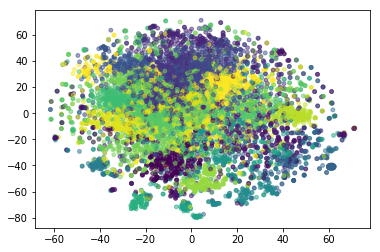

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
model_TSNE = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res_dsma["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model_TSNE.fit_transform(X_tsne)
 
plt.scatter(Y[:, 0], Y[:, 1], c=res_dsma["label"], s=15,alpha=.5)
 

#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
plt.show()

In [102]:
def calc_distance_to_groupCenter(group, topN, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    
    group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    
    print("------")
    print("Label:", group["label"].values[0], "(Number tweets: {})".format(group.shape[0]))
    print("------")
    for i, row in group.head(topN).iterrows():
        print(row["text"])
        print()   
    
    return(group)



def print_closest_tweets_to_groupCenter(data, topN, vectorColumn="text_vec"):

    print("================")
    print("Closest tweets:")
    print("================")
    data = data.groupby(by="label", as_index=False) \
              .apply(lambda data: calc_distance_to_groupCenter(data, topN,"text_vec")) \
              .reset_index(drop=True)
    return(data)

    
res1 = print_closest_tweets_to_groupCenter(res, 10, "text_vec")
res1.head()

#res_dsma1 = print_closest_tweets_to_groupCenter(res_dsma, 10, "text_vec")
#res_dsma1.head()

Closest tweets:
------
Label: 0 (Number tweets: 1513)
------
Q1: I have a really hard time being content. I'm in a good place right now w/ most things in life but still antsy for new adventures. #dsma

People often ask what a good night looks like for Hazel with diabetes and it really comes down to staying in range… https://t.co/RF0agUTHGd

@zisekaiase Thank you! a little nervous lol I'm going to dr. today&amp; get my blood work again for my diabetes I've been eating good food 👌🏼🤗🌹🌟

good morning i’m awake ONLY to give max his insulin however i am also wishing @tatehxppy a good day thank you for coming to my ted talk

Well they did say my legs are healing pretty good so that is a good sign now I need to see if I can get a primary doctor for my diabetes

@rgburns95 Oh good I'm glad it went well. Sorry you're still in pain. I have unfortunate news I am for sure Diabetic type 2 Hypoglasimic.

@mollyschreiber Good luck!! This is good to know about because I’m going through insulin like wat

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


------
Label: 7 (Number tweets: 2916)
------
Thanks CO for capping insulin costs I know too many people that suffer bc of the high prices of insulin you rock I love my state

I know the fear of people who take insulin. I am one of them. Even with insurance, insulin is expensive. We need so… https://t.co/evwjrK3XhO

Insulin manu. may be doing good donating insulin to PR but others there are still locked out b/c price. #Insulin4All https://t.co/tQbOYv98sD

@mdb2 My insulin is $1800. Utterly ridiculous! I can't afford mine either and so.etimes I have to go to an urgent care or ER for insulin.

@eugenegu Insulin is unaffordable unless you have good insurance. Type 1 diabetics die w/o insulin. Yet we hear ver… https://t.co/fQ8nNCKd5V

Cost of insulin is outrageous! This could be me in 10 years😥 if my son can’t afford #insulin. I’m sure there are th… https://t.co/Vq43r78qZh

You can't eat all the food you love without getting insulin, so if your body still makes it - help understand why Phar

------
Label: 18 (Number tweets: 1760)
------
people who feel the need to constantly one up you. like oh? you have depression? well i have anxiety, type 2 diabetes, and arthritis..

My birth mom's diabetic (even missing toes now), has gastroparesis, liver/heart issues, chronic pain, and more. Her meds alone are immense.

rheumatoid  arthritis type one diabetes  kidney disease all life sentences each day one is good but the others start flaring up tired

Anxiety, Depression, BPD, Diabetes and My Broken skin that causes me pain everywhere  I wouldn't be able to do this all without My Friends

Reduced libido, insulin resistance depression, anxiety, and a bunch of other health issues you can probably ask your doctor about

Makes me fucking sick that as a T1 diabetic w a mother who has breast cancer &amp; father w heart issues and severe arthritis we lost insurance

Enough that i can reverse it n not need meds or insulin shots. Still sucks tho. Ontop of this chronic pain I recent… https://t

------
Label: 29 (Number tweets: 3970)
------
Makes me sad to discard insulin at work when i know thee are type I diabetics who use expired insulin because they can't afford treatment😭

how much insulin they have in their body at any given time. It also makes it less awkward to take insulin for a mea… https://t.co/QEY0grfxeR

People say Type II diabetes is insulin resistance. I think it means your body doesn't produce enough insulin. Feel like I'm doomed if wrong

@LowBudgetWolf rip, i feel fine tho not like throwing up type sick yet so we will see if i dont lower, might need to change my insulin

Well, sure, but you'd eventually need $1000/month in insulin...even if you stopped eating the Ramen.  It's good, th… https://t.co/Gx37hh0Kv1

Can't stress enough how much I need an insulin pump. It would help greatly!! I hate carrying around my insulin.

I wonder if all those tRump voters that need insulin or have a loved one using insulin are still happy with their v… https://t.co/o9iPgnbeAw

,id,text,user_name,gender,typeDiabetes,text_vec,prep,label,cos_similarity_to_center
0,8.675502e+17,Q1: I have a really hard time being content. I...,Hannah,1,1,"[0.17556193, 0.15923001, 0.009927038, -0.17588...","[q1, really, hard, time, content, good, place,...",0,0.921351
1,9.997216e+17,People often ask what a good night looks like ...,mattlumpkin,2,1,"[0.20377772, 0.15592591, 0.02057297, -0.216310...","[people, often, ask, good, night, looks, like,...",0,0.920690
2,8.807711e+17,@zisekaiase Thank you! a little nervous lol I'...,Danna Luvs Yanni,1,0,"[0.19616403, 0.101651035, -0.007856799, -0.169...","[thank, little, nervous, lol, going, dr, today...",0,0.920587
3,1.109066e+18,good morning i’m awake ONLY to give max his in...,danielle🦎🚨,1,1,"[0.15946747, 0.16316384, 0.06140042, -0.252989...","[good, morning, awake, give, max, insulin, how...",0,0.920241
4,8.717470e+17,Well they did say my legs are healing pretty g...,Naskensethcar,1,0,"[0.112308726, 0.02403156, -0.08087771, -0.1505...","[well, say, legs, healing, pretty, good, good,...",0,0.918613


In [103]:
from collections import Counter
import operator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

topN = 10


analyzer = SentimentIntensityAnalyzer()


def global_term_frequency(data, textColumn):
    word_counter = {}
    for i, row in data.iterrows():
        for word in preprocess_tweet(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1    

    return word_counter

def topN_keywords(group, topN, textColumn, global_term_frequency_dict):

    
    N_group = group.shape[0]
    
    print("Calculate topWords for group {}..".format(group["label"].values[0]))
    word_counter = {}
    for i, row in group.iterrows():
        for word in preprocess_tweet(row[textColumn]):
            if word in word_counter: word_counter[word] += 1
            else: word_counter[word] = 1
         
    topKeywords = dict(sorted(word_counter.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str = ", ".join(str(e) for e in topKeywords.keys())

    #print("Calculate topWords inverse (N_group / N_global) for group {}..".format(group["label"].values[0]))
    word_counter_inv = {k: v / global_term_frequency_dict[k] for k, v in word_counter.items() if v > 100} # consider only words that occur often in a group, otherwise there is too much noise
    
    
    topKeywords_inv = dict(sorted(word_counter_inv.items(), key=operator.itemgetter(1), reverse=True)[:topN])
    topKeywords_str_inv = ", ".join(str(e) for e in topKeywords_inv.keys())

    # Take only closest tweet to center for one user to avoid that all tweets we put in the dataframe come from the same user
    grp_oneTweetPerUser = group.groupby(by="user_name", as_index=False).apply(lambda grp_user: grp_user.head(1))
    grp_oneTweetPerUser.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    text = ""
    for index, row in grp_oneTweetPerUser.head(10).iterrows():
        text += row["text"]+" (cos sim. to center: "+str("%.2f" % row["cos_similarity_to_center"])+")  #  .=.=.=. NEXT.=.=.=.     "

    # create percentages of Male, Female, Unknown in groups
    gender_count = group.gender.value_counts()
    if 0 not in gender_count.index: gender_count[0] = 0
    if 1 not in gender_count.index: gender_count[1] = 0
    if 2 not in gender_count.index: gender_count[2] = 0

    gender_freq_M = gender_count[0]
    gender_freq_F = gender_count[1]
    gender_freq_U = gender_count[2]
    
    gender_perc_M = "%.2f" % (gender_count[0] / N_group)
    gender_perc_F = "%.2f" % (gender_count[1] / N_group)
    gender_perc_U = "%.2f" % (gender_count[2] / N_group)


    # create percentages non diab, type 1 or type 2
    typeDiab_count = group.typeDiabetes.value_counts()
    if 0 not in typeDiab_count.index: typeDiab_count[0] = 0
    if 1 not in typeDiab_count.index: typeDiab_count[1] = 0
    if 2 not in typeDiab_count.index: typeDiab_count[2] = 0

    typeDiab_freq_noDiab = typeDiab_count[0]
    typeDiab_freq_type1 = typeDiab_count[1]
    typeDiab_freq_type2 = typeDiab_count[2]
    
    typeDiab_perc_noDiab = "%.2f" % (typeDiab_count[0] / N_group)
    typeDiab_perc_type1 = "%.2f" % (typeDiab_count[1] / N_group)
    typeDiab_perc_type2 = "%.2f" % (typeDiab_count[2] / N_group)


    # get sentiments
    sent = pd.DataFrame(columns=["pos", "neu", "neg", "compound_score"])
    for i, row in group.iterrows():
        vs = analyzer.polarity_scores(row["text"])
        sent.loc[i] = [vs["pos"], vs["neu"], vs["neg"], vs["compound"]]
        
#    print(type(sent), sent.shape)
#    print(sent.head())
    sent_mean = sent.mean()
#    print("mean:")
#    print(sent_mean)
#    print()
#    print("sent_mean.compound:", type(sent_mean.compound_score))
#    print(sent_mean.compound_score)
#    print("sent_mean.compound():", type(sent_mean.compound_score()))
#    print(sent_mean.compound_score())
    
#    print(type(sent_mean), sent_mean.shape)
#    print(sent_mean.head())    

    return pd.DataFrame({"Topic": [group["label"].values[0]], "Frequency": N_group,
                         "male_freq" : gender_freq_M, "female_freq":gender_freq_F, "unknown_freq": gender_freq_U,
                         "male_prop" : gender_perc_M, "female_prop":gender_perc_F, "unknown_prop": gender_perc_U,
                         "noDiab_freq" : typeDiab_freq_noDiab, "type1_freq":typeDiab_freq_type1, "type2_freq": typeDiab_freq_type2,
                         "noDiab_prop" : typeDiab_perc_noDiab, "type1_prop":typeDiab_perc_type1, "type2_prop": typeDiab_perc_type2,
                         "topWords" : topKeywords_str, "topWords_inverse":topKeywords_str_inv, 
                         "pos" : "%.2f" % (sent_mean.pos), "neu": "%.2f" % (sent_mean.neu),
                         "neg": "%.2f" % (sent_mean.neg), "compound": "%.2f" % (sent_mean.compound_score),
                         "SampleTexts" : text})
                
# General solution:
global_term_frequency_dict = global_term_frequency(res, "text")
print("N terms:", len(global_term_frequency_dict))

topKeywords = res1.groupby(by="label", as_index=False) \
              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
              .reset_index(drop=True)
topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.4f" % (freq/res.shape[0]))

# for dsma
#global_term_frequency_dict = global_term_frequency(res_dsma, "text")
#print("N terms:", len(global_term_frequency_dict))

#topKeywords = res_dsma1.groupby(by="label", as_index=False) \
#              .apply(lambda group: topN_keywords(group, topN, "text", global_term_frequency_dict)) \
#              .reset_index(drop=True)

topKeywords["compound"] = pd.to_numeric(topKeywords["compound"])


#topKeywords["Proportion"] = topKeywords["Frequency"].map(lambda freq: "%.4f" % (freq/res_dsma.shape[0]))
topKeywords = topKeywords[["Topic", "Frequency", "Proportion", "compound", "topWords", "SampleTexts",
                           "male_freq", "female_freq", "unknown_freq",
                          "male_prop", "female_prop", "unknown_prop",
                           "noDiab_freq", "type1_freq", "type2_freq",
                           "noDiab_prop", "type1_prop", "type2_prop",
                           "topWords_inverse", "pos", "neu", "neg"]]

topKeywords.sort_values("compound", ascending=False, inplace=True)


topKeywords.head()

N terms: 30386
Calculate topWords for group 0..
Calculate topWords for group 0..
Calculate topWords for group 1..
Calculate topWords for group 2..
Calculate topWords for group 3..
Calculate topWords for group 4..
Calculate topWords for group 5..
Calculate topWords for group 6..
Calculate topWords for group 7..
Calculate topWords for group 8..
Calculate topWords for group 9..
Calculate topWords for group 10..
Calculate topWords for group 11..
Calculate topWords for group 12..
Calculate topWords for group 13..
Calculate topWords for group 14..
Calculate topWords for group 15..
Calculate topWords for group 16..
Calculate topWords for group 17..
Calculate topWords for group 18..
Calculate topWords for group 19..
Calculate topWords for group 20..
Calculate topWords for group 21..
Calculate topWords for group 22..
Calculate topWords for group 23..
Calculate topWords for group 24..
Calculate topWords for group 25..
Calculate topWords for group 26..
Calculate topWords for group 27..
Calculate 

,Topic,Frequency,Proportion,compound,topWords,SampleTexts,male_freq,female_freq,unknown_freq,male_prop,...,noDiab_freq,type1_freq,type2_freq,noDiab_prop,type1_prop,type2_prop,topWords_inverse,pos,neu,neg
13,13,613,0.0132,0.68,"happy, birthday, day, #dsma, #t1d, insulin, to...",Happy birthday to my T1D brother🐐❤️🎁🎈🎉🎊🎂 @AC_...,166,267,180,0.27,...,215,377,21,0.35,0.62,0.03,"birthday, happy, day",0.36,0.61,0.03
9,9,1552,0.0334,0.67,"love, t1d, amazing, #t1d, awesome, thank, grea...",My amazing godson is 1 of these T1D warriors.H...,497,734,321,0.32,...,228,1236,88,0.15,0.80,0.06,"amazing, awesome, t1d, great, thank, thanks, e...",0.32,0.65,0.03
25,25,542,0.0117,0.54,"hope, well, #dsma, get, soon, better, one, goo...","@DiabetesSocMed 2019. Hope , always hope, for ...",200,201,141,0.37,...,238,229,75,0.44,0.42,0.14,hope,0.30,0.65,0.05
16,16,1499,0.0323,0.48,"help, love, please, us, one, let, awareness, n...",**ATTENTION** Please come out &amp; support T1...,443,651,405,0.30,...,584,829,86,0.39,0.55,0.06,"awareness, support, please, help, let, us, lov...",0.23,0.72,0.05
23,23,1459,0.0314,0.47,"#dsma, good, :), glad, tonight, evening, love,...",Good thanks... 18 degrees! RT @DiabetesSocMed:...,411,673,375,0.28,...,90,1345,24,0.06,0.92,0.02,"evening, #dsma, tonight, :), glad, good, hope,...",0.31,0.64,0.05


In [42]:
topKeywords.to_csv("Kmeans_K30_emot_SA_20190710.csv", sep=";")

(128, 30)


,13,9,25,16,23,0,15,24,12,2,...,29,17,1,5,7,22,28,3,19,18
0,0.000518,0.000431,0.000851,0.000500,0.000319,0.000561,0.000478,0.000768,0.000349,0.000994,...,0.000394,0.000397,0.000889,0.000263,0.000382,0.000284,0.000784,0.000603,0.000618,0.000651
1,0.000410,0.000340,0.000624,0.000332,0.000216,0.000465,0.000391,0.000797,0.000290,0.000862,...,0.000514,0.000517,0.001056,0.000430,0.000569,0.000441,0.001205,0.000934,0.000983,0.001119
2,0.000580,0.000624,0.000739,0.000332,0.000262,0.000522,0.000420,0.001031,0.000320,0.000905,...,0.000817,0.000803,0.001385,0.000752,0.000949,0.000751,0.001940,0.001537,0.001642,0.001954
3,0.000996,0.001302,0.001154,0.000463,0.000443,0.000729,0.000556,0.001496,0.000434,0.001118,...,0.001371,0.001317,0.001907,0.001314,0.001614,0.001290,0.003126,0.002541,0.002743,0.003361
4,0.001692,0.002509,0.001908,0.000729,0.000795,0.001111,0.000809,0.002249,0.000646,0.001518,...,0.002293,0.002163,0.002675,0.002247,0.002707,0.002180,0.004960,0.004137,0.004496,0.005644


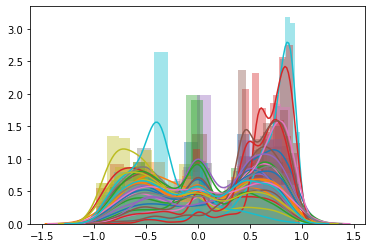

In [106]:
# Get Sentiment analysis distribution for each group
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

SA_pd = pd.DataFrame()
for i in range(0, 30):
    temp = res[res.label == i]
    scores = [analyzer.polarity_scores(row["text"])["compound"] for i, row in temp.iterrows()]
    ax = sns.distplot(scores)
    SA_pd[i] = ax.lines[i].get_ydata()
    

# sort by descending compound score 
SA_pd = SA_pd[topKeywords.Topic.values]

print(SA_pd.shape)
SA_pd.head()

In [107]:
SA_pd.to_csv("SA_scores_20190713.csv", sep=";")

In [8]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, metric="cosine")
np.set_printoptions(suppress=True)

X_tsne = np.asarray(res["text_vec"].values.tolist())
print(X_tsne.shape)
Y=model.fit_transform(X_tsne)
 


(164466, 200)


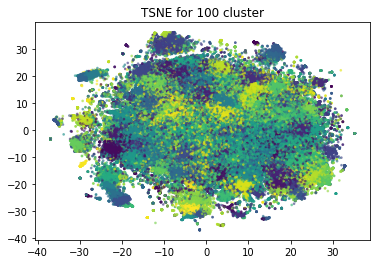

In [13]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], c=res["label"], s=3,alpha=.5)

plt.title("TSNE for {} cluster".format(Ncluster))
plt.savefig("TSNE_K_{}".format(Ncluster))
#for j in range(len(sentences)):    
#   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#   print ("%s %s" % (assigned_clusters[j],  sentences[j]))
  
#plt.show()

In [15]:
print(data.gender.value_counts())

print(data.typeDiabetes.value_counts())

1    65106
0    55311
2    44049
Name: gender, dtype: int64
0    106065
1     45830
2     12571
Name: typeDiabetes, dtype: int64


In [6]:
def get_groupCenter(group, vectorColumn="text_vec"):
    matrix_form = np.asarray(group[vectorColumn].values.tolist())
    groupCenter = np.sum(matrix_form,axis=0) / matrix_form.shape[0]
    
    #group["cos_similarity_to_center"] = group["text_vec"].map(lambda vec: cosinus_similarity(vec, groupCenter))
    #group.sort_values(by="cos_similarity_to_center", ascending=False, inplace=True)
    print(type(groupCenter), groupCenter.shape)
    return(groupCenter)


#res1 = print_closest_tweets_to_groupCenter(res, 10, "text_vec")
dataCenters = data.groupby(by="label", as_index=False) \
              .apply(lambda group: get_groupCenter(group, "text_vec")) \
              .reset_index(drop=True)

print(dataCenters.shape, type(dataCenters))

<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
<class 'numpy.ndarray'> (300,)
(30,) <class 'pandas.core.series.Series

In [8]:
dataCenters

0     [0.13855293692764103, 0.13595850271319418, -0....
1     [0.043591935, 0.06645612, -0.09868204, -0.3831...
2     [0.23676755, 0.09624102, 0.06024889, -0.199662...
3     [0.14705786, 0.09948742, -0.029506747, -0.1550...
4     [0.10828582, 0.044064917, -0.012017279, -0.089...
5     [0.15532823, 0.11708844, 0.0017906151, -0.1396...
6     [0.1721385, 0.08305559, 0.045637492, -0.138725...
7     [0.14337575, 0.07666129, 0.08839275, -0.129723...
8     [0.15655996, 0.02902552, -0.05481985, -0.08047...
9     [0.19859432, 0.10133278, 0.022214865, -0.15940...
10    [0.15638933, 0.07114629, 0.102302335, -0.13721...
11    [0.14813249, 0.05181104, 0.004935929, -0.13700...
12    [0.0137338145, 0.20343027, 0.084574625, -0.172...
13    [0.17554532, 0.0479544, 0.010594463, -0.214926...
14    [0.012386943, 0.10728507, 0.17796364, -0.16968...
15    [0.19507386, 0.07745905, 0.071611196, -0.17722...
16    [0.1798551, 0.12828805, 0.03304761, -0.1609999...
17    [0.12915373, 0.089425445, 0.103758164, -0.

In [14]:
cosine_sim_matrix = pd.DataFrame(columns=range(0,30))#columns=["c0", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9",
#                                         "c10", "c11", "c12", "c13", "c14", "c15", "c16", "c17", "c18", "c19",
#                                         "c20", "c21", "c22", "c23", "c24", "c25", "c26", "c27", "c28", "c29"])

for i, row in data.iterrows():
    for j, center in enumerate(dataCenters):
        #print("i:", i, " j:", j)
        cosine_sim_matrix.loc[i, j] = cosinus_similarity(row["text_vec"], center)

print(cosine_sim_matrix.shape)
print(cosine_sim_matrix.head())

i: 0  j: 0
i: 0  j: 1
i: 0  j: 2
i: 0  j: 3
i: 0  j: 4
i: 0  j: 5
i: 0  j: 6
i: 0  j: 7
i: 0  j: 8
i: 0  j: 9
i: 0  j: 10
i: 0  j: 11
i: 0  j: 12
i: 0  j: 13
i: 0  j: 14
i: 0  j: 15
i: 0  j: 16
i: 0  j: 17
i: 0  j: 18
i: 0  j: 19
i: 0  j: 20
i: 0  j: 21
i: 0  j: 22
i: 0  j: 23
i: 0  j: 24
i: 0  j: 25
i: 0  j: 26
i: 0  j: 27
i: 0  j: 28
i: 0  j: 29
i: 1  j: 0
i: 1  j: 1
i: 1  j: 2
i: 1  j: 3
i: 1  j: 4
i: 1  j: 5
i: 1  j: 6
i: 1  j: 7
i: 1  j: 8
i: 1  j: 9
i: 1  j: 10
i: 1  j: 11
i: 1  j: 12
i: 1  j: 13
i: 1  j: 14
i: 1  j: 15
i: 1  j: 16
i: 1  j: 17
i: 1  j: 18
i: 1  j: 19
i: 1  j: 20
i: 1  j: 21
i: 1  j: 22
i: 1  j: 23
i: 1  j: 24
i: 1  j: 25
i: 1  j: 26
i: 1  j: 27
i: 1  j: 28
i: 1  j: 29
i: 2  j: 0
i: 2  j: 1
i: 2  j: 2
i: 2  j: 3
i: 2  j: 4
i: 2  j: 5
i: 2  j: 6
i: 2  j: 7
i: 2  j: 8
i: 2  j: 9
i: 2  j: 10
i: 2  j: 11
i: 2  j: 12
i: 2  j: 13
i: 2  j: 14
i: 2  j: 15
i: 2  j: 16
i: 2  j: 17
i: 2  j: 18
i: 2  j: 19
i: 2  j: 20
i: 2  j: 21
i: 2  j: 22
i: 2  j: 23
i: 2  j: 24
i: 2  j: 2

i: 32  j: 19
i: 32  j: 20
i: 32  j: 21
i: 32  j: 22
i: 32  j: 23
i: 32  j: 24
i: 32  j: 25
i: 32  j: 26
i: 32  j: 27
i: 32  j: 28
i: 32  j: 29
i: 33  j: 0
i: 33  j: 1
i: 33  j: 2
i: 33  j: 3
i: 33  j: 4
i: 33  j: 5
i: 33  j: 6
i: 33  j: 7
i: 33  j: 8
i: 33  j: 9
i: 33  j: 10
i: 33  j: 11
i: 33  j: 12
i: 33  j: 13
i: 33  j: 14
i: 33  j: 15
i: 33  j: 16
i: 33  j: 17
i: 33  j: 18
i: 33  j: 19
i: 33  j: 20
i: 33  j: 21
i: 33  j: 22
i: 33  j: 23
i: 33  j: 24
i: 33  j: 25
i: 33  j: 26
i: 33  j: 27
i: 33  j: 28
i: 33  j: 29
i: 34  j: 0
i: 34  j: 1
i: 34  j: 2
i: 34  j: 3
i: 34  j: 4
i: 34  j: 5
i: 34  j: 6
i: 34  j: 7
i: 34  j: 8
i: 34  j: 9
i: 34  j: 10
i: 34  j: 11
i: 34  j: 12
i: 34  j: 13
i: 34  j: 14
i: 34  j: 15
i: 34  j: 16
i: 34  j: 17
i: 34  j: 18
i: 34  j: 19
i: 34  j: 20
i: 34  j: 21
i: 34  j: 22
i: 34  j: 23
i: 34  j: 24
i: 34  j: 25
i: 34  j: 26
i: 34  j: 27
i: 34  j: 28
i: 34  j: 29
i: 35  j: 0
i: 35  j: 1
i: 35  j: 2
i: 35  j: 3
i: 35  j: 4
i: 35  j: 5
i: 35  j: 6
i: 35  j: 7
i

i: 54  j: 14
i: 54  j: 15
i: 54  j: 16
i: 54  j: 17
i: 54  j: 18
i: 54  j: 19
i: 54  j: 20
i: 54  j: 21
i: 54  j: 22
i: 54  j: 23
i: 54  j: 24
i: 54  j: 25
i: 54  j: 26
i: 54  j: 27
i: 54  j: 28
i: 54  j: 29
i: 55  j: 0
i: 55  j: 1
i: 55  j: 2
i: 55  j: 3
i: 55  j: 4
i: 55  j: 5
i: 55  j: 6
i: 55  j: 7
i: 55  j: 8
i: 55  j: 9
i: 55  j: 10
i: 55  j: 11
i: 55  j: 12
i: 55  j: 13
i: 55  j: 14
i: 55  j: 15
i: 55  j: 16
i: 55  j: 17
i: 55  j: 18
i: 55  j: 19
i: 55  j: 20
i: 55  j: 21
i: 55  j: 22
i: 55  j: 23
i: 55  j: 24
i: 55  j: 25
i: 55  j: 26
i: 55  j: 27
i: 55  j: 28
i: 55  j: 29
i: 56  j: 0
i: 56  j: 1
i: 56  j: 2
i: 56  j: 3
i: 56  j: 4
i: 56  j: 5
i: 56  j: 6
i: 56  j: 7
i: 56  j: 8
i: 56  j: 9
i: 56  j: 10
i: 56  j: 11
i: 56  j: 12
i: 56  j: 13
i: 56  j: 14
i: 56  j: 15
i: 56  j: 16
i: 56  j: 17
i: 56  j: 18
i: 56  j: 19
i: 56  j: 20
i: 56  j: 21
i: 56  j: 22
i: 56  j: 23
i: 56  j: 24
i: 56  j: 25
i: 56  j: 26
i: 56  j: 27
i: 56  j: 28
i: 56  j: 29
i: 57  j: 0
i: 57  j: 1
i: 57  j

i: 84  j: 11
i: 84  j: 12
i: 84  j: 13
i: 84  j: 14
i: 84  j: 15
i: 84  j: 16
i: 84  j: 17
i: 84  j: 18
i: 84  j: 19
i: 84  j: 20
i: 84  j: 21
i: 84  j: 22
i: 84  j: 23
i: 84  j: 24
i: 84  j: 25
i: 84  j: 26
i: 84  j: 27
i: 84  j: 28
i: 84  j: 29
i: 85  j: 0
i: 85  j: 1
i: 85  j: 2
i: 85  j: 3
i: 85  j: 4
i: 85  j: 5
i: 85  j: 6
i: 85  j: 7
i: 85  j: 8
i: 85  j: 9
i: 85  j: 10
i: 85  j: 11
i: 85  j: 12
i: 85  j: 13
i: 85  j: 14
i: 85  j: 15
i: 85  j: 16
i: 85  j: 17
i: 85  j: 18
i: 85  j: 19
i: 85  j: 20
i: 85  j: 21
i: 85  j: 22
i: 85  j: 23
i: 85  j: 24
i: 85  j: 25
i: 85  j: 26
i: 85  j: 27
i: 85  j: 28
i: 85  j: 29
i: 86  j: 0
i: 86  j: 1
i: 86  j: 2
i: 86  j: 3
i: 86  j: 4
i: 86  j: 5
i: 86  j: 6
i: 86  j: 7
i: 86  j: 8
i: 86  j: 9
i: 86  j: 10
i: 86  j: 11
i: 86  j: 12
i: 86  j: 13
i: 86  j: 14
i: 86  j: 15
i: 86  j: 16
i: 86  j: 17
i: 86  j: 18
i: 86  j: 19
i: 86  j: 20
i: 86  j: 21
i: 86  j: 22
i: 86  j: 23
i: 86  j: 24
i: 86  j: 25
i: 86  j: 26
i: 86  j: 27
i: 86  j: 28
i: 86 

i: 111  j: 27
i: 111  j: 28
i: 111  j: 29
i: 112  j: 0
i: 112  j: 1
i: 112  j: 2
i: 112  j: 3
i: 112  j: 4
i: 112  j: 5
i: 112  j: 6
i: 112  j: 7
i: 112  j: 8
i: 112  j: 9
i: 112  j: 10
i: 112  j: 11
i: 112  j: 12
i: 112  j: 13
i: 112  j: 14
i: 112  j: 15
i: 112  j: 16
i: 112  j: 17
i: 112  j: 18
i: 112  j: 19
i: 112  j: 20
i: 112  j: 21
i: 112  j: 22
i: 112  j: 23
i: 112  j: 24
i: 112  j: 25
i: 112  j: 26
i: 112  j: 27
i: 112  j: 28
i: 112  j: 29
i: 113  j: 0
i: 113  j: 1
i: 113  j: 2
i: 113  j: 3
i: 113  j: 4
i: 113  j: 5
i: 113  j: 6
i: 113  j: 7
i: 113  j: 8
i: 113  j: 9
i: 113  j: 10
i: 113  j: 11
i: 113  j: 12
i: 113  j: 13
i: 113  j: 14
i: 113  j: 15
i: 113  j: 16
i: 113  j: 17
i: 113  j: 18
i: 113  j: 19
i: 113  j: 20
i: 113  j: 21
i: 113  j: 22
i: 113  j: 23
i: 113  j: 24
i: 113  j: 25
i: 113  j: 26
i: 113  j: 27
i: 113  j: 28
i: 113  j: 29
i: 114  j: 0
i: 114  j: 1
i: 114  j: 2
i: 114  j: 3
i: 114  j: 4
i: 114  j: 5
i: 114  j: 6
i: 114  j: 7
i: 114  j: 8
i: 114  j: 9
i: 114  

i: 139  j: 12
i: 139  j: 13
i: 139  j: 14
i: 139  j: 15
i: 139  j: 16
i: 139  j: 17
i: 139  j: 18
i: 139  j: 19
i: 139  j: 20
i: 139  j: 21
i: 139  j: 22
i: 139  j: 23
i: 139  j: 24
i: 139  j: 25
i: 139  j: 26
i: 139  j: 27
i: 139  j: 28
i: 139  j: 29
i: 140  j: 0
i: 140  j: 1
i: 140  j: 2
i: 140  j: 3
i: 140  j: 4
i: 140  j: 5
i: 140  j: 6
i: 140  j: 7
i: 140  j: 8
i: 140  j: 9
i: 140  j: 10
i: 140  j: 11
i: 140  j: 12
i: 140  j: 13
i: 140  j: 14
i: 140  j: 15
i: 140  j: 16
i: 140  j: 17
i: 140  j: 18
i: 140  j: 19
i: 140  j: 20
i: 140  j: 21
i: 140  j: 22
i: 140  j: 23
i: 140  j: 24
i: 140  j: 25
i: 140  j: 26
i: 140  j: 27
i: 140  j: 28
i: 140  j: 29
i: 141  j: 0
i: 141  j: 1
i: 141  j: 2
i: 141  j: 3
i: 141  j: 4
i: 141  j: 5
i: 141  j: 6
i: 141  j: 7
i: 141  j: 8
i: 141  j: 9
i: 141  j: 10
i: 141  j: 11
i: 141  j: 12
i: 141  j: 13
i: 141  j: 14
i: 141  j: 15
i: 141  j: 16
i: 141  j: 17
i: 141  j: 18
i: 141  j: 19
i: 141  j: 20
i: 141  j: 21
i: 141  j: 22
i: 141  j: 23
i: 141  j: 2

i: 163  j: 7
i: 163  j: 8
i: 163  j: 9
i: 163  j: 10
i: 163  j: 11
i: 163  j: 12
i: 163  j: 13
i: 163  j: 14
i: 163  j: 15
i: 163  j: 16
i: 163  j: 17
i: 163  j: 18
i: 163  j: 19
i: 163  j: 20
i: 163  j: 21
i: 163  j: 22
i: 163  j: 23
i: 163  j: 24
i: 163  j: 25
i: 163  j: 26
i: 163  j: 27
i: 163  j: 28
i: 163  j: 29
i: 164  j: 0
i: 164  j: 1
i: 164  j: 2
i: 164  j: 3
i: 164  j: 4
i: 164  j: 5
i: 164  j: 6
i: 164  j: 7
i: 164  j: 8
i: 164  j: 9
i: 164  j: 10
i: 164  j: 11
i: 164  j: 12
i: 164  j: 13
i: 164  j: 14
i: 164  j: 15
i: 164  j: 16
i: 164  j: 17
i: 164  j: 18
i: 164  j: 19
i: 164  j: 20
i: 164  j: 21
i: 164  j: 22
i: 164  j: 23
i: 164  j: 24
i: 164  j: 25
i: 164  j: 26
i: 164  j: 27
i: 164  j: 28
i: 164  j: 29
i: 165  j: 0
i: 165  j: 1
i: 165  j: 2
i: 165  j: 3
i: 165  j: 4
i: 165  j: 5
i: 165  j: 6
i: 165  j: 7
i: 165  j: 8
i: 165  j: 9
i: 165  j: 10
i: 165  j: 11
i: 165  j: 12
i: 165  j: 13
i: 165  j: 14
i: 165  j: 15
i: 165  j: 16
i: 165  j: 17
i: 165  j: 18
i: 165  j: 19
i

i: 186  j: 7
i: 186  j: 8
i: 186  j: 9
i: 186  j: 10
i: 186  j: 11
i: 186  j: 12
i: 186  j: 13
i: 186  j: 14
i: 186  j: 15
i: 186  j: 16
i: 186  j: 17
i: 186  j: 18
i: 186  j: 19
i: 186  j: 20
i: 186  j: 21
i: 186  j: 22
i: 186  j: 23
i: 186  j: 24
i: 186  j: 25
i: 186  j: 26
i: 186  j: 27
i: 186  j: 28
i: 186  j: 29
i: 187  j: 0
i: 187  j: 1
i: 187  j: 2
i: 187  j: 3
i: 187  j: 4
i: 187  j: 5
i: 187  j: 6
i: 187  j: 7
i: 187  j: 8
i: 187  j: 9
i: 187  j: 10
i: 187  j: 11
i: 187  j: 12
i: 187  j: 13
i: 187  j: 14
i: 187  j: 15
i: 187  j: 16
i: 187  j: 17
i: 187  j: 18
i: 187  j: 19
i: 187  j: 20
i: 187  j: 21
i: 187  j: 22
i: 187  j: 23
i: 187  j: 24
i: 187  j: 25
i: 187  j: 26
i: 187  j: 27
i: 187  j: 28
i: 187  j: 29
i: 188  j: 0
i: 188  j: 1
i: 188  j: 2
i: 188  j: 3
i: 188  j: 4
i: 188  j: 5
i: 188  j: 6
i: 188  j: 7
i: 188  j: 8
i: 188  j: 9
i: 188  j: 10
i: 188  j: 11
i: 188  j: 12
i: 188  j: 13
i: 188  j: 14
i: 188  j: 15
i: 188  j: 16
i: 188  j: 17
i: 188  j: 18
i: 188  j: 19
i

i: 209  j: 3
i: 209  j: 4
i: 209  j: 5
i: 209  j: 6
i: 209  j: 7
i: 209  j: 8
i: 209  j: 9
i: 209  j: 10
i: 209  j: 11
i: 209  j: 12
i: 209  j: 13
i: 209  j: 14
i: 209  j: 15
i: 209  j: 16
i: 209  j: 17
i: 209  j: 18
i: 209  j: 19
i: 209  j: 20
i: 209  j: 21
i: 209  j: 22
i: 209  j: 23
i: 209  j: 24
i: 209  j: 25
i: 209  j: 26
i: 209  j: 27
i: 209  j: 28
i: 209  j: 29
i: 210  j: 0
i: 210  j: 1
i: 210  j: 2
i: 210  j: 3
i: 210  j: 4
i: 210  j: 5
i: 210  j: 6
i: 210  j: 7
i: 210  j: 8
i: 210  j: 9
i: 210  j: 10
i: 210  j: 11
i: 210  j: 12
i: 210  j: 13
i: 210  j: 14
i: 210  j: 15
i: 210  j: 16
i: 210  j: 17
i: 210  j: 18
i: 210  j: 19
i: 210  j: 20
i: 210  j: 21
i: 210  j: 22
i: 210  j: 23
i: 210  j: 24
i: 210  j: 25
i: 210  j: 26
i: 210  j: 27
i: 210  j: 28
i: 210  j: 29
i: 211  j: 0
i: 211  j: 1
i: 211  j: 2
i: 211  j: 3
i: 211  j: 4
i: 211  j: 5
i: 211  j: 6
i: 211  j: 7
i: 211  j: 8
i: 211  j: 9
i: 211  j: 10
i: 211  j: 11
i: 211  j: 12
i: 211  j: 13
i: 211  j: 14
i: 211  j: 15
i: 21

i: 231  j: 3
i: 231  j: 4
i: 231  j: 5
i: 231  j: 6
i: 231  j: 7
i: 231  j: 8
i: 231  j: 9
i: 231  j: 10
i: 231  j: 11
i: 231  j: 12
i: 231  j: 13
i: 231  j: 14
i: 231  j: 15
i: 231  j: 16
i: 231  j: 17
i: 231  j: 18
i: 231  j: 19
i: 231  j: 20
i: 231  j: 21
i: 231  j: 22
i: 231  j: 23
i: 231  j: 24
i: 231  j: 25
i: 231  j: 26
i: 231  j: 27
i: 231  j: 28
i: 231  j: 29
i: 232  j: 0
i: 232  j: 1
i: 232  j: 2
i: 232  j: 3
i: 232  j: 4
i: 232  j: 5
i: 232  j: 6
i: 232  j: 7
i: 232  j: 8
i: 232  j: 9
i: 232  j: 10
i: 232  j: 11
i: 232  j: 12
i: 232  j: 13
i: 232  j: 14
i: 232  j: 15
i: 232  j: 16
i: 232  j: 17
i: 232  j: 18
i: 232  j: 19
i: 232  j: 20
i: 232  j: 21
i: 232  j: 22
i: 232  j: 23
i: 232  j: 24
i: 232  j: 25
i: 232  j: 26
i: 232  j: 27
i: 232  j: 28
i: 232  j: 29
i: 233  j: 0
i: 233  j: 1
i: 233  j: 2
i: 233  j: 3
i: 233  j: 4
i: 233  j: 5
i: 233  j: 6
i: 233  j: 7
i: 233  j: 8
i: 233  j: 9
i: 233  j: 10
i: 233  j: 11
i: 233  j: 12
i: 233  j: 13
i: 233  j: 14
i: 233  j: 15
i: 23

i: 253  j: 23
i: 253  j: 24
i: 253  j: 25
i: 253  j: 26
i: 253  j: 27
i: 253  j: 28
i: 253  j: 29
i: 254  j: 0
i: 254  j: 1
i: 254  j: 2
i: 254  j: 3
i: 254  j: 4
i: 254  j: 5
i: 254  j: 6
i: 254  j: 7
i: 254  j: 8
i: 254  j: 9
i: 254  j: 10
i: 254  j: 11
i: 254  j: 12
i: 254  j: 13
i: 254  j: 14
i: 254  j: 15
i: 254  j: 16
i: 254  j: 17
i: 254  j: 18
i: 254  j: 19
i: 254  j: 20
i: 254  j: 21
i: 254  j: 22
i: 254  j: 23
i: 254  j: 24
i: 254  j: 25
i: 254  j: 26
i: 254  j: 27
i: 254  j: 28
i: 254  j: 29
i: 255  j: 0
i: 255  j: 1
i: 255  j: 2
i: 255  j: 3
i: 255  j: 4
i: 255  j: 5
i: 255  j: 6
i: 255  j: 7
i: 255  j: 8
i: 255  j: 9
i: 255  j: 10
i: 255  j: 11
i: 255  j: 12
i: 255  j: 13
i: 255  j: 14
i: 255  j: 15
i: 255  j: 16
i: 255  j: 17
i: 255  j: 18
i: 255  j: 19
i: 255  j: 20
i: 255  j: 21
i: 255  j: 22
i: 255  j: 23
i: 255  j: 24
i: 255  j: 25
i: 255  j: 26
i: 255  j: 27
i: 255  j: 28
i: 255  j: 29
i: 256  j: 0
i: 256  j: 1
i: 256  j: 2
i: 256  j: 3
i: 256  j: 4
i: 256  j: 5
i: 2

i: 276  j: 1
i: 276  j: 2
i: 276  j: 3
i: 276  j: 4
i: 276  j: 5
i: 276  j: 6
i: 276  j: 7
i: 276  j: 8
i: 276  j: 9
i: 276  j: 10
i: 276  j: 11
i: 276  j: 12
i: 276  j: 13
i: 276  j: 14
i: 276  j: 15
i: 276  j: 16
i: 276  j: 17
i: 276  j: 18
i: 276  j: 19
i: 276  j: 20
i: 276  j: 21
i: 276  j: 22
i: 276  j: 23
i: 276  j: 24
i: 276  j: 25
i: 276  j: 26
i: 276  j: 27
i: 276  j: 28
i: 276  j: 29
i: 277  j: 0
i: 277  j: 1
i: 277  j: 2
i: 277  j: 3
i: 277  j: 4
i: 277  j: 5
i: 277  j: 6
i: 277  j: 7
i: 277  j: 8
i: 277  j: 9
i: 277  j: 10
i: 277  j: 11
i: 277  j: 12
i: 277  j: 13
i: 277  j: 14
i: 277  j: 15
i: 277  j: 16
i: 277  j: 17
i: 277  j: 18
i: 277  j: 19
i: 277  j: 20
i: 277  j: 21
i: 277  j: 22
i: 277  j: 23
i: 277  j: 24
i: 277  j: 25
i: 277  j: 26
i: 277  j: 27
i: 277  j: 28
i: 277  j: 29
i: 278  j: 0
i: 278  j: 1
i: 278  j: 2
i: 278  j: 3
i: 278  j: 4
i: 278  j: 5
i: 278  j: 6
i: 278  j: 7
i: 278  j: 8
i: 278  j: 9
i: 278  j: 10
i: 278  j: 11
i: 278  j: 12
i: 278  j: 13
i: 278 

i: 298  j: 6
i: 298  j: 7
i: 298  j: 8
i: 298  j: 9
i: 298  j: 10
i: 298  j: 11
i: 298  j: 12
i: 298  j: 13
i: 298  j: 14
i: 298  j: 15
i: 298  j: 16
i: 298  j: 17
i: 298  j: 18
i: 298  j: 19
i: 298  j: 20
i: 298  j: 21
i: 298  j: 22
i: 298  j: 23
i: 298  j: 24
i: 298  j: 25
i: 298  j: 26
i: 298  j: 27
i: 298  j: 28
i: 298  j: 29
i: 299  j: 0
i: 299  j: 1
i: 299  j: 2
i: 299  j: 3
i: 299  j: 4
i: 299  j: 5
i: 299  j: 6
i: 299  j: 7
i: 299  j: 8
i: 299  j: 9
i: 299  j: 10
i: 299  j: 11
i: 299  j: 12
i: 299  j: 13
i: 299  j: 14
i: 299  j: 15
i: 299  j: 16
i: 299  j: 17
i: 299  j: 18
i: 299  j: 19
i: 299  j: 20
i: 299  j: 21
i: 299  j: 22
i: 299  j: 23
i: 299  j: 24
i: 299  j: 25
i: 299  j: 26
i: 299  j: 27
i: 299  j: 28
i: 299  j: 29
i: 300  j: 0
i: 300  j: 1
i: 300  j: 2
i: 300  j: 3
i: 300  j: 4
i: 300  j: 5
i: 300  j: 6
i: 300  j: 7
i: 300  j: 8
i: 300  j: 9
i: 300  j: 10
i: 300  j: 11
i: 300  j: 12
i: 300  j: 13
i: 300  j: 14
i: 300  j: 15
i: 300  j: 16
i: 300  j: 17
i: 300  j: 18
i:

i: 322  j: 12
i: 322  j: 13
i: 322  j: 14
i: 322  j: 15
i: 322  j: 16
i: 322  j: 17
i: 322  j: 18
i: 322  j: 19
i: 322  j: 20
i: 322  j: 21
i: 322  j: 22
i: 322  j: 23
i: 322  j: 24
i: 322  j: 25
i: 322  j: 26
i: 322  j: 27
i: 322  j: 28
i: 322  j: 29
i: 323  j: 0
i: 323  j: 1
i: 323  j: 2
i: 323  j: 3
i: 323  j: 4
i: 323  j: 5
i: 323  j: 6
i: 323  j: 7
i: 323  j: 8
i: 323  j: 9
i: 323  j: 10
i: 323  j: 11
i: 323  j: 12
i: 323  j: 13
i: 323  j: 14
i: 323  j: 15
i: 323  j: 16
i: 323  j: 17
i: 323  j: 18
i: 323  j: 19
i: 323  j: 20
i: 323  j: 21
i: 323  j: 22
i: 323  j: 23
i: 323  j: 24
i: 323  j: 25
i: 323  j: 26
i: 323  j: 27
i: 323  j: 28
i: 323  j: 29
i: 324  j: 0
i: 324  j: 1
i: 324  j: 2
i: 324  j: 3
i: 324  j: 4
i: 324  j: 5
i: 324  j: 6
i: 324  j: 7
i: 324  j: 8
i: 324  j: 9
i: 324  j: 10
i: 324  j: 11
i: 324  j: 12
i: 324  j: 13
i: 324  j: 14
i: 324  j: 15
i: 324  j: 16
i: 324  j: 17
i: 324  j: 18
i: 324  j: 19
i: 324  j: 20
i: 324  j: 21
i: 324  j: 22
i: 324  j: 23
i: 324  j: 2

i: 348  j: 7
i: 348  j: 8
i: 348  j: 9
i: 348  j: 10
i: 348  j: 11
i: 348  j: 12
i: 348  j: 13
i: 348  j: 14
i: 348  j: 15
i: 348  j: 16
i: 348  j: 17
i: 348  j: 18
i: 348  j: 19
i: 348  j: 20
i: 348  j: 21
i: 348  j: 22
i: 348  j: 23
i: 348  j: 24
i: 348  j: 25
i: 348  j: 26
i: 348  j: 27
i: 348  j: 28
i: 348  j: 29
i: 349  j: 0
i: 349  j: 1
i: 349  j: 2
i: 349  j: 3
i: 349  j: 4
i: 349  j: 5
i: 349  j: 6
i: 349  j: 7
i: 349  j: 8
i: 349  j: 9
i: 349  j: 10
i: 349  j: 11
i: 349  j: 12
i: 349  j: 13
i: 349  j: 14
i: 349  j: 15
i: 349  j: 16
i: 349  j: 17
i: 349  j: 18
i: 349  j: 19
i: 349  j: 20
i: 349  j: 21
i: 349  j: 22
i: 349  j: 23
i: 349  j: 24
i: 349  j: 25
i: 349  j: 26
i: 349  j: 27
i: 349  j: 28
i: 349  j: 29
i: 350  j: 0
i: 350  j: 1
i: 350  j: 2
i: 350  j: 3
i: 350  j: 4
i: 350  j: 5
i: 350  j: 6
i: 350  j: 7
i: 350  j: 8
i: 350  j: 9
i: 350  j: 10
i: 350  j: 11
i: 350  j: 12
i: 350  j: 13
i: 350  j: 14
i: 350  j: 15
i: 350  j: 16
i: 350  j: 17
i: 350  j: 18
i: 350  j: 19
i

i: 369  j: 16
i: 369  j: 17
i: 369  j: 18
i: 369  j: 19
i: 369  j: 20
i: 369  j: 21
i: 369  j: 22
i: 369  j: 23
i: 369  j: 24
i: 369  j: 25
i: 369  j: 26
i: 369  j: 27
i: 369  j: 28
i: 369  j: 29
i: 370  j: 0
i: 370  j: 1
i: 370  j: 2
i: 370  j: 3
i: 370  j: 4
i: 370  j: 5
i: 370  j: 6
i: 370  j: 7
i: 370  j: 8
i: 370  j: 9
i: 370  j: 10
i: 370  j: 11
i: 370  j: 12
i: 370  j: 13
i: 370  j: 14
i: 370  j: 15
i: 370  j: 16
i: 370  j: 17
i: 370  j: 18
i: 370  j: 19
i: 370  j: 20
i: 370  j: 21
i: 370  j: 22
i: 370  j: 23
i: 370  j: 24
i: 370  j: 25
i: 370  j: 26
i: 370  j: 27
i: 370  j: 28
i: 370  j: 29
i: 371  j: 0
i: 371  j: 1
i: 371  j: 2
i: 371  j: 3
i: 371  j: 4
i: 371  j: 5
i: 371  j: 6
i: 371  j: 7
i: 371  j: 8
i: 371  j: 9
i: 371  j: 10
i: 371  j: 11
i: 371  j: 12
i: 371  j: 13
i: 371  j: 14
i: 371  j: 15
i: 371  j: 16
i: 371  j: 17
i: 371  j: 18
i: 371  j: 19
i: 371  j: 20
i: 371  j: 21
i: 371  j: 22
i: 371  j: 23
i: 371  j: 24
i: 371  j: 25
i: 371  j: 26
i: 371  j: 27
i: 371  j: 2

i: 390  j: 11
i: 390  j: 12
i: 390  j: 13
i: 390  j: 14
i: 390  j: 15
i: 390  j: 16
i: 390  j: 17
i: 390  j: 18
i: 390  j: 19
i: 390  j: 20
i: 390  j: 21
i: 390  j: 22
i: 390  j: 23
i: 390  j: 24
i: 390  j: 25
i: 390  j: 26
i: 390  j: 27
i: 390  j: 28
i: 390  j: 29
i: 391  j: 0
i: 391  j: 1
i: 391  j: 2
i: 391  j: 3
i: 391  j: 4
i: 391  j: 5
i: 391  j: 6
i: 391  j: 7
i: 391  j: 8
i: 391  j: 9
i: 391  j: 10
i: 391  j: 11
i: 391  j: 12
i: 391  j: 13
i: 391  j: 14
i: 391  j: 15
i: 391  j: 16
i: 391  j: 17
i: 391  j: 18
i: 391  j: 19
i: 391  j: 20
i: 391  j: 21
i: 391  j: 22
i: 391  j: 23
i: 391  j: 24
i: 391  j: 25
i: 391  j: 26
i: 391  j: 27
i: 391  j: 28
i: 391  j: 29
i: 392  j: 0
i: 392  j: 1
i: 392  j: 2
i: 392  j: 3
i: 392  j: 4
i: 392  j: 5
i: 392  j: 6
i: 392  j: 7
i: 392  j: 8
i: 392  j: 9
i: 392  j: 10
i: 392  j: 11
i: 392  j: 12
i: 392  j: 13
i: 392  j: 14
i: 392  j: 15
i: 392  j: 16
i: 392  j: 17
i: 392  j: 18
i: 392  j: 19
i: 392  j: 20
i: 392  j: 21
i: 392  j: 22
i: 392  j: 2

i: 417  j: 6
i: 417  j: 7
i: 417  j: 8
i: 417  j: 9
i: 417  j: 10
i: 417  j: 11
i: 417  j: 12
i: 417  j: 13
i: 417  j: 14
i: 417  j: 15
i: 417  j: 16
i: 417  j: 17
i: 417  j: 18
i: 417  j: 19
i: 417  j: 20
i: 417  j: 21
i: 417  j: 22
i: 417  j: 23
i: 417  j: 24
i: 417  j: 25
i: 417  j: 26
i: 417  j: 27
i: 417  j: 28
i: 417  j: 29
i: 418  j: 0
i: 418  j: 1
i: 418  j: 2
i: 418  j: 3
i: 418  j: 4
i: 418  j: 5
i: 418  j: 6
i: 418  j: 7
i: 418  j: 8
i: 418  j: 9
i: 418  j: 10
i: 418  j: 11
i: 418  j: 12
i: 418  j: 13
i: 418  j: 14
i: 418  j: 15
i: 418  j: 16
i: 418  j: 17
i: 418  j: 18
i: 418  j: 19
i: 418  j: 20
i: 418  j: 21
i: 418  j: 22
i: 418  j: 23
i: 418  j: 24
i: 418  j: 25
i: 418  j: 26
i: 418  j: 27
i: 418  j: 28
i: 418  j: 29
i: 419  j: 0
i: 419  j: 1
i: 419  j: 2
i: 419  j: 3
i: 419  j: 4
i: 419  j: 5
i: 419  j: 6
i: 419  j: 7
i: 419  j: 8
i: 419  j: 9
i: 419  j: 10
i: 419  j: 11
i: 419  j: 12
i: 419  j: 13
i: 419  j: 14
i: 419  j: 15
i: 419  j: 16
i: 419  j: 17
i: 419  j: 18
i:

i: 442  j: 24
i: 442  j: 25
i: 442  j: 26
i: 442  j: 27
i: 442  j: 28
i: 442  j: 29
i: 443  j: 0
i: 443  j: 1
i: 443  j: 2
i: 443  j: 3
i: 443  j: 4
i: 443  j: 5
i: 443  j: 6
i: 443  j: 7
i: 443  j: 8
i: 443  j: 9
i: 443  j: 10
i: 443  j: 11
i: 443  j: 12
i: 443  j: 13
i: 443  j: 14
i: 443  j: 15
i: 443  j: 16
i: 443  j: 17
i: 443  j: 18
i: 443  j: 19
i: 443  j: 20
i: 443  j: 21
i: 443  j: 22
i: 443  j: 23
i: 443  j: 24
i: 443  j: 25
i: 443  j: 26
i: 443  j: 27
i: 443  j: 28
i: 443  j: 29
i: 444  j: 0
i: 444  j: 1
i: 444  j: 2
i: 444  j: 3
i: 444  j: 4
i: 444  j: 5
i: 444  j: 6
i: 444  j: 7
i: 444  j: 8
i: 444  j: 9
i: 444  j: 10
i: 444  j: 11
i: 444  j: 12
i: 444  j: 13
i: 444  j: 14
i: 444  j: 15
i: 444  j: 16
i: 444  j: 17
i: 444  j: 18
i: 444  j: 19
i: 444  j: 20
i: 444  j: 21
i: 444  j: 22
i: 444  j: 23
i: 444  j: 24
i: 444  j: 25
i: 444  j: 26
i: 444  j: 27
i: 444  j: 28
i: 444  j: 29
i: 445  j: 0
i: 445  j: 1
i: 445  j: 2
i: 445  j: 3
i: 445  j: 4
i: 445  j: 5
i: 445  j: 6
i: 44

i: 463  j: 1
i: 463  j: 2
i: 463  j: 3
i: 463  j: 4
i: 463  j: 5
i: 463  j: 6
i: 463  j: 7
i: 463  j: 8
i: 463  j: 9
i: 463  j: 10
i: 463  j: 11
i: 463  j: 12
i: 463  j: 13
i: 463  j: 14
i: 463  j: 15
i: 463  j: 16
i: 463  j: 17
i: 463  j: 18
i: 463  j: 19
i: 463  j: 20
i: 463  j: 21
i: 463  j: 22
i: 463  j: 23
i: 463  j: 24
i: 463  j: 25
i: 463  j: 26
i: 463  j: 27
i: 463  j: 28
i: 463  j: 29
i: 464  j: 0
i: 464  j: 1
i: 464  j: 2
i: 464  j: 3
i: 464  j: 4
i: 464  j: 5
i: 464  j: 6
i: 464  j: 7
i: 464  j: 8
i: 464  j: 9
i: 464  j: 10
i: 464  j: 11
i: 464  j: 12
i: 464  j: 13
i: 464  j: 14
i: 464  j: 15
i: 464  j: 16
i: 464  j: 17
i: 464  j: 18
i: 464  j: 19
i: 464  j: 20
i: 464  j: 21
i: 464  j: 22
i: 464  j: 23
i: 464  j: 24
i: 464  j: 25
i: 464  j: 26
i: 464  j: 27
i: 464  j: 28
i: 464  j: 29
i: 465  j: 0
i: 465  j: 1
i: 465  j: 2
i: 465  j: 3
i: 465  j: 4
i: 465  j: 5
i: 465  j: 6
i: 465  j: 7
i: 465  j: 8
i: 465  j: 9
i: 465  j: 10
i: 465  j: 11
i: 465  j: 12
i: 465  j: 13
i: 465 

i: 488  j: 13
i: 488  j: 14
i: 488  j: 15
i: 488  j: 16
i: 488  j: 17
i: 488  j: 18
i: 488  j: 19
i: 488  j: 20
i: 488  j: 21
i: 488  j: 22
i: 488  j: 23
i: 488  j: 24
i: 488  j: 25
i: 488  j: 26
i: 488  j: 27
i: 488  j: 28
i: 488  j: 29
i: 489  j: 0
i: 489  j: 1
i: 489  j: 2
i: 489  j: 3
i: 489  j: 4
i: 489  j: 5
i: 489  j: 6
i: 489  j: 7
i: 489  j: 8
i: 489  j: 9
i: 489  j: 10
i: 489  j: 11
i: 489  j: 12
i: 489  j: 13
i: 489  j: 14
i: 489  j: 15
i: 489  j: 16
i: 489  j: 17
i: 489  j: 18
i: 489  j: 19
i: 489  j: 20
i: 489  j: 21
i: 489  j: 22
i: 489  j: 23
i: 489  j: 24
i: 489  j: 25
i: 489  j: 26
i: 489  j: 27
i: 489  j: 28
i: 489  j: 29
i: 490  j: 0
i: 490  j: 1
i: 490  j: 2
i: 490  j: 3
i: 490  j: 4
i: 490  j: 5
i: 490  j: 6
i: 490  j: 7
i: 490  j: 8
i: 490  j: 9
i: 490  j: 10
i: 490  j: 11
i: 490  j: 12
i: 490  j: 13
i: 490  j: 14
i: 490  j: 15
i: 490  j: 16
i: 490  j: 17
i: 490  j: 18
i: 490  j: 19
i: 490  j: 20
i: 490  j: 21
i: 490  j: 22
i: 490  j: 23
i: 490  j: 24
i: 490  j: 2

i: 513  j: 3
i: 513  j: 4
i: 513  j: 5
i: 513  j: 6
i: 513  j: 7
i: 513  j: 8
i: 513  j: 9
i: 513  j: 10
i: 513  j: 11
i: 513  j: 12
i: 513  j: 13
i: 513  j: 14
i: 513  j: 15
i: 513  j: 16
i: 513  j: 17
i: 513  j: 18
i: 513  j: 19
i: 513  j: 20
i: 513  j: 21
i: 513  j: 22
i: 513  j: 23
i: 513  j: 24
i: 513  j: 25
i: 513  j: 26
i: 513  j: 27
i: 513  j: 28
i: 513  j: 29
i: 514  j: 0
i: 514  j: 1
i: 514  j: 2
i: 514  j: 3
i: 514  j: 4
i: 514  j: 5
i: 514  j: 6
i: 514  j: 7
i: 514  j: 8
i: 514  j: 9
i: 514  j: 10
i: 514  j: 11
i: 514  j: 12
i: 514  j: 13
i: 514  j: 14
i: 514  j: 15
i: 514  j: 16
i: 514  j: 17
i: 514  j: 18
i: 514  j: 19
i: 514  j: 20
i: 514  j: 21
i: 514  j: 22
i: 514  j: 23
i: 514  j: 24
i: 514  j: 25
i: 514  j: 26
i: 514  j: 27
i: 514  j: 28
i: 514  j: 29
i: 515  j: 0
i: 515  j: 1
i: 515  j: 2
i: 515  j: 3
i: 515  j: 4
i: 515  j: 5
i: 515  j: 6
i: 515  j: 7
i: 515  j: 8
i: 515  j: 9
i: 515  j: 10
i: 515  j: 11
i: 515  j: 12
i: 515  j: 13
i: 515  j: 14
i: 515  j: 15
i: 51

i: 537  j: 1
i: 537  j: 2
i: 537  j: 3
i: 537  j: 4
i: 537  j: 5
i: 537  j: 6
i: 537  j: 7
i: 537  j: 8
i: 537  j: 9
i: 537  j: 10
i: 537  j: 11
i: 537  j: 12
i: 537  j: 13
i: 537  j: 14
i: 537  j: 15
i: 537  j: 16
i: 537  j: 17
i: 537  j: 18
i: 537  j: 19
i: 537  j: 20
i: 537  j: 21
i: 537  j: 22
i: 537  j: 23
i: 537  j: 24
i: 537  j: 25
i: 537  j: 26
i: 537  j: 27
i: 537  j: 28
i: 537  j: 29
i: 538  j: 0
i: 538  j: 1
i: 538  j: 2
i: 538  j: 3
i: 538  j: 4
i: 538  j: 5
i: 538  j: 6
i: 538  j: 7
i: 538  j: 8
i: 538  j: 9
i: 538  j: 10
i: 538  j: 11
i: 538  j: 12
i: 538  j: 13
i: 538  j: 14
i: 538  j: 15
i: 538  j: 16
i: 538  j: 17
i: 538  j: 18
i: 538  j: 19
i: 538  j: 20
i: 538  j: 21
i: 538  j: 22
i: 538  j: 23
i: 538  j: 24
i: 538  j: 25
i: 538  j: 26
i: 538  j: 27
i: 538  j: 28
i: 538  j: 29
i: 539  j: 0
i: 539  j: 1
i: 539  j: 2
i: 539  j: 3
i: 539  j: 4
i: 539  j: 5
i: 539  j: 6
i: 539  j: 7
i: 539  j: 8
i: 539  j: 9
i: 539  j: 10
i: 539  j: 11
i: 539  j: 12
i: 539  j: 13
i: 539 

i: 561  j: 3
i: 561  j: 4
i: 561  j: 5
i: 561  j: 6
i: 561  j: 7
i: 561  j: 8
i: 561  j: 9
i: 561  j: 10
i: 561  j: 11
i: 561  j: 12
i: 561  j: 13
i: 561  j: 14
i: 561  j: 15
i: 561  j: 16
i: 561  j: 17
i: 561  j: 18
i: 561  j: 19
i: 561  j: 20
i: 561  j: 21
i: 561  j: 22
i: 561  j: 23
i: 561  j: 24
i: 561  j: 25
i: 561  j: 26
i: 561  j: 27
i: 561  j: 28
i: 561  j: 29
i: 562  j: 0
i: 562  j: 1
i: 562  j: 2
i: 562  j: 3
i: 562  j: 4
i: 562  j: 5
i: 562  j: 6
i: 562  j: 7
i: 562  j: 8
i: 562  j: 9
i: 562  j: 10
i: 562  j: 11
i: 562  j: 12
i: 562  j: 13
i: 562  j: 14
i: 562  j: 15
i: 562  j: 16
i: 562  j: 17
i: 562  j: 18
i: 562  j: 19
i: 562  j: 20
i: 562  j: 21
i: 562  j: 22
i: 562  j: 23
i: 562  j: 24
i: 562  j: 25
i: 562  j: 26
i: 562  j: 27
i: 562  j: 28
i: 562  j: 29
i: 563  j: 0
i: 563  j: 1
i: 563  j: 2
i: 563  j: 3
i: 563  j: 4
i: 563  j: 5
i: 563  j: 6
i: 563  j: 7
i: 563  j: 8
i: 563  j: 9
i: 563  j: 10
i: 563  j: 11
i: 563  j: 12
i: 563  j: 13
i: 563  j: 14
i: 563  j: 15
i: 56

i: 583  j: 24
i: 583  j: 25
i: 583  j: 26
i: 583  j: 27
i: 583  j: 28
i: 583  j: 29
i: 584  j: 0
i: 584  j: 1
i: 584  j: 2
i: 584  j: 3
i: 584  j: 4
i: 584  j: 5
i: 584  j: 6
i: 584  j: 7
i: 584  j: 8
i: 584  j: 9
i: 584  j: 10
i: 584  j: 11
i: 584  j: 12
i: 584  j: 13
i: 584  j: 14
i: 584  j: 15
i: 584  j: 16
i: 584  j: 17
i: 584  j: 18
i: 584  j: 19
i: 584  j: 20
i: 584  j: 21
i: 584  j: 22
i: 584  j: 23
i: 584  j: 24
i: 584  j: 25
i: 584  j: 26
i: 584  j: 27
i: 584  j: 28
i: 584  j: 29
i: 585  j: 0
i: 585  j: 1
i: 585  j: 2
i: 585  j: 3
i: 585  j: 4
i: 585  j: 5
i: 585  j: 6
i: 585  j: 7
i: 585  j: 8
i: 585  j: 9
i: 585  j: 10
i: 585  j: 11
i: 585  j: 12
i: 585  j: 13
i: 585  j: 14
i: 585  j: 15
i: 585  j: 16
i: 585  j: 17
i: 585  j: 18
i: 585  j: 19
i: 585  j: 20
i: 585  j: 21
i: 585  j: 22
i: 585  j: 23
i: 585  j: 24
i: 585  j: 25
i: 585  j: 26
i: 585  j: 27
i: 585  j: 28
i: 585  j: 29
i: 586  j: 0
i: 586  j: 1
i: 586  j: 2
i: 586  j: 3
i: 586  j: 4
i: 586  j: 5
i: 586  j: 6
i: 58

i: 608  j: 29
i: 609  j: 0
i: 609  j: 1
i: 609  j: 2
i: 609  j: 3
i: 609  j: 4
i: 609  j: 5
i: 609  j: 6
i: 609  j: 7
i: 609  j: 8
i: 609  j: 9
i: 609  j: 10
i: 609  j: 11
i: 609  j: 12
i: 609  j: 13
i: 609  j: 14
i: 609  j: 15
i: 609  j: 16
i: 609  j: 17
i: 609  j: 18
i: 609  j: 19
i: 609  j: 20
i: 609  j: 21
i: 609  j: 22
i: 609  j: 23
i: 609  j: 24
i: 609  j: 25
i: 609  j: 26
i: 609  j: 27
i: 609  j: 28
i: 609  j: 29
i: 610  j: 0
i: 610  j: 1
i: 610  j: 2
i: 610  j: 3
i: 610  j: 4
i: 610  j: 5
i: 610  j: 6
i: 610  j: 7
i: 610  j: 8
i: 610  j: 9
i: 610  j: 10
i: 610  j: 11
i: 610  j: 12
i: 610  j: 13
i: 610  j: 14
i: 610  j: 15
i: 610  j: 16
i: 610  j: 17
i: 610  j: 18
i: 610  j: 19
i: 610  j: 20
i: 610  j: 21
i: 610  j: 22
i: 610  j: 23
i: 610  j: 24
i: 610  j: 25
i: 610  j: 26
i: 610  j: 27
i: 610  j: 28
i: 610  j: 29
i: 611  j: 0
i: 611  j: 1
i: 611  j: 2
i: 611  j: 3
i: 611  j: 4
i: 611  j: 5
i: 611  j: 6
i: 611  j: 7
i: 611  j: 8
i: 611  j: 9
i: 611  j: 10
i: 611  j: 11
i: 611  

i: 631  j: 22
i: 631  j: 23
i: 631  j: 24
i: 631  j: 25
i: 631  j: 26
i: 631  j: 27
i: 631  j: 28
i: 631  j: 29
i: 632  j: 0
i: 632  j: 1
i: 632  j: 2
i: 632  j: 3
i: 632  j: 4
i: 632  j: 5
i: 632  j: 6
i: 632  j: 7
i: 632  j: 8
i: 632  j: 9
i: 632  j: 10
i: 632  j: 11
i: 632  j: 12
i: 632  j: 13
i: 632  j: 14
i: 632  j: 15
i: 632  j: 16
i: 632  j: 17
i: 632  j: 18
i: 632  j: 19
i: 632  j: 20
i: 632  j: 21
i: 632  j: 22
i: 632  j: 23
i: 632  j: 24
i: 632  j: 25
i: 632  j: 26
i: 632  j: 27
i: 632  j: 28
i: 632  j: 29
i: 633  j: 0
i: 633  j: 1
i: 633  j: 2
i: 633  j: 3
i: 633  j: 4
i: 633  j: 5
i: 633  j: 6
i: 633  j: 7
i: 633  j: 8
i: 633  j: 9
i: 633  j: 10
i: 633  j: 11
i: 633  j: 12
i: 633  j: 13
i: 633  j: 14
i: 633  j: 15
i: 633  j: 16
i: 633  j: 17
i: 633  j: 18
i: 633  j: 19
i: 633  j: 20
i: 633  j: 21
i: 633  j: 22
i: 633  j: 23
i: 633  j: 24
i: 633  j: 25
i: 633  j: 26
i: 633  j: 27
i: 633  j: 28
i: 633  j: 29
i: 634  j: 0
i: 634  j: 1
i: 634  j: 2
i: 634  j: 3
i: 634  j: 4
i: 

i: 655  j: 2
i: 655  j: 3
i: 655  j: 4
i: 655  j: 5
i: 655  j: 6
i: 655  j: 7
i: 655  j: 8
i: 655  j: 9
i: 655  j: 10
i: 655  j: 11
i: 655  j: 12
i: 655  j: 13
i: 655  j: 14
i: 655  j: 15
i: 655  j: 16
i: 655  j: 17
i: 655  j: 18
i: 655  j: 19
i: 655  j: 20
i: 655  j: 21
i: 655  j: 22
i: 655  j: 23
i: 655  j: 24
i: 655  j: 25
i: 655  j: 26
i: 655  j: 27
i: 655  j: 28
i: 655  j: 29
i: 656  j: 0
i: 656  j: 1
i: 656  j: 2
i: 656  j: 3
i: 656  j: 4
i: 656  j: 5
i: 656  j: 6
i: 656  j: 7
i: 656  j: 8
i: 656  j: 9
i: 656  j: 10
i: 656  j: 11
i: 656  j: 12
i: 656  j: 13
i: 656  j: 14
i: 656  j: 15
i: 656  j: 16
i: 656  j: 17
i: 656  j: 18
i: 656  j: 19
i: 656  j: 20
i: 656  j: 21
i: 656  j: 22
i: 656  j: 23
i: 656  j: 24
i: 656  j: 25
i: 656  j: 26
i: 656  j: 27
i: 656  j: 28
i: 656  j: 29
i: 657  j: 0
i: 657  j: 1
i: 657  j: 2
i: 657  j: 3
i: 657  j: 4
i: 657  j: 5
i: 657  j: 6
i: 657  j: 7
i: 657  j: 8
i: 657  j: 9
i: 657  j: 10
i: 657  j: 11
i: 657  j: 12
i: 657  j: 13
i: 657  j: 14
i: 657

i: 675  j: 20
i: 675  j: 21
i: 675  j: 22
i: 675  j: 23
i: 675  j: 24
i: 675  j: 25
i: 675  j: 26
i: 675  j: 27
i: 675  j: 28
i: 675  j: 29
i: 676  j: 0
i: 676  j: 1
i: 676  j: 2
i: 676  j: 3
i: 676  j: 4
i: 676  j: 5
i: 676  j: 6
i: 676  j: 7
i: 676  j: 8
i: 676  j: 9
i: 676  j: 10
i: 676  j: 11
i: 676  j: 12
i: 676  j: 13
i: 676  j: 14
i: 676  j: 15
i: 676  j: 16
i: 676  j: 17
i: 676  j: 18
i: 676  j: 19
i: 676  j: 20
i: 676  j: 21
i: 676  j: 22
i: 676  j: 23
i: 676  j: 24
i: 676  j: 25
i: 676  j: 26
i: 676  j: 27
i: 676  j: 28
i: 676  j: 29
i: 677  j: 0
i: 677  j: 1
i: 677  j: 2
i: 677  j: 3
i: 677  j: 4
i: 677  j: 5
i: 677  j: 6
i: 677  j: 7
i: 677  j: 8
i: 677  j: 9
i: 677  j: 10
i: 677  j: 11
i: 677  j: 12
i: 677  j: 13
i: 677  j: 14
i: 677  j: 15
i: 677  j: 16
i: 677  j: 17
i: 677  j: 18
i: 677  j: 19
i: 677  j: 20
i: 677  j: 21
i: 677  j: 22
i: 677  j: 23
i: 677  j: 24
i: 677  j: 25
i: 677  j: 26
i: 677  j: 27
i: 677  j: 28
i: 677  j: 29
i: 678  j: 0
i: 678  j: 1
i: 678  j: 2
i

i: 698  j: 0
i: 698  j: 1
i: 698  j: 2
i: 698  j: 3
i: 698  j: 4
i: 698  j: 5
i: 698  j: 6
i: 698  j: 7
i: 698  j: 8
i: 698  j: 9
i: 698  j: 10
i: 698  j: 11
i: 698  j: 12
i: 698  j: 13
i: 698  j: 14
i: 698  j: 15
i: 698  j: 16
i: 698  j: 17
i: 698  j: 18
i: 698  j: 19
i: 698  j: 20
i: 698  j: 21
i: 698  j: 22
i: 698  j: 23
i: 698  j: 24
i: 698  j: 25
i: 698  j: 26
i: 698  j: 27
i: 698  j: 28
i: 698  j: 29
i: 699  j: 0
i: 699  j: 1
i: 699  j: 2
i: 699  j: 3
i: 699  j: 4
i: 699  j: 5
i: 699  j: 6
i: 699  j: 7
i: 699  j: 8
i: 699  j: 9
i: 699  j: 10
i: 699  j: 11
i: 699  j: 12
i: 699  j: 13
i: 699  j: 14
i: 699  j: 15
i: 699  j: 16
i: 699  j: 17
i: 699  j: 18
i: 699  j: 19
i: 699  j: 20
i: 699  j: 21
i: 699  j: 22
i: 699  j: 23
i: 699  j: 24
i: 699  j: 25
i: 699  j: 26
i: 699  j: 27
i: 699  j: 28
i: 699  j: 29
i: 700  j: 0
i: 700  j: 1
i: 700  j: 2
i: 700  j: 3
i: 700  j: 4
i: 700  j: 5
i: 700  j: 6
i: 700  j: 7
i: 700  j: 8
i: 700  j: 9
i: 700  j: 10
i: 700  j: 11
i: 700  j: 12
i: 700  

i: 721  j: 23
i: 721  j: 24
i: 721  j: 25
i: 721  j: 26
i: 721  j: 27
i: 721  j: 28
i: 721  j: 29
i: 722  j: 0
i: 722  j: 1
i: 722  j: 2
i: 722  j: 3
i: 722  j: 4
i: 722  j: 5
i: 722  j: 6
i: 722  j: 7
i: 722  j: 8
i: 722  j: 9
i: 722  j: 10
i: 722  j: 11
i: 722  j: 12
i: 722  j: 13
i: 722  j: 14
i: 722  j: 15
i: 722  j: 16
i: 722  j: 17
i: 722  j: 18
i: 722  j: 19
i: 722  j: 20
i: 722  j: 21
i: 722  j: 22
i: 722  j: 23
i: 722  j: 24
i: 722  j: 25
i: 722  j: 26
i: 722  j: 27
i: 722  j: 28
i: 722  j: 29
i: 723  j: 0
i: 723  j: 1
i: 723  j: 2
i: 723  j: 3
i: 723  j: 4
i: 723  j: 5
i: 723  j: 6
i: 723  j: 7
i: 723  j: 8
i: 723  j: 9
i: 723  j: 10
i: 723  j: 11
i: 723  j: 12
i: 723  j: 13
i: 723  j: 14
i: 723  j: 15
i: 723  j: 16
i: 723  j: 17
i: 723  j: 18
i: 723  j: 19
i: 723  j: 20
i: 723  j: 21
i: 723  j: 22
i: 723  j: 23
i: 723  j: 24
i: 723  j: 25
i: 723  j: 26
i: 723  j: 27
i: 723  j: 28
i: 723  j: 29
i: 724  j: 0
i: 724  j: 1
i: 724  j: 2
i: 724  j: 3
i: 724  j: 4
i: 724  j: 5
i: 7

i: 746  j: 13
i: 746  j: 14
i: 746  j: 15
i: 746  j: 16
i: 746  j: 17
i: 746  j: 18
i: 746  j: 19
i: 746  j: 20
i: 746  j: 21
i: 746  j: 22
i: 746  j: 23
i: 746  j: 24
i: 746  j: 25
i: 746  j: 26
i: 746  j: 27
i: 746  j: 28
i: 746  j: 29
i: 747  j: 0
i: 747  j: 1
i: 747  j: 2
i: 747  j: 3
i: 747  j: 4
i: 747  j: 5
i: 747  j: 6
i: 747  j: 7
i: 747  j: 8
i: 747  j: 9
i: 747  j: 10
i: 747  j: 11
i: 747  j: 12
i: 747  j: 13
i: 747  j: 14
i: 747  j: 15
i: 747  j: 16
i: 747  j: 17
i: 747  j: 18
i: 747  j: 19
i: 747  j: 20
i: 747  j: 21
i: 747  j: 22
i: 747  j: 23
i: 747  j: 24
i: 747  j: 25
i: 747  j: 26
i: 747  j: 27
i: 747  j: 28
i: 747  j: 29
i: 748  j: 0
i: 748  j: 1
i: 748  j: 2
i: 748  j: 3
i: 748  j: 4
i: 748  j: 5
i: 748  j: 6
i: 748  j: 7
i: 748  j: 8
i: 748  j: 9
i: 748  j: 10
i: 748  j: 11
i: 748  j: 12
i: 748  j: 13
i: 748  j: 14
i: 748  j: 15
i: 748  j: 16
i: 748  j: 17
i: 748  j: 18
i: 748  j: 19
i: 748  j: 20
i: 748  j: 21
i: 748  j: 22
i: 748  j: 23
i: 748  j: 24
i: 748  j: 2

i: 769  j: 5
i: 769  j: 6
i: 769  j: 7
i: 769  j: 8
i: 769  j: 9
i: 769  j: 10
i: 769  j: 11
i: 769  j: 12
i: 769  j: 13
i: 769  j: 14
i: 769  j: 15
i: 769  j: 16
i: 769  j: 17
i: 769  j: 18
i: 769  j: 19
i: 769  j: 20
i: 769  j: 21
i: 769  j: 22
i: 769  j: 23
i: 769  j: 24
i: 769  j: 25
i: 769  j: 26
i: 769  j: 27
i: 769  j: 28
i: 769  j: 29
i: 770  j: 0
i: 770  j: 1
i: 770  j: 2
i: 770  j: 3
i: 770  j: 4
i: 770  j: 5
i: 770  j: 6
i: 770  j: 7
i: 770  j: 8
i: 770  j: 9
i: 770  j: 10
i: 770  j: 11
i: 770  j: 12
i: 770  j: 13
i: 770  j: 14
i: 770  j: 15
i: 770  j: 16
i: 770  j: 17
i: 770  j: 18
i: 770  j: 19
i: 770  j: 20
i: 770  j: 21
i: 770  j: 22
i: 770  j: 23
i: 770  j: 24
i: 770  j: 25
i: 770  j: 26
i: 770  j: 27
i: 770  j: 28
i: 770  j: 29
i: 771  j: 0
i: 771  j: 1
i: 771  j: 2
i: 771  j: 3
i: 771  j: 4
i: 771  j: 5
i: 771  j: 6
i: 771  j: 7
i: 771  j: 8
i: 771  j: 9
i: 771  j: 10
i: 771  j: 11
i: 771  j: 12
i: 771  j: 13
i: 771  j: 14
i: 771  j: 15
i: 771  j: 16
i: 771  j: 17
i: 

i: 790  j: 14
i: 790  j: 15
i: 790  j: 16
i: 790  j: 17
i: 790  j: 18
i: 790  j: 19
i: 790  j: 20
i: 790  j: 21
i: 790  j: 22
i: 790  j: 23
i: 790  j: 24
i: 790  j: 25
i: 790  j: 26
i: 790  j: 27
i: 790  j: 28
i: 790  j: 29
i: 791  j: 0
i: 791  j: 1
i: 791  j: 2
i: 791  j: 3
i: 791  j: 4
i: 791  j: 5
i: 791  j: 6
i: 791  j: 7
i: 791  j: 8
i: 791  j: 9
i: 791  j: 10
i: 791  j: 11
i: 791  j: 12
i: 791  j: 13
i: 791  j: 14
i: 791  j: 15
i: 791  j: 16
i: 791  j: 17
i: 791  j: 18
i: 791  j: 19
i: 791  j: 20
i: 791  j: 21
i: 791  j: 22
i: 791  j: 23
i: 791  j: 24
i: 791  j: 25
i: 791  j: 26
i: 791  j: 27
i: 791  j: 28
i: 791  j: 29
i: 792  j: 0
i: 792  j: 1
i: 792  j: 2
i: 792  j: 3
i: 792  j: 4
i: 792  j: 5
i: 792  j: 6
i: 792  j: 7
i: 792  j: 8
i: 792  j: 9
i: 792  j: 10
i: 792  j: 11
i: 792  j: 12
i: 792  j: 13
i: 792  j: 14
i: 792  j: 15
i: 792  j: 16
i: 792  j: 17
i: 792  j: 18
i: 792  j: 19
i: 792  j: 20
i: 792  j: 21
i: 792  j: 22
i: 792  j: 23
i: 792  j: 24
i: 792  j: 25
i: 792  j: 2

i: 813  j: 28
i: 813  j: 29
i: 814  j: 0
i: 814  j: 1
i: 814  j: 2
i: 814  j: 3
i: 814  j: 4
i: 814  j: 5
i: 814  j: 6
i: 814  j: 7
i: 814  j: 8
i: 814  j: 9
i: 814  j: 10
i: 814  j: 11
i: 814  j: 12
i: 814  j: 13
i: 814  j: 14
i: 814  j: 15
i: 814  j: 16
i: 814  j: 17
i: 814  j: 18
i: 814  j: 19
i: 814  j: 20
i: 814  j: 21
i: 814  j: 22
i: 814  j: 23
i: 814  j: 24
i: 814  j: 25
i: 814  j: 26
i: 814  j: 27
i: 814  j: 28
i: 814  j: 29
i: 815  j: 0
i: 815  j: 1
i: 815  j: 2
i: 815  j: 3
i: 815  j: 4
i: 815  j: 5
i: 815  j: 6
i: 815  j: 7
i: 815  j: 8
i: 815  j: 9
i: 815  j: 10
i: 815  j: 11
i: 815  j: 12
i: 815  j: 13
i: 815  j: 14
i: 815  j: 15
i: 815  j: 16
i: 815  j: 17
i: 815  j: 18
i: 815  j: 19
i: 815  j: 20
i: 815  j: 21
i: 815  j: 22
i: 815  j: 23
i: 815  j: 24
i: 815  j: 25
i: 815  j: 26
i: 815  j: 27
i: 815  j: 28
i: 815  j: 29
i: 816  j: 0
i: 816  j: 1
i: 816  j: 2
i: 816  j: 3
i: 816  j: 4
i: 816  j: 5
i: 816  j: 6
i: 816  j: 7
i: 816  j: 8
i: 816  j: 9
i: 816  j: 10
i: 816  

i: 834  j: 12
i: 834  j: 13
i: 834  j: 14
i: 834  j: 15
i: 834  j: 16
i: 834  j: 17
i: 834  j: 18
i: 834  j: 19
i: 834  j: 20
i: 834  j: 21
i: 834  j: 22
i: 834  j: 23
i: 834  j: 24
i: 834  j: 25
i: 834  j: 26
i: 834  j: 27
i: 834  j: 28
i: 834  j: 29
i: 835  j: 0
i: 835  j: 1
i: 835  j: 2
i: 835  j: 3
i: 835  j: 4
i: 835  j: 5
i: 835  j: 6
i: 835  j: 7
i: 835  j: 8
i: 835  j: 9
i: 835  j: 10
i: 835  j: 11
i: 835  j: 12
i: 835  j: 13
i: 835  j: 14
i: 835  j: 15
i: 835  j: 16
i: 835  j: 17
i: 835  j: 18
i: 835  j: 19
i: 835  j: 20
i: 835  j: 21
i: 835  j: 22
i: 835  j: 23
i: 835  j: 24
i: 835  j: 25
i: 835  j: 26
i: 835  j: 27
i: 835  j: 28
i: 835  j: 29
i: 836  j: 0
i: 836  j: 1
i: 836  j: 2
i: 836  j: 3
i: 836  j: 4
i: 836  j: 5
i: 836  j: 6
i: 836  j: 7
i: 836  j: 8
i: 836  j: 9
i: 836  j: 10
i: 836  j: 11
i: 836  j: 12
i: 836  j: 13
i: 836  j: 14
i: 836  j: 15
i: 836  j: 16
i: 836  j: 17
i: 836  j: 18
i: 836  j: 19
i: 836  j: 20
i: 836  j: 21
i: 836  j: 22
i: 836  j: 23
i: 836  j: 2

i: 855  j: 0
i: 855  j: 1
i: 855  j: 2
i: 855  j: 3
i: 855  j: 4
i: 855  j: 5
i: 855  j: 6
i: 855  j: 7
i: 855  j: 8
i: 855  j: 9
i: 855  j: 10
i: 855  j: 11
i: 855  j: 12
i: 855  j: 13
i: 855  j: 14
i: 855  j: 15
i: 855  j: 16
i: 855  j: 17
i: 855  j: 18
i: 855  j: 19
i: 855  j: 20
i: 855  j: 21
i: 855  j: 22
i: 855  j: 23
i: 855  j: 24
i: 855  j: 25
i: 855  j: 26
i: 855  j: 27
i: 855  j: 28
i: 855  j: 29
i: 856  j: 0
i: 856  j: 1
i: 856  j: 2
i: 856  j: 3
i: 856  j: 4
i: 856  j: 5
i: 856  j: 6
i: 856  j: 7
i: 856  j: 8
i: 856  j: 9
i: 856  j: 10
i: 856  j: 11
i: 856  j: 12
i: 856  j: 13
i: 856  j: 14
i: 856  j: 15
i: 856  j: 16
i: 856  j: 17
i: 856  j: 18
i: 856  j: 19
i: 856  j: 20
i: 856  j: 21
i: 856  j: 22
i: 856  j: 23
i: 856  j: 24
i: 856  j: 25
i: 856  j: 26
i: 856  j: 27
i: 856  j: 28
i: 856  j: 29
i: 857  j: 0
i: 857  j: 1
i: 857  j: 2
i: 857  j: 3
i: 857  j: 4
i: 857  j: 5
i: 857  j: 6
i: 857  j: 7
i: 857  j: 8
i: 857  j: 9
i: 857  j: 10
i: 857  j: 11
i: 857  j: 12
i: 857  

i: 875  j: 9
i: 875  j: 10
i: 875  j: 11
i: 875  j: 12
i: 875  j: 13
i: 875  j: 14
i: 875  j: 15
i: 875  j: 16
i: 875  j: 17
i: 875  j: 18
i: 875  j: 19
i: 875  j: 20
i: 875  j: 21
i: 875  j: 22
i: 875  j: 23
i: 875  j: 24
i: 875  j: 25
i: 875  j: 26
i: 875  j: 27
i: 875  j: 28
i: 875  j: 29
i: 876  j: 0
i: 876  j: 1
i: 876  j: 2
i: 876  j: 3
i: 876  j: 4
i: 876  j: 5
i: 876  j: 6
i: 876  j: 7
i: 876  j: 8
i: 876  j: 9
i: 876  j: 10
i: 876  j: 11
i: 876  j: 12
i: 876  j: 13
i: 876  j: 14
i: 876  j: 15
i: 876  j: 16
i: 876  j: 17
i: 876  j: 18
i: 876  j: 19
i: 876  j: 20
i: 876  j: 21
i: 876  j: 22
i: 876  j: 23
i: 876  j: 24
i: 876  j: 25
i: 876  j: 26
i: 876  j: 27
i: 876  j: 28
i: 876  j: 29
i: 877  j: 0
i: 877  j: 1
i: 877  j: 2
i: 877  j: 3
i: 877  j: 4
i: 877  j: 5
i: 877  j: 6
i: 877  j: 7
i: 877  j: 8
i: 877  j: 9
i: 877  j: 10
i: 877  j: 11
i: 877  j: 12
i: 877  j: 13
i: 877  j: 14
i: 877  j: 15
i: 877  j: 16
i: 877  j: 17
i: 877  j: 18
i: 877  j: 19
i: 877  j: 20
i: 877  j: 21

i: 897  j: 1
i: 897  j: 2
i: 897  j: 3
i: 897  j: 4
i: 897  j: 5
i: 897  j: 6
i: 897  j: 7
i: 897  j: 8
i: 897  j: 9
i: 897  j: 10
i: 897  j: 11
i: 897  j: 12
i: 897  j: 13
i: 897  j: 14
i: 897  j: 15
i: 897  j: 16
i: 897  j: 17
i: 897  j: 18
i: 897  j: 19
i: 897  j: 20
i: 897  j: 21
i: 897  j: 22
i: 897  j: 23
i: 897  j: 24
i: 897  j: 25
i: 897  j: 26
i: 897  j: 27
i: 897  j: 28
i: 897  j: 29
i: 898  j: 0
i: 898  j: 1
i: 898  j: 2
i: 898  j: 3
i: 898  j: 4
i: 898  j: 5
i: 898  j: 6
i: 898  j: 7
i: 898  j: 8
i: 898  j: 9
i: 898  j: 10
i: 898  j: 11
i: 898  j: 12
i: 898  j: 13
i: 898  j: 14
i: 898  j: 15
i: 898  j: 16
i: 898  j: 17
i: 898  j: 18
i: 898  j: 19
i: 898  j: 20
i: 898  j: 21
i: 898  j: 22
i: 898  j: 23
i: 898  j: 24
i: 898  j: 25
i: 898  j: 26
i: 898  j: 27
i: 898  j: 28
i: 898  j: 29
i: 899  j: 0
i: 899  j: 1
i: 899  j: 2
i: 899  j: 3
i: 899  j: 4
i: 899  j: 5
i: 899  j: 6
i: 899  j: 7
i: 899  j: 8
i: 899  j: 9
i: 899  j: 10
i: 899  j: 11
i: 899  j: 12
i: 899  j: 13
i: 899 

i: 919  j: 19
i: 919  j: 20
i: 919  j: 21
i: 919  j: 22
i: 919  j: 23
i: 919  j: 24
i: 919  j: 25
i: 919  j: 26
i: 919  j: 27
i: 919  j: 28
i: 919  j: 29
i: 920  j: 0
i: 920  j: 1
i: 920  j: 2
i: 920  j: 3
i: 920  j: 4
i: 920  j: 5
i: 920  j: 6
i: 920  j: 7
i: 920  j: 8
i: 920  j: 9
i: 920  j: 10
i: 920  j: 11
i: 920  j: 12
i: 920  j: 13
i: 920  j: 14
i: 920  j: 15
i: 920  j: 16
i: 920  j: 17
i: 920  j: 18
i: 920  j: 19
i: 920  j: 20
i: 920  j: 21
i: 920  j: 22
i: 920  j: 23
i: 920  j: 24
i: 920  j: 25
i: 920  j: 26
i: 920  j: 27
i: 920  j: 28
i: 920  j: 29
i: 921  j: 0
i: 921  j: 1
i: 921  j: 2
i: 921  j: 3
i: 921  j: 4
i: 921  j: 5
i: 921  j: 6
i: 921  j: 7
i: 921  j: 8
i: 921  j: 9
i: 921  j: 10
i: 921  j: 11
i: 921  j: 12
i: 921  j: 13
i: 921  j: 14
i: 921  j: 15
i: 921  j: 16
i: 921  j: 17
i: 921  j: 18
i: 921  j: 19
i: 921  j: 20
i: 921  j: 21
i: 921  j: 22
i: 921  j: 23
i: 921  j: 24
i: 921  j: 25
i: 921  j: 26
i: 921  j: 27
i: 921  j: 28
i: 921  j: 29
i: 922  j: 0
i: 922  j: 1


i: 942  j: 5
i: 942  j: 6
i: 942  j: 7
i: 942  j: 8
i: 942  j: 9
i: 942  j: 10
i: 942  j: 11
i: 942  j: 12
i: 942  j: 13
i: 942  j: 14
i: 942  j: 15
i: 942  j: 16
i: 942  j: 17
i: 942  j: 18
i: 942  j: 19
i: 942  j: 20
i: 942  j: 21
i: 942  j: 22
i: 942  j: 23
i: 942  j: 24
i: 942  j: 25
i: 942  j: 26
i: 942  j: 27
i: 942  j: 28
i: 942  j: 29
i: 943  j: 0
i: 943  j: 1
i: 943  j: 2
i: 943  j: 3
i: 943  j: 4
i: 943  j: 5
i: 943  j: 6
i: 943  j: 7
i: 943  j: 8
i: 943  j: 9
i: 943  j: 10
i: 943  j: 11
i: 943  j: 12
i: 943  j: 13
i: 943  j: 14
i: 943  j: 15
i: 943  j: 16
i: 943  j: 17
i: 943  j: 18
i: 943  j: 19
i: 943  j: 20
i: 943  j: 21
i: 943  j: 22
i: 943  j: 23
i: 943  j: 24
i: 943  j: 25
i: 943  j: 26
i: 943  j: 27
i: 943  j: 28
i: 943  j: 29
i: 944  j: 0
i: 944  j: 1
i: 944  j: 2
i: 944  j: 3
i: 944  j: 4
i: 944  j: 5
i: 944  j: 6
i: 944  j: 7
i: 944  j: 8
i: 944  j: 9
i: 944  j: 10
i: 944  j: 11
i: 944  j: 12
i: 944  j: 13
i: 944  j: 14
i: 944  j: 15
i: 944  j: 16
i: 944  j: 17
i: 

i: 964  j: 19
i: 964  j: 20
i: 964  j: 21
i: 964  j: 22
i: 964  j: 23
i: 964  j: 24
i: 964  j: 25
i: 964  j: 26
i: 964  j: 27
i: 964  j: 28
i: 964  j: 29
i: 965  j: 0
i: 965  j: 1
i: 965  j: 2
i: 965  j: 3
i: 965  j: 4
i: 965  j: 5
i: 965  j: 6
i: 965  j: 7
i: 965  j: 8
i: 965  j: 9
i: 965  j: 10
i: 965  j: 11
i: 965  j: 12
i: 965  j: 13
i: 965  j: 14
i: 965  j: 15
i: 965  j: 16
i: 965  j: 17
i: 965  j: 18
i: 965  j: 19
i: 965  j: 20
i: 965  j: 21
i: 965  j: 22
i: 965  j: 23
i: 965  j: 24
i: 965  j: 25
i: 965  j: 26
i: 965  j: 27
i: 965  j: 28
i: 965  j: 29
i: 966  j: 0
i: 966  j: 1
i: 966  j: 2
i: 966  j: 3
i: 966  j: 4
i: 966  j: 5
i: 966  j: 6
i: 966  j: 7
i: 966  j: 8
i: 966  j: 9
i: 966  j: 10
i: 966  j: 11
i: 966  j: 12
i: 966  j: 13
i: 966  j: 14
i: 966  j: 15
i: 966  j: 16
i: 966  j: 17
i: 966  j: 18
i: 966  j: 19
i: 966  j: 20
i: 966  j: 21
i: 966  j: 22
i: 966  j: 23
i: 966  j: 24
i: 966  j: 25
i: 966  j: 26
i: 966  j: 27
i: 966  j: 28
i: 966  j: 29
i: 967  j: 0
i: 967  j: 1


i: 986  j: 21
i: 986  j: 22
i: 986  j: 23
i: 986  j: 24
i: 986  j: 25
i: 986  j: 26
i: 986  j: 27
i: 986  j: 28
i: 986  j: 29
i: 987  j: 0
i: 987  j: 1
i: 987  j: 2
i: 987  j: 3
i: 987  j: 4
i: 987  j: 5
i: 987  j: 6
i: 987  j: 7
i: 987  j: 8
i: 987  j: 9
i: 987  j: 10
i: 987  j: 11
i: 987  j: 12
i: 987  j: 13
i: 987  j: 14
i: 987  j: 15
i: 987  j: 16
i: 987  j: 17
i: 987  j: 18
i: 987  j: 19
i: 987  j: 20
i: 987  j: 21
i: 987  j: 22
i: 987  j: 23
i: 987  j: 24
i: 987  j: 25
i: 987  j: 26
i: 987  j: 27
i: 987  j: 28
i: 987  j: 29
i: 988  j: 0
i: 988  j: 1
i: 988  j: 2
i: 988  j: 3
i: 988  j: 4
i: 988  j: 5
i: 988  j: 6
i: 988  j: 7
i: 988  j: 8
i: 988  j: 9
i: 988  j: 10
i: 988  j: 11
i: 988  j: 12
i: 988  j: 13
i: 988  j: 14
i: 988  j: 15
i: 988  j: 16
i: 988  j: 17
i: 988  j: 18
i: 988  j: 19
i: 988  j: 20
i: 988  j: 21
i: 988  j: 22
i: 988  j: 23
i: 988  j: 24
i: 988  j: 25
i: 988  j: 26
i: 988  j: 27
i: 988  j: 28
i: 988  j: 29
i: 989  j: 0
i: 989  j: 1
i: 989  j: 2
i: 989  j: 3
i:

i: 1006  j: 15
i: 1006  j: 16
i: 1006  j: 17
i: 1006  j: 18
i: 1006  j: 19
i: 1006  j: 20
i: 1006  j: 21
i: 1006  j: 22
i: 1006  j: 23
i: 1006  j: 24
i: 1006  j: 25
i: 1006  j: 26
i: 1006  j: 27
i: 1006  j: 28
i: 1006  j: 29
i: 1007  j: 0
i: 1007  j: 1
i: 1007  j: 2
i: 1007  j: 3
i: 1007  j: 4
i: 1007  j: 5
i: 1007  j: 6
i: 1007  j: 7
i: 1007  j: 8
i: 1007  j: 9
i: 1007  j: 10
i: 1007  j: 11
i: 1007  j: 12
i: 1007  j: 13
i: 1007  j: 14
i: 1007  j: 15
i: 1007  j: 16
i: 1007  j: 17
i: 1007  j: 18
i: 1007  j: 19
i: 1007  j: 20
i: 1007  j: 21
i: 1007  j: 22
i: 1007  j: 23
i: 1007  j: 24
i: 1007  j: 25
i: 1007  j: 26
i: 1007  j: 27
i: 1007  j: 28
i: 1007  j: 29
i: 1008  j: 0
i: 1008  j: 1
i: 1008  j: 2
i: 1008  j: 3
i: 1008  j: 4
i: 1008  j: 5
i: 1008  j: 6
i: 1008  j: 7
i: 1008  j: 8
i: 1008  j: 9
i: 1008  j: 10
i: 1008  j: 11
i: 1008  j: 12
i: 1008  j: 13
i: 1008  j: 14
i: 1008  j: 15
i: 1008  j: 16
i: 1008  j: 17
i: 1008  j: 18
i: 1008  j: 19
i: 1008  j: 20
i: 1008  j: 21
i: 1008  j: 22


i: 1027  j: 21
i: 1027  j: 22
i: 1027  j: 23
i: 1027  j: 24
i: 1027  j: 25
i: 1027  j: 26
i: 1027  j: 27
i: 1027  j: 28
i: 1027  j: 29
i: 1028  j: 0
i: 1028  j: 1
i: 1028  j: 2
i: 1028  j: 3
i: 1028  j: 4
i: 1028  j: 5
i: 1028  j: 6
i: 1028  j: 7
i: 1028  j: 8
i: 1028  j: 9
i: 1028  j: 10
i: 1028  j: 11
i: 1028  j: 12
i: 1028  j: 13
i: 1028  j: 14
i: 1028  j: 15
i: 1028  j: 16
i: 1028  j: 17
i: 1028  j: 18
i: 1028  j: 19
i: 1028  j: 20
i: 1028  j: 21
i: 1028  j: 22
i: 1028  j: 23
i: 1028  j: 24
i: 1028  j: 25
i: 1028  j: 26
i: 1028  j: 27
i: 1028  j: 28
i: 1028  j: 29
i: 1029  j: 0
i: 1029  j: 1
i: 1029  j: 2
i: 1029  j: 3
i: 1029  j: 4
i: 1029  j: 5
i: 1029  j: 6
i: 1029  j: 7
i: 1029  j: 8
i: 1029  j: 9
i: 1029  j: 10
i: 1029  j: 11
i: 1029  j: 12
i: 1029  j: 13
i: 1029  j: 14
i: 1029  j: 15
i: 1029  j: 16
i: 1029  j: 17
i: 1029  j: 18
i: 1029  j: 19
i: 1029  j: 20
i: 1029  j: 21
i: 1029  j: 22
i: 1029  j: 23
i: 1029  j: 24
i: 1029  j: 25
i: 1029  j: 26
i: 1029  j: 27
i: 1029  j: 28


i: 1048  j: 15
i: 1048  j: 16
i: 1048  j: 17
i: 1048  j: 18
i: 1048  j: 19
i: 1048  j: 20
i: 1048  j: 21
i: 1048  j: 22
i: 1048  j: 23
i: 1048  j: 24
i: 1048  j: 25
i: 1048  j: 26
i: 1048  j: 27
i: 1048  j: 28
i: 1048  j: 29
i: 1049  j: 0
i: 1049  j: 1
i: 1049  j: 2
i: 1049  j: 3
i: 1049  j: 4
i: 1049  j: 5
i: 1049  j: 6
i: 1049  j: 7
i: 1049  j: 8
i: 1049  j: 9
i: 1049  j: 10
i: 1049  j: 11
i: 1049  j: 12
i: 1049  j: 13
i: 1049  j: 14
i: 1049  j: 15
i: 1049  j: 16
i: 1049  j: 17
i: 1049  j: 18
i: 1049  j: 19
i: 1049  j: 20
i: 1049  j: 21
i: 1049  j: 22
i: 1049  j: 23
i: 1049  j: 24
i: 1049  j: 25
i: 1049  j: 26
i: 1049  j: 27
i: 1049  j: 28
i: 1049  j: 29
i: 1050  j: 0
i: 1050  j: 1
i: 1050  j: 2
i: 1050  j: 3
i: 1050  j: 4
i: 1050  j: 5
i: 1050  j: 6
i: 1050  j: 7
i: 1050  j: 8
i: 1050  j: 9
i: 1050  j: 10
i: 1050  j: 11
i: 1050  j: 12
i: 1050  j: 13
i: 1050  j: 14
i: 1050  j: 15
i: 1050  j: 16
i: 1050  j: 17
i: 1050  j: 18
i: 1050  j: 19
i: 1050  j: 20
i: 1050  j: 21
i: 1050  j: 22


i: 1068  j: 11
i: 1068  j: 12
i: 1068  j: 13
i: 1068  j: 14
i: 1068  j: 15
i: 1068  j: 16
i: 1068  j: 17
i: 1068  j: 18
i: 1068  j: 19
i: 1068  j: 20
i: 1068  j: 21
i: 1068  j: 22
i: 1068  j: 23
i: 1068  j: 24
i: 1068  j: 25
i: 1068  j: 26
i: 1068  j: 27
i: 1068  j: 28
i: 1068  j: 29
i: 1069  j: 0
i: 1069  j: 1
i: 1069  j: 2
i: 1069  j: 3
i: 1069  j: 4
i: 1069  j: 5
i: 1069  j: 6
i: 1069  j: 7
i: 1069  j: 8
i: 1069  j: 9
i: 1069  j: 10
i: 1069  j: 11
i: 1069  j: 12
i: 1069  j: 13
i: 1069  j: 14
i: 1069  j: 15
i: 1069  j: 16
i: 1069  j: 17
i: 1069  j: 18
i: 1069  j: 19
i: 1069  j: 20
i: 1069  j: 21
i: 1069  j: 22
i: 1069  j: 23
i: 1069  j: 24
i: 1069  j: 25
i: 1069  j: 26
i: 1069  j: 27
i: 1069  j: 28
i: 1069  j: 29
i: 1070  j: 0
i: 1070  j: 1
i: 1070  j: 2
i: 1070  j: 3
i: 1070  j: 4
i: 1070  j: 5
i: 1070  j: 6
i: 1070  j: 7
i: 1070  j: 8
i: 1070  j: 9
i: 1070  j: 10
i: 1070  j: 11
i: 1070  j: 12
i: 1070  j: 13
i: 1070  j: 14
i: 1070  j: 15
i: 1070  j: 16
i: 1070  j: 17
i: 1070  j: 18


i: 1089  j: 27
i: 1089  j: 28
i: 1089  j: 29
i: 1090  j: 0
i: 1090  j: 1
i: 1090  j: 2
i: 1090  j: 3
i: 1090  j: 4
i: 1090  j: 5
i: 1090  j: 6
i: 1090  j: 7
i: 1090  j: 8
i: 1090  j: 9
i: 1090  j: 10
i: 1090  j: 11
i: 1090  j: 12
i: 1090  j: 13
i: 1090  j: 14
i: 1090  j: 15
i: 1090  j: 16
i: 1090  j: 17
i: 1090  j: 18
i: 1090  j: 19
i: 1090  j: 20
i: 1090  j: 21
i: 1090  j: 22
i: 1090  j: 23
i: 1090  j: 24
i: 1090  j: 25
i: 1090  j: 26
i: 1090  j: 27
i: 1090  j: 28
i: 1090  j: 29
i: 1091  j: 0
i: 1091  j: 1
i: 1091  j: 2
i: 1091  j: 3
i: 1091  j: 4
i: 1091  j: 5
i: 1091  j: 6
i: 1091  j: 7
i: 1091  j: 8
i: 1091  j: 9
i: 1091  j: 10
i: 1091  j: 11
i: 1091  j: 12
i: 1091  j: 13
i: 1091  j: 14
i: 1091  j: 15
i: 1091  j: 16
i: 1091  j: 17
i: 1091  j: 18
i: 1091  j: 19
i: 1091  j: 20
i: 1091  j: 21
i: 1091  j: 22
i: 1091  j: 23
i: 1091  j: 24
i: 1091  j: 25
i: 1091  j: 26
i: 1091  j: 27
i: 1091  j: 28
i: 1091  j: 29
i: 1092  j: 0
i: 1092  j: 1
i: 1092  j: 2
i: 1092  j: 3
i: 1092  j: 4
i: 10

i: 1110  j: 9
i: 1110  j: 10
i: 1110  j: 11
i: 1110  j: 12
i: 1110  j: 13
i: 1110  j: 14
i: 1110  j: 15
i: 1110  j: 16
i: 1110  j: 17
i: 1110  j: 18
i: 1110  j: 19
i: 1110  j: 20
i: 1110  j: 21
i: 1110  j: 22
i: 1110  j: 23
i: 1110  j: 24
i: 1110  j: 25
i: 1110  j: 26
i: 1110  j: 27
i: 1110  j: 28
i: 1110  j: 29
i: 1111  j: 0
i: 1111  j: 1
i: 1111  j: 2
i: 1111  j: 3
i: 1111  j: 4
i: 1111  j: 5
i: 1111  j: 6
i: 1111  j: 7
i: 1111  j: 8
i: 1111  j: 9
i: 1111  j: 10
i: 1111  j: 11
i: 1111  j: 12
i: 1111  j: 13
i: 1111  j: 14
i: 1111  j: 15
i: 1111  j: 16
i: 1111  j: 17
i: 1111  j: 18
i: 1111  j: 19
i: 1111  j: 20
i: 1111  j: 21
i: 1111  j: 22
i: 1111  j: 23
i: 1111  j: 24
i: 1111  j: 25
i: 1111  j: 26
i: 1111  j: 27
i: 1111  j: 28
i: 1111  j: 29
i: 1112  j: 0
i: 1112  j: 1
i: 1112  j: 2
i: 1112  j: 3
i: 1112  j: 4
i: 1112  j: 5
i: 1112  j: 6
i: 1112  j: 7
i: 1112  j: 8
i: 1112  j: 9
i: 1112  j: 10
i: 1112  j: 11
i: 1112  j: 12
i: 1112  j: 13
i: 1112  j: 14
i: 1112  j: 15
i: 1112  j: 16
i

i: 1129  j: 2
i: 1129  j: 3
i: 1129  j: 4
i: 1129  j: 5
i: 1129  j: 6
i: 1129  j: 7
i: 1129  j: 8
i: 1129  j: 9
i: 1129  j: 10
i: 1129  j: 11
i: 1129  j: 12
i: 1129  j: 13
i: 1129  j: 14
i: 1129  j: 15
i: 1129  j: 16
i: 1129  j: 17
i: 1129  j: 18
i: 1129  j: 19
i: 1129  j: 20
i: 1129  j: 21
i: 1129  j: 22
i: 1129  j: 23
i: 1129  j: 24
i: 1129  j: 25
i: 1129  j: 26
i: 1129  j: 27
i: 1129  j: 28
i: 1129  j: 29
i: 1130  j: 0
i: 1130  j: 1
i: 1130  j: 2
i: 1130  j: 3
i: 1130  j: 4
i: 1130  j: 5
i: 1130  j: 6
i: 1130  j: 7
i: 1130  j: 8
i: 1130  j: 9
i: 1130  j: 10
i: 1130  j: 11
i: 1130  j: 12
i: 1130  j: 13
i: 1130  j: 14
i: 1130  j: 15
i: 1130  j: 16
i: 1130  j: 17
i: 1130  j: 18
i: 1130  j: 19
i: 1130  j: 20
i: 1130  j: 21
i: 1130  j: 22
i: 1130  j: 23
i: 1130  j: 24
i: 1130  j: 25
i: 1130  j: 26
i: 1130  j: 27
i: 1130  j: 28
i: 1130  j: 29
i: 1131  j: 0
i: 1131  j: 1
i: 1131  j: 2
i: 1131  j: 3
i: 1131  j: 4
i: 1131  j: 5
i: 1131  j: 6
i: 1131  j: 7
i: 1131  j: 8
i: 1131  j: 9
i: 1131 

i: 1147  j: 21
i: 1147  j: 22
i: 1147  j: 23
i: 1147  j: 24
i: 1147  j: 25
i: 1147  j: 26
i: 1147  j: 27
i: 1147  j: 28
i: 1147  j: 29
i: 1148  j: 0
i: 1148  j: 1
i: 1148  j: 2
i: 1148  j: 3
i: 1148  j: 4
i: 1148  j: 5
i: 1148  j: 6
i: 1148  j: 7
i: 1148  j: 8
i: 1148  j: 9
i: 1148  j: 10
i: 1148  j: 11
i: 1148  j: 12
i: 1148  j: 13
i: 1148  j: 14
i: 1148  j: 15
i: 1148  j: 16
i: 1148  j: 17
i: 1148  j: 18
i: 1148  j: 19
i: 1148  j: 20
i: 1148  j: 21
i: 1148  j: 22
i: 1148  j: 23
i: 1148  j: 24
i: 1148  j: 25
i: 1148  j: 26
i: 1148  j: 27
i: 1148  j: 28
i: 1148  j: 29
i: 1149  j: 0
i: 1149  j: 1
i: 1149  j: 2
i: 1149  j: 3
i: 1149  j: 4
i: 1149  j: 5
i: 1149  j: 6
i: 1149  j: 7
i: 1149  j: 8
i: 1149  j: 9
i: 1149  j: 10
i: 1149  j: 11
i: 1149  j: 12
i: 1149  j: 13
i: 1149  j: 14
i: 1149  j: 15
i: 1149  j: 16
i: 1149  j: 17
i: 1149  j: 18
i: 1149  j: 19
i: 1149  j: 20
i: 1149  j: 21
i: 1149  j: 22
i: 1149  j: 23
i: 1149  j: 24
i: 1149  j: 25
i: 1149  j: 26
i: 1149  j: 27
i: 1149  j: 28


i: 1166  j: 23
i: 1166  j: 24
i: 1166  j: 25
i: 1166  j: 26
i: 1166  j: 27
i: 1166  j: 28
i: 1166  j: 29
i: 1167  j: 0
i: 1167  j: 1
i: 1167  j: 2
i: 1167  j: 3
i: 1167  j: 4
i: 1167  j: 5
i: 1167  j: 6
i: 1167  j: 7
i: 1167  j: 8
i: 1167  j: 9
i: 1167  j: 10
i: 1167  j: 11
i: 1167  j: 12
i: 1167  j: 13
i: 1167  j: 14
i: 1167  j: 15
i: 1167  j: 16
i: 1167  j: 17
i: 1167  j: 18
i: 1167  j: 19
i: 1167  j: 20
i: 1167  j: 21
i: 1167  j: 22
i: 1167  j: 23
i: 1167  j: 24
i: 1167  j: 25
i: 1167  j: 26
i: 1167  j: 27
i: 1167  j: 28
i: 1167  j: 29
i: 1168  j: 0
i: 1168  j: 1
i: 1168  j: 2
i: 1168  j: 3
i: 1168  j: 4
i: 1168  j: 5
i: 1168  j: 6
i: 1168  j: 7
i: 1168  j: 8
i: 1168  j: 9
i: 1168  j: 10
i: 1168  j: 11
i: 1168  j: 12
i: 1168  j: 13
i: 1168  j: 14
i: 1168  j: 15
i: 1168  j: 16
i: 1168  j: 17
i: 1168  j: 18
i: 1168  j: 19
i: 1168  j: 20
i: 1168  j: 21
i: 1168  j: 22
i: 1168  j: 23
i: 1168  j: 24
i: 1168  j: 25
i: 1168  j: 26
i: 1168  j: 27
i: 1168  j: 28
i: 1168  j: 29
i: 1169  j: 0
i

i: 1185  j: 13
i: 1185  j: 14
i: 1185  j: 15
i: 1185  j: 16
i: 1185  j: 17
i: 1185  j: 18
i: 1185  j: 19
i: 1185  j: 20
i: 1185  j: 21
i: 1185  j: 22
i: 1185  j: 23
i: 1185  j: 24
i: 1185  j: 25
i: 1185  j: 26
i: 1185  j: 27
i: 1185  j: 28
i: 1185  j: 29
i: 1186  j: 0
i: 1186  j: 1
i: 1186  j: 2
i: 1186  j: 3
i: 1186  j: 4
i: 1186  j: 5
i: 1186  j: 6
i: 1186  j: 7
i: 1186  j: 8
i: 1186  j: 9
i: 1186  j: 10
i: 1186  j: 11
i: 1186  j: 12
i: 1186  j: 13
i: 1186  j: 14
i: 1186  j: 15
i: 1186  j: 16
i: 1186  j: 17
i: 1186  j: 18
i: 1186  j: 19
i: 1186  j: 20
i: 1186  j: 21
i: 1186  j: 22
i: 1186  j: 23
i: 1186  j: 24
i: 1186  j: 25
i: 1186  j: 26
i: 1186  j: 27
i: 1186  j: 28
i: 1186  j: 29
i: 1187  j: 0
i: 1187  j: 1
i: 1187  j: 2
i: 1187  j: 3
i: 1187  j: 4
i: 1187  j: 5
i: 1187  j: 6
i: 1187  j: 7
i: 1187  j: 8
i: 1187  j: 9
i: 1187  j: 10
i: 1187  j: 11
i: 1187  j: 12
i: 1187  j: 13
i: 1187  j: 14
i: 1187  j: 15
i: 1187  j: 16
i: 1187  j: 17
i: 1187  j: 18
i: 1187  j: 19
i: 1187  j: 20


i: 1206  j: 17
i: 1206  j: 18
i: 1206  j: 19
i: 1206  j: 20
i: 1206  j: 21
i: 1206  j: 22
i: 1206  j: 23
i: 1206  j: 24
i: 1206  j: 25
i: 1206  j: 26
i: 1206  j: 27
i: 1206  j: 28
i: 1206  j: 29
i: 1207  j: 0
i: 1207  j: 1
i: 1207  j: 2
i: 1207  j: 3
i: 1207  j: 4
i: 1207  j: 5
i: 1207  j: 6
i: 1207  j: 7
i: 1207  j: 8
i: 1207  j: 9
i: 1207  j: 10
i: 1207  j: 11
i: 1207  j: 12
i: 1207  j: 13
i: 1207  j: 14
i: 1207  j: 15
i: 1207  j: 16
i: 1207  j: 17
i: 1207  j: 18
i: 1207  j: 19
i: 1207  j: 20
i: 1207  j: 21
i: 1207  j: 22
i: 1207  j: 23
i: 1207  j: 24
i: 1207  j: 25
i: 1207  j: 26
i: 1207  j: 27
i: 1207  j: 28
i: 1207  j: 29
i: 1208  j: 0
i: 1208  j: 1
i: 1208  j: 2
i: 1208  j: 3
i: 1208  j: 4
i: 1208  j: 5
i: 1208  j: 6
i: 1208  j: 7
i: 1208  j: 8
i: 1208  j: 9
i: 1208  j: 10
i: 1208  j: 11
i: 1208  j: 12
i: 1208  j: 13
i: 1208  j: 14
i: 1208  j: 15
i: 1208  j: 16
i: 1208  j: 17
i: 1208  j: 18
i: 1208  j: 19
i: 1208  j: 20
i: 1208  j: 21
i: 1208  j: 22
i: 1208  j: 23
i: 1208  j: 24


i: 1228  j: 20
i: 1228  j: 21
i: 1228  j: 22
i: 1228  j: 23
i: 1228  j: 24
i: 1228  j: 25
i: 1228  j: 26
i: 1228  j: 27
i: 1228  j: 28
i: 1228  j: 29
i: 1229  j: 0
i: 1229  j: 1
i: 1229  j: 2
i: 1229  j: 3
i: 1229  j: 4
i: 1229  j: 5
i: 1229  j: 6
i: 1229  j: 7
i: 1229  j: 8
i: 1229  j: 9
i: 1229  j: 10
i: 1229  j: 11
i: 1229  j: 12
i: 1229  j: 13
i: 1229  j: 14
i: 1229  j: 15
i: 1229  j: 16
i: 1229  j: 17
i: 1229  j: 18
i: 1229  j: 19
i: 1229  j: 20
i: 1229  j: 21
i: 1229  j: 22
i: 1229  j: 23
i: 1229  j: 24
i: 1229  j: 25
i: 1229  j: 26
i: 1229  j: 27
i: 1229  j: 28
i: 1229  j: 29
i: 1230  j: 0
i: 1230  j: 1
i: 1230  j: 2
i: 1230  j: 3
i: 1230  j: 4
i: 1230  j: 5
i: 1230  j: 6
i: 1230  j: 7
i: 1230  j: 8
i: 1230  j: 9
i: 1230  j: 10
i: 1230  j: 11
i: 1230  j: 12
i: 1230  j: 13
i: 1230  j: 14
i: 1230  j: 15
i: 1230  j: 16
i: 1230  j: 17
i: 1230  j: 18
i: 1230  j: 19
i: 1230  j: 20
i: 1230  j: 21
i: 1230  j: 22
i: 1230  j: 23
i: 1230  j: 24
i: 1230  j: 25
i: 1230  j: 26
i: 1230  j: 27


i: 1249  j: 27
i: 1249  j: 28
i: 1249  j: 29
i: 1250  j: 0
i: 1250  j: 1
i: 1250  j: 2
i: 1250  j: 3
i: 1250  j: 4
i: 1250  j: 5
i: 1250  j: 6
i: 1250  j: 7
i: 1250  j: 8
i: 1250  j: 9
i: 1250  j: 10
i: 1250  j: 11
i: 1250  j: 12
i: 1250  j: 13
i: 1250  j: 14
i: 1250  j: 15
i: 1250  j: 16
i: 1250  j: 17
i: 1250  j: 18
i: 1250  j: 19
i: 1250  j: 20
i: 1250  j: 21
i: 1250  j: 22
i: 1250  j: 23
i: 1250  j: 24
i: 1250  j: 25
i: 1250  j: 26
i: 1250  j: 27
i: 1250  j: 28
i: 1250  j: 29
i: 1251  j: 0
i: 1251  j: 1
i: 1251  j: 2
i: 1251  j: 3
i: 1251  j: 4
i: 1251  j: 5
i: 1251  j: 6
i: 1251  j: 7
i: 1251  j: 8
i: 1251  j: 9
i: 1251  j: 10
i: 1251  j: 11
i: 1251  j: 12
i: 1251  j: 13
i: 1251  j: 14
i: 1251  j: 15
i: 1251  j: 16
i: 1251  j: 17
i: 1251  j: 18
i: 1251  j: 19
i: 1251  j: 20
i: 1251  j: 21
i: 1251  j: 22
i: 1251  j: 23
i: 1251  j: 24
i: 1251  j: 25
i: 1251  j: 26
i: 1251  j: 27
i: 1251  j: 28
i: 1251  j: 29
i: 1252  j: 0
i: 1252  j: 1
i: 1252  j: 2
i: 1252  j: 3
i: 1252  j: 4
i: 12

i: 1271  j: 14
i: 1271  j: 15
i: 1271  j: 16
i: 1271  j: 17
i: 1271  j: 18
i: 1271  j: 19
i: 1271  j: 20
i: 1271  j: 21
i: 1271  j: 22
i: 1271  j: 23
i: 1271  j: 24
i: 1271  j: 25
i: 1271  j: 26
i: 1271  j: 27
i: 1271  j: 28
i: 1271  j: 29
i: 1272  j: 0
i: 1272  j: 1
i: 1272  j: 2
i: 1272  j: 3
i: 1272  j: 4
i: 1272  j: 5
i: 1272  j: 6
i: 1272  j: 7
i: 1272  j: 8
i: 1272  j: 9
i: 1272  j: 10
i: 1272  j: 11
i: 1272  j: 12
i: 1272  j: 13
i: 1272  j: 14
i: 1272  j: 15
i: 1272  j: 16
i: 1272  j: 17
i: 1272  j: 18
i: 1272  j: 19
i: 1272  j: 20
i: 1272  j: 21
i: 1272  j: 22
i: 1272  j: 23
i: 1272  j: 24
i: 1272  j: 25
i: 1272  j: 26
i: 1272  j: 27
i: 1272  j: 28
i: 1272  j: 29
i: 1273  j: 0
i: 1273  j: 1
i: 1273  j: 2
i: 1273  j: 3
i: 1273  j: 4
i: 1273  j: 5
i: 1273  j: 6
i: 1273  j: 7
i: 1273  j: 8
i: 1273  j: 9
i: 1273  j: 10
i: 1273  j: 11
i: 1273  j: 12
i: 1273  j: 13
i: 1273  j: 14
i: 1273  j: 15
i: 1273  j: 16
i: 1273  j: 17
i: 1273  j: 18
i: 1273  j: 19
i: 1273  j: 20
i: 1273  j: 21


i: 1292  j: 15
i: 1292  j: 16
i: 1292  j: 17
i: 1292  j: 18
i: 1292  j: 19
i: 1292  j: 20
i: 1292  j: 21
i: 1292  j: 22
i: 1292  j: 23
i: 1292  j: 24
i: 1292  j: 25
i: 1292  j: 26
i: 1292  j: 27
i: 1292  j: 28
i: 1292  j: 29
i: 1293  j: 0
i: 1293  j: 1
i: 1293  j: 2
i: 1293  j: 3
i: 1293  j: 4
i: 1293  j: 5
i: 1293  j: 6
i: 1293  j: 7
i: 1293  j: 8
i: 1293  j: 9
i: 1293  j: 10
i: 1293  j: 11
i: 1293  j: 12
i: 1293  j: 13
i: 1293  j: 14
i: 1293  j: 15
i: 1293  j: 16
i: 1293  j: 17
i: 1293  j: 18
i: 1293  j: 19
i: 1293  j: 20
i: 1293  j: 21
i: 1293  j: 22
i: 1293  j: 23
i: 1293  j: 24
i: 1293  j: 25
i: 1293  j: 26
i: 1293  j: 27
i: 1293  j: 28
i: 1293  j: 29
i: 1294  j: 0
i: 1294  j: 1
i: 1294  j: 2
i: 1294  j: 3
i: 1294  j: 4
i: 1294  j: 5
i: 1294  j: 6
i: 1294  j: 7
i: 1294  j: 8
i: 1294  j: 9
i: 1294  j: 10
i: 1294  j: 11
i: 1294  j: 12
i: 1294  j: 13
i: 1294  j: 14
i: 1294  j: 15
i: 1294  j: 16
i: 1294  j: 17
i: 1294  j: 18
i: 1294  j: 19
i: 1294  j: 20
i: 1294  j: 21
i: 1294  j: 22


i: 1313  j: 18
i: 1313  j: 19
i: 1313  j: 20
i: 1313  j: 21
i: 1313  j: 22
i: 1313  j: 23
i: 1313  j: 24
i: 1313  j: 25
i: 1313  j: 26
i: 1313  j: 27
i: 1313  j: 28
i: 1313  j: 29
i: 1314  j: 0
i: 1314  j: 1
i: 1314  j: 2
i: 1314  j: 3
i: 1314  j: 4
i: 1314  j: 5
i: 1314  j: 6
i: 1314  j: 7
i: 1314  j: 8
i: 1314  j: 9
i: 1314  j: 10
i: 1314  j: 11
i: 1314  j: 12
i: 1314  j: 13
i: 1314  j: 14
i: 1314  j: 15
i: 1314  j: 16
i: 1314  j: 17
i: 1314  j: 18
i: 1314  j: 19
i: 1314  j: 20
i: 1314  j: 21
i: 1314  j: 22
i: 1314  j: 23
i: 1314  j: 24
i: 1314  j: 25
i: 1314  j: 26
i: 1314  j: 27
i: 1314  j: 28
i: 1314  j: 29
i: 1315  j: 0
i: 1315  j: 1
i: 1315  j: 2
i: 1315  j: 3
i: 1315  j: 4
i: 1315  j: 5
i: 1315  j: 6
i: 1315  j: 7
i: 1315  j: 8
i: 1315  j: 9
i: 1315  j: 10
i: 1315  j: 11
i: 1315  j: 12
i: 1315  j: 13
i: 1315  j: 14
i: 1315  j: 15
i: 1315  j: 16
i: 1315  j: 17
i: 1315  j: 18
i: 1315  j: 19
i: 1315  j: 20
i: 1315  j: 21
i: 1315  j: 22
i: 1315  j: 23
i: 1315  j: 24
i: 1315  j: 25


i: 1334  j: 13
i: 1334  j: 14
i: 1334  j: 15
i: 1334  j: 16
i: 1334  j: 17
i: 1334  j: 18
i: 1334  j: 19
i: 1334  j: 20
i: 1334  j: 21
i: 1334  j: 22
i: 1334  j: 23
i: 1334  j: 24
i: 1334  j: 25
i: 1334  j: 26
i: 1334  j: 27
i: 1334  j: 28
i: 1334  j: 29
i: 1335  j: 0
i: 1335  j: 1
i: 1335  j: 2
i: 1335  j: 3
i: 1335  j: 4
i: 1335  j: 5
i: 1335  j: 6
i: 1335  j: 7
i: 1335  j: 8
i: 1335  j: 9
i: 1335  j: 10
i: 1335  j: 11
i: 1335  j: 12
i: 1335  j: 13
i: 1335  j: 14
i: 1335  j: 15
i: 1335  j: 16
i: 1335  j: 17
i: 1335  j: 18
i: 1335  j: 19
i: 1335  j: 20
i: 1335  j: 21
i: 1335  j: 22
i: 1335  j: 23
i: 1335  j: 24
i: 1335  j: 25
i: 1335  j: 26
i: 1335  j: 27
i: 1335  j: 28
i: 1335  j: 29
i: 1336  j: 0
i: 1336  j: 1
i: 1336  j: 2
i: 1336  j: 3
i: 1336  j: 4
i: 1336  j: 5
i: 1336  j: 6
i: 1336  j: 7
i: 1336  j: 8
i: 1336  j: 9
i: 1336  j: 10
i: 1336  j: 11
i: 1336  j: 12
i: 1336  j: 13
i: 1336  j: 14
i: 1336  j: 15
i: 1336  j: 16
i: 1336  j: 17
i: 1336  j: 18
i: 1336  j: 19
i: 1336  j: 20


i: 1354  j: 20
i: 1354  j: 21
i: 1354  j: 22
i: 1354  j: 23
i: 1354  j: 24
i: 1354  j: 25
i: 1354  j: 26
i: 1354  j: 27
i: 1354  j: 28
i: 1354  j: 29
i: 1355  j: 0
i: 1355  j: 1
i: 1355  j: 2
i: 1355  j: 3
i: 1355  j: 4
i: 1355  j: 5
i: 1355  j: 6
i: 1355  j: 7
i: 1355  j: 8
i: 1355  j: 9
i: 1355  j: 10
i: 1355  j: 11
i: 1355  j: 12
i: 1355  j: 13
i: 1355  j: 14
i: 1355  j: 15
i: 1355  j: 16
i: 1355  j: 17
i: 1355  j: 18
i: 1355  j: 19
i: 1355  j: 20
i: 1355  j: 21
i: 1355  j: 22
i: 1355  j: 23
i: 1355  j: 24
i: 1355  j: 25
i: 1355  j: 26
i: 1355  j: 27
i: 1355  j: 28
i: 1355  j: 29
i: 1356  j: 0
i: 1356  j: 1
i: 1356  j: 2
i: 1356  j: 3
i: 1356  j: 4
i: 1356  j: 5
i: 1356  j: 6
i: 1356  j: 7
i: 1356  j: 8
i: 1356  j: 9
i: 1356  j: 10
i: 1356  j: 11
i: 1356  j: 12
i: 1356  j: 13
i: 1356  j: 14
i: 1356  j: 15
i: 1356  j: 16
i: 1356  j: 17
i: 1356  j: 18
i: 1356  j: 19
i: 1356  j: 20
i: 1356  j: 21
i: 1356  j: 22
i: 1356  j: 23
i: 1356  j: 24
i: 1356  j: 25
i: 1356  j: 26
i: 1356  j: 27


i: 1375  j: 14
i: 1375  j: 15
i: 1375  j: 16
i: 1375  j: 17
i: 1375  j: 18
i: 1375  j: 19
i: 1375  j: 20
i: 1375  j: 21
i: 1375  j: 22
i: 1375  j: 23
i: 1375  j: 24
i: 1375  j: 25
i: 1375  j: 26
i: 1375  j: 27
i: 1375  j: 28
i: 1375  j: 29
i: 1376  j: 0
i: 1376  j: 1
i: 1376  j: 2
i: 1376  j: 3
i: 1376  j: 4
i: 1376  j: 5
i: 1376  j: 6
i: 1376  j: 7
i: 1376  j: 8
i: 1376  j: 9
i: 1376  j: 10
i: 1376  j: 11
i: 1376  j: 12
i: 1376  j: 13
i: 1376  j: 14
i: 1376  j: 15
i: 1376  j: 16
i: 1376  j: 17
i: 1376  j: 18
i: 1376  j: 19
i: 1376  j: 20
i: 1376  j: 21
i: 1376  j: 22
i: 1376  j: 23
i: 1376  j: 24
i: 1376  j: 25
i: 1376  j: 26
i: 1376  j: 27
i: 1376  j: 28
i: 1376  j: 29
i: 1377  j: 0
i: 1377  j: 1
i: 1377  j: 2
i: 1377  j: 3
i: 1377  j: 4
i: 1377  j: 5
i: 1377  j: 6
i: 1377  j: 7
i: 1377  j: 8
i: 1377  j: 9
i: 1377  j: 10
i: 1377  j: 11
i: 1377  j: 12
i: 1377  j: 13
i: 1377  j: 14
i: 1377  j: 15
i: 1377  j: 16
i: 1377  j: 17
i: 1377  j: 18
i: 1377  j: 19
i: 1377  j: 20
i: 1377  j: 21


i: 1395  j: 23
i: 1395  j: 24
i: 1395  j: 25
i: 1395  j: 26
i: 1395  j: 27
i: 1395  j: 28
i: 1395  j: 29
i: 1396  j: 0
i: 1396  j: 1
i: 1396  j: 2
i: 1396  j: 3
i: 1396  j: 4
i: 1396  j: 5
i: 1396  j: 6
i: 1396  j: 7
i: 1396  j: 8
i: 1396  j: 9
i: 1396  j: 10
i: 1396  j: 11
i: 1396  j: 12
i: 1396  j: 13
i: 1396  j: 14
i: 1396  j: 15
i: 1396  j: 16
i: 1396  j: 17
i: 1396  j: 18
i: 1396  j: 19
i: 1396  j: 20
i: 1396  j: 21
i: 1396  j: 22
i: 1396  j: 23
i: 1396  j: 24
i: 1396  j: 25
i: 1396  j: 26
i: 1396  j: 27
i: 1396  j: 28
i: 1396  j: 29
i: 1397  j: 0
i: 1397  j: 1
i: 1397  j: 2
i: 1397  j: 3
i: 1397  j: 4
i: 1397  j: 5
i: 1397  j: 6
i: 1397  j: 7
i: 1397  j: 8
i: 1397  j: 9
i: 1397  j: 10
i: 1397  j: 11
i: 1397  j: 12
i: 1397  j: 13
i: 1397  j: 14
i: 1397  j: 15
i: 1397  j: 16
i: 1397  j: 17
i: 1397  j: 18
i: 1397  j: 19
i: 1397  j: 20
i: 1397  j: 21
i: 1397  j: 22
i: 1397  j: 23
i: 1397  j: 24
i: 1397  j: 25
i: 1397  j: 26
i: 1397  j: 27
i: 1397  j: 28
i: 1397  j: 29
i: 1398  j: 0
i

i: 1415  j: 22
i: 1415  j: 23
i: 1415  j: 24
i: 1415  j: 25
i: 1415  j: 26
i: 1415  j: 27
i: 1415  j: 28
i: 1415  j: 29
i: 1416  j: 0
i: 1416  j: 1
i: 1416  j: 2
i: 1416  j: 3
i: 1416  j: 4
i: 1416  j: 5
i: 1416  j: 6
i: 1416  j: 7
i: 1416  j: 8
i: 1416  j: 9
i: 1416  j: 10
i: 1416  j: 11
i: 1416  j: 12
i: 1416  j: 13
i: 1416  j: 14
i: 1416  j: 15
i: 1416  j: 16
i: 1416  j: 17
i: 1416  j: 18
i: 1416  j: 19
i: 1416  j: 20
i: 1416  j: 21
i: 1416  j: 22
i: 1416  j: 23
i: 1416  j: 24
i: 1416  j: 25
i: 1416  j: 26
i: 1416  j: 27
i: 1416  j: 28
i: 1416  j: 29
i: 1417  j: 0
i: 1417  j: 1
i: 1417  j: 2
i: 1417  j: 3
i: 1417  j: 4
i: 1417  j: 5
i: 1417  j: 6
i: 1417  j: 7
i: 1417  j: 8
i: 1417  j: 9
i: 1417  j: 10
i: 1417  j: 11
i: 1417  j: 12
i: 1417  j: 13
i: 1417  j: 14
i: 1417  j: 15
i: 1417  j: 16
i: 1417  j: 17
i: 1417  j: 18
i: 1417  j: 19
i: 1417  j: 20
i: 1417  j: 21
i: 1417  j: 22
i: 1417  j: 23
i: 1417  j: 24
i: 1417  j: 25
i: 1417  j: 26
i: 1417  j: 27
i: 1417  j: 28
i: 1417  j: 29


i: 1435  j: 2
i: 1435  j: 3
i: 1435  j: 4
i: 1435  j: 5
i: 1435  j: 6
i: 1435  j: 7
i: 1435  j: 8
i: 1435  j: 9
i: 1435  j: 10
i: 1435  j: 11
i: 1435  j: 12
i: 1435  j: 13
i: 1435  j: 14
i: 1435  j: 15
i: 1435  j: 16
i: 1435  j: 17
i: 1435  j: 18
i: 1435  j: 19
i: 1435  j: 20
i: 1435  j: 21
i: 1435  j: 22
i: 1435  j: 23
i: 1435  j: 24
i: 1435  j: 25
i: 1435  j: 26
i: 1435  j: 27
i: 1435  j: 28
i: 1435  j: 29
i: 1436  j: 0
i: 1436  j: 1
i: 1436  j: 2
i: 1436  j: 3
i: 1436  j: 4
i: 1436  j: 5
i: 1436  j: 6
i: 1436  j: 7
i: 1436  j: 8
i: 1436  j: 9
i: 1436  j: 10
i: 1436  j: 11
i: 1436  j: 12
i: 1436  j: 13
i: 1436  j: 14
i: 1436  j: 15
i: 1436  j: 16
i: 1436  j: 17
i: 1436  j: 18
i: 1436  j: 19
i: 1436  j: 20
i: 1436  j: 21
i: 1436  j: 22
i: 1436  j: 23
i: 1436  j: 24
i: 1436  j: 25
i: 1436  j: 26
i: 1436  j: 27
i: 1436  j: 28
i: 1436  j: 29
i: 1437  j: 0
i: 1437  j: 1
i: 1437  j: 2
i: 1437  j: 3
i: 1437  j: 4
i: 1437  j: 5
i: 1437  j: 6
i: 1437  j: 7
i: 1437  j: 8
i: 1437  j: 9
i: 1437 

i: 1454  j: 18
i: 1454  j: 19
i: 1454  j: 20
i: 1454  j: 21
i: 1454  j: 22
i: 1454  j: 23
i: 1454  j: 24
i: 1454  j: 25
i: 1454  j: 26
i: 1454  j: 27
i: 1454  j: 28
i: 1454  j: 29
i: 1455  j: 0
i: 1455  j: 1
i: 1455  j: 2
i: 1455  j: 3
i: 1455  j: 4
i: 1455  j: 5
i: 1455  j: 6
i: 1455  j: 7
i: 1455  j: 8
i: 1455  j: 9
i: 1455  j: 10
i: 1455  j: 11
i: 1455  j: 12
i: 1455  j: 13
i: 1455  j: 14
i: 1455  j: 15
i: 1455  j: 16
i: 1455  j: 17
i: 1455  j: 18
i: 1455  j: 19
i: 1455  j: 20
i: 1455  j: 21
i: 1455  j: 22
i: 1455  j: 23
i: 1455  j: 24
i: 1455  j: 25
i: 1455  j: 26
i: 1455  j: 27
i: 1455  j: 28
i: 1455  j: 29
i: 1456  j: 0
i: 1456  j: 1
i: 1456  j: 2
i: 1456  j: 3
i: 1456  j: 4
i: 1456  j: 5
i: 1456  j: 6
i: 1456  j: 7
i: 1456  j: 8
i: 1456  j: 9
i: 1456  j: 10
i: 1456  j: 11
i: 1456  j: 12
i: 1456  j: 13
i: 1456  j: 14
i: 1456  j: 15
i: 1456  j: 16
i: 1456  j: 17
i: 1456  j: 18
i: 1456  j: 19
i: 1456  j: 20
i: 1456  j: 21
i: 1456  j: 22
i: 1456  j: 23
i: 1456  j: 24
i: 1456  j: 25


i: 1473  j: 24
i: 1473  j: 25
i: 1473  j: 26
i: 1473  j: 27
i: 1473  j: 28
i: 1473  j: 29
i: 1474  j: 0
i: 1474  j: 1
i: 1474  j: 2
i: 1474  j: 3
i: 1474  j: 4
i: 1474  j: 5
i: 1474  j: 6
i: 1474  j: 7
i: 1474  j: 8
i: 1474  j: 9
i: 1474  j: 10
i: 1474  j: 11
i: 1474  j: 12
i: 1474  j: 13
i: 1474  j: 14
i: 1474  j: 15
i: 1474  j: 16
i: 1474  j: 17
i: 1474  j: 18
i: 1474  j: 19
i: 1474  j: 20
i: 1474  j: 21
i: 1474  j: 22
i: 1474  j: 23
i: 1474  j: 24
i: 1474  j: 25
i: 1474  j: 26
i: 1474  j: 27
i: 1474  j: 28
i: 1474  j: 29
i: 1475  j: 0
i: 1475  j: 1
i: 1475  j: 2
i: 1475  j: 3
i: 1475  j: 4
i: 1475  j: 5
i: 1475  j: 6
i: 1475  j: 7
i: 1475  j: 8
i: 1475  j: 9
i: 1475  j: 10
i: 1475  j: 11
i: 1475  j: 12
i: 1475  j: 13
i: 1475  j: 14
i: 1475  j: 15
i: 1475  j: 16
i: 1475  j: 17
i: 1475  j: 18
i: 1475  j: 19
i: 1475  j: 20
i: 1475  j: 21
i: 1475  j: 22
i: 1475  j: 23
i: 1475  j: 24
i: 1475  j: 25
i: 1475  j: 26
i: 1475  j: 27
i: 1475  j: 28
i: 1475  j: 29
i: 1476  j: 0
i: 1476  j: 1
i:

i: 1493  j: 1
i: 1493  j: 2
i: 1493  j: 3
i: 1493  j: 4
i: 1493  j: 5
i: 1493  j: 6
i: 1493  j: 7
i: 1493  j: 8
i: 1493  j: 9
i: 1493  j: 10
i: 1493  j: 11
i: 1493  j: 12
i: 1493  j: 13
i: 1493  j: 14
i: 1493  j: 15
i: 1493  j: 16
i: 1493  j: 17
i: 1493  j: 18
i: 1493  j: 19
i: 1493  j: 20
i: 1493  j: 21
i: 1493  j: 22
i: 1493  j: 23
i: 1493  j: 24
i: 1493  j: 25
i: 1493  j: 26
i: 1493  j: 27
i: 1493  j: 28
i: 1493  j: 29
i: 1494  j: 0
i: 1494  j: 1
i: 1494  j: 2
i: 1494  j: 3
i: 1494  j: 4
i: 1494  j: 5
i: 1494  j: 6
i: 1494  j: 7
i: 1494  j: 8
i: 1494  j: 9
i: 1494  j: 10
i: 1494  j: 11
i: 1494  j: 12
i: 1494  j: 13
i: 1494  j: 14
i: 1494  j: 15
i: 1494  j: 16
i: 1494  j: 17
i: 1494  j: 18
i: 1494  j: 19
i: 1494  j: 20
i: 1494  j: 21
i: 1494  j: 22
i: 1494  j: 23
i: 1494  j: 24
i: 1494  j: 25
i: 1494  j: 26
i: 1494  j: 27
i: 1494  j: 28
i: 1494  j: 29
i: 1495  j: 0
i: 1495  j: 1
i: 1495  j: 2
i: 1495  j: 3
i: 1495  j: 4
i: 1495  j: 5
i: 1495  j: 6
i: 1495  j: 7
i: 1495  j: 8
i: 1495 

i: 1511  j: 20
i: 1511  j: 21
i: 1511  j: 22
i: 1511  j: 23
i: 1511  j: 24
i: 1511  j: 25
i: 1511  j: 26
i: 1511  j: 27
i: 1511  j: 28
i: 1511  j: 29
i: 1512  j: 0
i: 1512  j: 1
i: 1512  j: 2
i: 1512  j: 3
i: 1512  j: 4
i: 1512  j: 5
i: 1512  j: 6
i: 1512  j: 7
i: 1512  j: 8
i: 1512  j: 9
i: 1512  j: 10
i: 1512  j: 11
i: 1512  j: 12
i: 1512  j: 13
i: 1512  j: 14
i: 1512  j: 15
i: 1512  j: 16
i: 1512  j: 17
i: 1512  j: 18
i: 1512  j: 19
i: 1512  j: 20
i: 1512  j: 21
i: 1512  j: 22
i: 1512  j: 23
i: 1512  j: 24
i: 1512  j: 25
i: 1512  j: 26
i: 1512  j: 27
i: 1512  j: 28
i: 1512  j: 29
i: 1513  j: 0
i: 1513  j: 1
i: 1513  j: 2
i: 1513  j: 3
i: 1513  j: 4
i: 1513  j: 5
i: 1513  j: 6
i: 1513  j: 7
i: 1513  j: 8
i: 1513  j: 9
i: 1513  j: 10
i: 1513  j: 11
i: 1513  j: 12
i: 1513  j: 13
i: 1513  j: 14
i: 1513  j: 15
i: 1513  j: 16
i: 1513  j: 17
i: 1513  j: 18
i: 1513  j: 19
i: 1513  j: 20
i: 1513  j: 21
i: 1513  j: 22
i: 1513  j: 23
i: 1513  j: 24
i: 1513  j: 25
i: 1513  j: 26
i: 1513  j: 27


i: 1530  j: 11
i: 1530  j: 12
i: 1530  j: 13
i: 1530  j: 14
i: 1530  j: 15
i: 1530  j: 16
i: 1530  j: 17
i: 1530  j: 18
i: 1530  j: 19
i: 1530  j: 20
i: 1530  j: 21
i: 1530  j: 22
i: 1530  j: 23
i: 1530  j: 24
i: 1530  j: 25
i: 1530  j: 26
i: 1530  j: 27
i: 1530  j: 28
i: 1530  j: 29
i: 1531  j: 0
i: 1531  j: 1
i: 1531  j: 2
i: 1531  j: 3
i: 1531  j: 4
i: 1531  j: 5
i: 1531  j: 6
i: 1531  j: 7
i: 1531  j: 8
i: 1531  j: 9
i: 1531  j: 10
i: 1531  j: 11
i: 1531  j: 12
i: 1531  j: 13
i: 1531  j: 14
i: 1531  j: 15
i: 1531  j: 16
i: 1531  j: 17
i: 1531  j: 18
i: 1531  j: 19
i: 1531  j: 20
i: 1531  j: 21
i: 1531  j: 22
i: 1531  j: 23
i: 1531  j: 24
i: 1531  j: 25
i: 1531  j: 26
i: 1531  j: 27
i: 1531  j: 28
i: 1531  j: 29
i: 1532  j: 0
i: 1532  j: 1
i: 1532  j: 2
i: 1532  j: 3
i: 1532  j: 4
i: 1532  j: 5
i: 1532  j: 6
i: 1532  j: 7
i: 1532  j: 8
i: 1532  j: 9
i: 1532  j: 10
i: 1532  j: 11
i: 1532  j: 12
i: 1532  j: 13
i: 1532  j: 14
i: 1532  j: 15
i: 1532  j: 16
i: 1532  j: 17
i: 1532  j: 18


i: 1552  j: 0
i: 1552  j: 1
i: 1552  j: 2
i: 1552  j: 3
i: 1552  j: 4
i: 1552  j: 5
i: 1552  j: 6
i: 1552  j: 7
i: 1552  j: 8
i: 1552  j: 9
i: 1552  j: 10
i: 1552  j: 11
i: 1552  j: 12
i: 1552  j: 13
i: 1552  j: 14
i: 1552  j: 15
i: 1552  j: 16
i: 1552  j: 17
i: 1552  j: 18
i: 1552  j: 19
i: 1552  j: 20
i: 1552  j: 21
i: 1552  j: 22
i: 1552  j: 23
i: 1552  j: 24
i: 1552  j: 25
i: 1552  j: 26
i: 1552  j: 27
i: 1552  j: 28
i: 1552  j: 29
i: 1553  j: 0
i: 1553  j: 1
i: 1553  j: 2
i: 1553  j: 3
i: 1553  j: 4
i: 1553  j: 5
i: 1553  j: 6
i: 1553  j: 7
i: 1553  j: 8
i: 1553  j: 9
i: 1553  j: 10
i: 1553  j: 11
i: 1553  j: 12
i: 1553  j: 13
i: 1553  j: 14
i: 1553  j: 15
i: 1553  j: 16
i: 1553  j: 17
i: 1553  j: 18
i: 1553  j: 19
i: 1553  j: 20
i: 1553  j: 21
i: 1553  j: 22
i: 1553  j: 23
i: 1553  j: 24
i: 1553  j: 25
i: 1553  j: 26
i: 1553  j: 27
i: 1553  j: 28
i: 1553  j: 29
i: 1554  j: 0
i: 1554  j: 1
i: 1554  j: 2
i: 1554  j: 3
i: 1554  j: 4
i: 1554  j: 5
i: 1554  j: 6
i: 1554  j: 7
i: 1554 

i: 1572  j: 20
i: 1572  j: 21
i: 1572  j: 22
i: 1572  j: 23
i: 1572  j: 24
i: 1572  j: 25
i: 1572  j: 26
i: 1572  j: 27
i: 1572  j: 28
i: 1572  j: 29
i: 1573  j: 0
i: 1573  j: 1
i: 1573  j: 2
i: 1573  j: 3
i: 1573  j: 4
i: 1573  j: 5
i: 1573  j: 6
i: 1573  j: 7
i: 1573  j: 8
i: 1573  j: 9
i: 1573  j: 10
i: 1573  j: 11
i: 1573  j: 12
i: 1573  j: 13
i: 1573  j: 14
i: 1573  j: 15
i: 1573  j: 16
i: 1573  j: 17
i: 1573  j: 18
i: 1573  j: 19
i: 1573  j: 20
i: 1573  j: 21
i: 1573  j: 22
i: 1573  j: 23
i: 1573  j: 24
i: 1573  j: 25
i: 1573  j: 26
i: 1573  j: 27
i: 1573  j: 28
i: 1573  j: 29
i: 1574  j: 0
i: 1574  j: 1
i: 1574  j: 2
i: 1574  j: 3
i: 1574  j: 4
i: 1574  j: 5
i: 1574  j: 6
i: 1574  j: 7
i: 1574  j: 8
i: 1574  j: 9
i: 1574  j: 10
i: 1574  j: 11
i: 1574  j: 12
i: 1574  j: 13
i: 1574  j: 14
i: 1574  j: 15
i: 1574  j: 16
i: 1574  j: 17
i: 1574  j: 18
i: 1574  j: 19
i: 1574  j: 20
i: 1574  j: 21
i: 1574  j: 22
i: 1574  j: 23
i: 1574  j: 24
i: 1574  j: 25
i: 1574  j: 26
i: 1574  j: 27


i: 1593  j: 7
i: 1593  j: 8
i: 1593  j: 9
i: 1593  j: 10
i: 1593  j: 11
i: 1593  j: 12
i: 1593  j: 13
i: 1593  j: 14
i: 1593  j: 15
i: 1593  j: 16
i: 1593  j: 17
i: 1593  j: 18
i: 1593  j: 19
i: 1593  j: 20
i: 1593  j: 21
i: 1593  j: 22
i: 1593  j: 23
i: 1593  j: 24
i: 1593  j: 25
i: 1593  j: 26
i: 1593  j: 27
i: 1593  j: 28
i: 1593  j: 29
i: 1594  j: 0
i: 1594  j: 1
i: 1594  j: 2
i: 1594  j: 3
i: 1594  j: 4
i: 1594  j: 5
i: 1594  j: 6
i: 1594  j: 7
i: 1594  j: 8
i: 1594  j: 9
i: 1594  j: 10
i: 1594  j: 11
i: 1594  j: 12
i: 1594  j: 13
i: 1594  j: 14
i: 1594  j: 15
i: 1594  j: 16
i: 1594  j: 17
i: 1594  j: 18
i: 1594  j: 19
i: 1594  j: 20
i: 1594  j: 21
i: 1594  j: 22
i: 1594  j: 23
i: 1594  j: 24
i: 1594  j: 25
i: 1594  j: 26
i: 1594  j: 27
i: 1594  j: 28
i: 1594  j: 29
i: 1595  j: 0
i: 1595  j: 1
i: 1595  j: 2
i: 1595  j: 3
i: 1595  j: 4
i: 1595  j: 5
i: 1595  j: 6
i: 1595  j: 7
i: 1595  j: 8
i: 1595  j: 9
i: 1595  j: 10
i: 1595  j: 11
i: 1595  j: 12
i: 1595  j: 13
i: 1595  j: 14
i: 

i: 1612  j: 29
i: 1613  j: 0
i: 1613  j: 1
i: 1613  j: 2
i: 1613  j: 3
i: 1613  j: 4
i: 1613  j: 5
i: 1613  j: 6
i: 1613  j: 7
i: 1613  j: 8
i: 1613  j: 9
i: 1613  j: 10
i: 1613  j: 11
i: 1613  j: 12
i: 1613  j: 13
i: 1613  j: 14
i: 1613  j: 15
i: 1613  j: 16
i: 1613  j: 17
i: 1613  j: 18
i: 1613  j: 19
i: 1613  j: 20
i: 1613  j: 21
i: 1613  j: 22
i: 1613  j: 23
i: 1613  j: 24
i: 1613  j: 25
i: 1613  j: 26
i: 1613  j: 27
i: 1613  j: 28
i: 1613  j: 29
i: 1614  j: 0
i: 1614  j: 1
i: 1614  j: 2
i: 1614  j: 3
i: 1614  j: 4
i: 1614  j: 5
i: 1614  j: 6
i: 1614  j: 7
i: 1614  j: 8
i: 1614  j: 9
i: 1614  j: 10
i: 1614  j: 11
i: 1614  j: 12
i: 1614  j: 13
i: 1614  j: 14
i: 1614  j: 15
i: 1614  j: 16
i: 1614  j: 17
i: 1614  j: 18
i: 1614  j: 19
i: 1614  j: 20
i: 1614  j: 21
i: 1614  j: 22
i: 1614  j: 23
i: 1614  j: 24
i: 1614  j: 25
i: 1614  j: 26
i: 1614  j: 27
i: 1614  j: 28
i: 1614  j: 29
i: 1615  j: 0
i: 1615  j: 1
i: 1615  j: 2
i: 1615  j: 3
i: 1615  j: 4
i: 1615  j: 5
i: 1615  j: 6
i: 1615

i: 1633  j: 17
i: 1633  j: 18
i: 1633  j: 19
i: 1633  j: 20
i: 1633  j: 21
i: 1633  j: 22
i: 1633  j: 23
i: 1633  j: 24
i: 1633  j: 25
i: 1633  j: 26
i: 1633  j: 27
i: 1633  j: 28
i: 1633  j: 29
i: 1634  j: 0
i: 1634  j: 1
i: 1634  j: 2
i: 1634  j: 3
i: 1634  j: 4
i: 1634  j: 5
i: 1634  j: 6
i: 1634  j: 7
i: 1634  j: 8
i: 1634  j: 9
i: 1634  j: 10
i: 1634  j: 11
i: 1634  j: 12
i: 1634  j: 13
i: 1634  j: 14
i: 1634  j: 15
i: 1634  j: 16
i: 1634  j: 17
i: 1634  j: 18
i: 1634  j: 19
i: 1634  j: 20
i: 1634  j: 21
i: 1634  j: 22
i: 1634  j: 23
i: 1634  j: 24
i: 1634  j: 25
i: 1634  j: 26
i: 1634  j: 27
i: 1634  j: 28
i: 1634  j: 29
i: 1635  j: 0
i: 1635  j: 1
i: 1635  j: 2
i: 1635  j: 3
i: 1635  j: 4
i: 1635  j: 5
i: 1635  j: 6
i: 1635  j: 7
i: 1635  j: 8
i: 1635  j: 9
i: 1635  j: 10
i: 1635  j: 11
i: 1635  j: 12
i: 1635  j: 13
i: 1635  j: 14
i: 1635  j: 15
i: 1635  j: 16
i: 1635  j: 17
i: 1635  j: 18
i: 1635  j: 19
i: 1635  j: 20
i: 1635  j: 21
i: 1635  j: 22
i: 1635  j: 23
i: 1635  j: 24


i: 1654  j: 24
i: 1654  j: 25
i: 1654  j: 26
i: 1654  j: 27
i: 1654  j: 28
i: 1654  j: 29
i: 1655  j: 0
i: 1655  j: 1
i: 1655  j: 2
i: 1655  j: 3
i: 1655  j: 4
i: 1655  j: 5
i: 1655  j: 6
i: 1655  j: 7
i: 1655  j: 8
i: 1655  j: 9
i: 1655  j: 10
i: 1655  j: 11
i: 1655  j: 12
i: 1655  j: 13
i: 1655  j: 14
i: 1655  j: 15
i: 1655  j: 16
i: 1655  j: 17
i: 1655  j: 18
i: 1655  j: 19
i: 1655  j: 20
i: 1655  j: 21
i: 1655  j: 22
i: 1655  j: 23
i: 1655  j: 24
i: 1655  j: 25
i: 1655  j: 26
i: 1655  j: 27
i: 1655  j: 28
i: 1655  j: 29
i: 1656  j: 0
i: 1656  j: 1
i: 1656  j: 2
i: 1656  j: 3
i: 1656  j: 4
i: 1656  j: 5
i: 1656  j: 6
i: 1656  j: 7
i: 1656  j: 8
i: 1656  j: 9
i: 1656  j: 10
i: 1656  j: 11
i: 1656  j: 12
i: 1656  j: 13
i: 1656  j: 14
i: 1656  j: 15
i: 1656  j: 16
i: 1656  j: 17
i: 1656  j: 18
i: 1656  j: 19
i: 1656  j: 20
i: 1656  j: 21
i: 1656  j: 22
i: 1656  j: 23
i: 1656  j: 24
i: 1656  j: 25
i: 1656  j: 26
i: 1656  j: 27
i: 1656  j: 28
i: 1656  j: 29
i: 1657  j: 0
i: 1657  j: 1
i:

i: 1674  j: 28
i: 1674  j: 29
i: 1675  j: 0
i: 1675  j: 1
i: 1675  j: 2
i: 1675  j: 3
i: 1675  j: 4
i: 1675  j: 5
i: 1675  j: 6
i: 1675  j: 7
i: 1675  j: 8
i: 1675  j: 9
i: 1675  j: 10
i: 1675  j: 11
i: 1675  j: 12
i: 1675  j: 13
i: 1675  j: 14
i: 1675  j: 15
i: 1675  j: 16
i: 1675  j: 17
i: 1675  j: 18
i: 1675  j: 19
i: 1675  j: 20
i: 1675  j: 21
i: 1675  j: 22
i: 1675  j: 23
i: 1675  j: 24
i: 1675  j: 25
i: 1675  j: 26
i: 1675  j: 27
i: 1675  j: 28
i: 1675  j: 29
i: 1676  j: 0
i: 1676  j: 1
i: 1676  j: 2
i: 1676  j: 3
i: 1676  j: 4
i: 1676  j: 5
i: 1676  j: 6
i: 1676  j: 7
i: 1676  j: 8
i: 1676  j: 9
i: 1676  j: 10
i: 1676  j: 11
i: 1676  j: 12
i: 1676  j: 13
i: 1676  j: 14
i: 1676  j: 15
i: 1676  j: 16
i: 1676  j: 17
i: 1676  j: 18
i: 1676  j: 19
i: 1676  j: 20
i: 1676  j: 21
i: 1676  j: 22
i: 1676  j: 23
i: 1676  j: 24
i: 1676  j: 25
i: 1676  j: 26
i: 1676  j: 27
i: 1676  j: 28
i: 1676  j: 29
i: 1677  j: 0
i: 1677  j: 1
i: 1677  j: 2
i: 1677  j: 3
i: 1677  j: 4
i: 1677  j: 5
i: 167

i: 1694  j: 13
i: 1694  j: 14
i: 1694  j: 15
i: 1694  j: 16
i: 1694  j: 17
i: 1694  j: 18
i: 1694  j: 19
i: 1694  j: 20
i: 1694  j: 21
i: 1694  j: 22
i: 1694  j: 23
i: 1694  j: 24
i: 1694  j: 25
i: 1694  j: 26
i: 1694  j: 27
i: 1694  j: 28
i: 1694  j: 29
i: 1695  j: 0
i: 1695  j: 1
i: 1695  j: 2
i: 1695  j: 3
i: 1695  j: 4
i: 1695  j: 5
i: 1695  j: 6
i: 1695  j: 7
i: 1695  j: 8
i: 1695  j: 9
i: 1695  j: 10
i: 1695  j: 11
i: 1695  j: 12
i: 1695  j: 13
i: 1695  j: 14
i: 1695  j: 15
i: 1695  j: 16
i: 1695  j: 17
i: 1695  j: 18
i: 1695  j: 19
i: 1695  j: 20
i: 1695  j: 21
i: 1695  j: 22
i: 1695  j: 23
i: 1695  j: 24
i: 1695  j: 25
i: 1695  j: 26
i: 1695  j: 27
i: 1695  j: 28
i: 1695  j: 29
i: 1696  j: 0
i: 1696  j: 1
i: 1696  j: 2
i: 1696  j: 3
i: 1696  j: 4
i: 1696  j: 5
i: 1696  j: 6
i: 1696  j: 7
i: 1696  j: 8
i: 1696  j: 9
i: 1696  j: 10
i: 1696  j: 11
i: 1696  j: 12
i: 1696  j: 13
i: 1696  j: 14
i: 1696  j: 15
i: 1696  j: 16
i: 1696  j: 17
i: 1696  j: 18
i: 1696  j: 19
i: 1696  j: 20


i: 1715  j: 20
i: 1715  j: 21
i: 1715  j: 22
i: 1715  j: 23
i: 1715  j: 24
i: 1715  j: 25
i: 1715  j: 26
i: 1715  j: 27
i: 1715  j: 28
i: 1715  j: 29
i: 1716  j: 0
i: 1716  j: 1
i: 1716  j: 2
i: 1716  j: 3
i: 1716  j: 4
i: 1716  j: 5
i: 1716  j: 6
i: 1716  j: 7
i: 1716  j: 8
i: 1716  j: 9
i: 1716  j: 10
i: 1716  j: 11
i: 1716  j: 12
i: 1716  j: 13
i: 1716  j: 14
i: 1716  j: 15
i: 1716  j: 16
i: 1716  j: 17
i: 1716  j: 18
i: 1716  j: 19
i: 1716  j: 20
i: 1716  j: 21
i: 1716  j: 22
i: 1716  j: 23
i: 1716  j: 24
i: 1716  j: 25
i: 1716  j: 26
i: 1716  j: 27
i: 1716  j: 28
i: 1716  j: 29
i: 1717  j: 0
i: 1717  j: 1
i: 1717  j: 2
i: 1717  j: 3
i: 1717  j: 4
i: 1717  j: 5
i: 1717  j: 6
i: 1717  j: 7
i: 1717  j: 8
i: 1717  j: 9
i: 1717  j: 10
i: 1717  j: 11
i: 1717  j: 12
i: 1717  j: 13
i: 1717  j: 14
i: 1717  j: 15
i: 1717  j: 16
i: 1717  j: 17
i: 1717  j: 18
i: 1717  j: 19
i: 1717  j: 20
i: 1717  j: 21
i: 1717  j: 22
i: 1717  j: 23
i: 1717  j: 24
i: 1717  j: 25
i: 1717  j: 26
i: 1717  j: 27


i: 1736  j: 4
i: 1736  j: 5
i: 1736  j: 6
i: 1736  j: 7
i: 1736  j: 8
i: 1736  j: 9
i: 1736  j: 10
i: 1736  j: 11
i: 1736  j: 12
i: 1736  j: 13
i: 1736  j: 14
i: 1736  j: 15
i: 1736  j: 16
i: 1736  j: 17
i: 1736  j: 18
i: 1736  j: 19
i: 1736  j: 20
i: 1736  j: 21
i: 1736  j: 22
i: 1736  j: 23
i: 1736  j: 24
i: 1736  j: 25
i: 1736  j: 26
i: 1736  j: 27
i: 1736  j: 28
i: 1736  j: 29
i: 1737  j: 0
i: 1737  j: 1
i: 1737  j: 2
i: 1737  j: 3
i: 1737  j: 4
i: 1737  j: 5
i: 1737  j: 6
i: 1737  j: 7
i: 1737  j: 8
i: 1737  j: 9
i: 1737  j: 10
i: 1737  j: 11
i: 1737  j: 12
i: 1737  j: 13
i: 1737  j: 14
i: 1737  j: 15
i: 1737  j: 16
i: 1737  j: 17
i: 1737  j: 18
i: 1737  j: 19
i: 1737  j: 20
i: 1737  j: 21
i: 1737  j: 22
i: 1737  j: 23
i: 1737  j: 24
i: 1737  j: 25
i: 1737  j: 26
i: 1737  j: 27
i: 1737  j: 28
i: 1737  j: 29
i: 1738  j: 0
i: 1738  j: 1
i: 1738  j: 2
i: 1738  j: 3
i: 1738  j: 4
i: 1738  j: 5
i: 1738  j: 6
i: 1738  j: 7
i: 1738  j: 8
i: 1738  j: 9
i: 1738  j: 10
i: 1738  j: 11
i: 173

i: 1755  j: 21
i: 1755  j: 22
i: 1755  j: 23
i: 1755  j: 24
i: 1755  j: 25
i: 1755  j: 26
i: 1755  j: 27
i: 1755  j: 28
i: 1755  j: 29
i: 1756  j: 0
i: 1756  j: 1
i: 1756  j: 2
i: 1756  j: 3
i: 1756  j: 4
i: 1756  j: 5
i: 1756  j: 6
i: 1756  j: 7
i: 1756  j: 8
i: 1756  j: 9
i: 1756  j: 10
i: 1756  j: 11
i: 1756  j: 12
i: 1756  j: 13
i: 1756  j: 14
i: 1756  j: 15
i: 1756  j: 16
i: 1756  j: 17
i: 1756  j: 18
i: 1756  j: 19
i: 1756  j: 20
i: 1756  j: 21
i: 1756  j: 22
i: 1756  j: 23
i: 1756  j: 24
i: 1756  j: 25
i: 1756  j: 26
i: 1756  j: 27
i: 1756  j: 28
i: 1756  j: 29
i: 1757  j: 0
i: 1757  j: 1
i: 1757  j: 2
i: 1757  j: 3
i: 1757  j: 4
i: 1757  j: 5
i: 1757  j: 6
i: 1757  j: 7
i: 1757  j: 8
i: 1757  j: 9
i: 1757  j: 10
i: 1757  j: 11
i: 1757  j: 12
i: 1757  j: 13
i: 1757  j: 14
i: 1757  j: 15
i: 1757  j: 16
i: 1757  j: 17
i: 1757  j: 18
i: 1757  j: 19
i: 1757  j: 20
i: 1757  j: 21
i: 1757  j: 22
i: 1757  j: 23
i: 1757  j: 24
i: 1757  j: 25
i: 1757  j: 26
i: 1757  j: 27
i: 1757  j: 28


i: 1774  j: 11
i: 1774  j: 12
i: 1774  j: 13
i: 1774  j: 14
i: 1774  j: 15
i: 1774  j: 16
i: 1774  j: 17
i: 1774  j: 18
i: 1774  j: 19
i: 1774  j: 20
i: 1774  j: 21
i: 1774  j: 22
i: 1774  j: 23
i: 1774  j: 24
i: 1774  j: 25
i: 1774  j: 26
i: 1774  j: 27
i: 1774  j: 28
i: 1774  j: 29
i: 1775  j: 0
i: 1775  j: 1
i: 1775  j: 2
i: 1775  j: 3
i: 1775  j: 4
i: 1775  j: 5
i: 1775  j: 6
i: 1775  j: 7
i: 1775  j: 8
i: 1775  j: 9
i: 1775  j: 10
i: 1775  j: 11
i: 1775  j: 12
i: 1775  j: 13
i: 1775  j: 14
i: 1775  j: 15
i: 1775  j: 16
i: 1775  j: 17
i: 1775  j: 18
i: 1775  j: 19
i: 1775  j: 20
i: 1775  j: 21
i: 1775  j: 22
i: 1775  j: 23
i: 1775  j: 24
i: 1775  j: 25
i: 1775  j: 26
i: 1775  j: 27
i: 1775  j: 28
i: 1775  j: 29
i: 1776  j: 0
i: 1776  j: 1
i: 1776  j: 2
i: 1776  j: 3
i: 1776  j: 4
i: 1776  j: 5
i: 1776  j: 6
i: 1776  j: 7
i: 1776  j: 8
i: 1776  j: 9
i: 1776  j: 10
i: 1776  j: 11
i: 1776  j: 12
i: 1776  j: 13
i: 1776  j: 14
i: 1776  j: 15
i: 1776  j: 16
i: 1776  j: 17
i: 1776  j: 18


i: 1793  j: 4
i: 1793  j: 5
i: 1793  j: 6
i: 1793  j: 7
i: 1793  j: 8
i: 1793  j: 9
i: 1793  j: 10
i: 1793  j: 11
i: 1793  j: 12
i: 1793  j: 13
i: 1793  j: 14
i: 1793  j: 15
i: 1793  j: 16
i: 1793  j: 17
i: 1793  j: 18
i: 1793  j: 19
i: 1793  j: 20
i: 1793  j: 21
i: 1793  j: 22
i: 1793  j: 23
i: 1793  j: 24
i: 1793  j: 25
i: 1793  j: 26
i: 1793  j: 27
i: 1793  j: 28
i: 1793  j: 29
i: 1794  j: 0
i: 1794  j: 1
i: 1794  j: 2
i: 1794  j: 3
i: 1794  j: 4
i: 1794  j: 5
i: 1794  j: 6
i: 1794  j: 7
i: 1794  j: 8
i: 1794  j: 9
i: 1794  j: 10
i: 1794  j: 11
i: 1794  j: 12
i: 1794  j: 13
i: 1794  j: 14
i: 1794  j: 15
i: 1794  j: 16
i: 1794  j: 17
i: 1794  j: 18
i: 1794  j: 19
i: 1794  j: 20
i: 1794  j: 21
i: 1794  j: 22
i: 1794  j: 23
i: 1794  j: 24
i: 1794  j: 25
i: 1794  j: 26
i: 1794  j: 27
i: 1794  j: 28
i: 1794  j: 29
i: 1795  j: 0
i: 1795  j: 1
i: 1795  j: 2
i: 1795  j: 3
i: 1795  j: 4
i: 1795  j: 5
i: 1795  j: 6
i: 1795  j: 7
i: 1795  j: 8
i: 1795  j: 9
i: 1795  j: 10
i: 1795  j: 11
i: 179

i: 1814  j: 7
i: 1814  j: 8
i: 1814  j: 9
i: 1814  j: 10
i: 1814  j: 11
i: 1814  j: 12
i: 1814  j: 13
i: 1814  j: 14
i: 1814  j: 15
i: 1814  j: 16
i: 1814  j: 17
i: 1814  j: 18
i: 1814  j: 19
i: 1814  j: 20
i: 1814  j: 21
i: 1814  j: 22
i: 1814  j: 23
i: 1814  j: 24
i: 1814  j: 25
i: 1814  j: 26
i: 1814  j: 27
i: 1814  j: 28
i: 1814  j: 29
i: 1815  j: 0
i: 1815  j: 1
i: 1815  j: 2
i: 1815  j: 3
i: 1815  j: 4
i: 1815  j: 5
i: 1815  j: 6
i: 1815  j: 7
i: 1815  j: 8
i: 1815  j: 9
i: 1815  j: 10
i: 1815  j: 11
i: 1815  j: 12
i: 1815  j: 13
i: 1815  j: 14
i: 1815  j: 15
i: 1815  j: 16
i: 1815  j: 17
i: 1815  j: 18
i: 1815  j: 19
i: 1815  j: 20
i: 1815  j: 21
i: 1815  j: 22
i: 1815  j: 23
i: 1815  j: 24
i: 1815  j: 25
i: 1815  j: 26
i: 1815  j: 27
i: 1815  j: 28
i: 1815  j: 29
i: 1816  j: 0
i: 1816  j: 1
i: 1816  j: 2
i: 1816  j: 3
i: 1816  j: 4
i: 1816  j: 5
i: 1816  j: 6
i: 1816  j: 7
i: 1816  j: 8
i: 1816  j: 9
i: 1816  j: 10
i: 1816  j: 11
i: 1816  j: 12
i: 1816  j: 13
i: 1816  j: 14
i: 

i: 1833  j: 5
i: 1833  j: 6
i: 1833  j: 7
i: 1833  j: 8
i: 1833  j: 9
i: 1833  j: 10
i: 1833  j: 11
i: 1833  j: 12
i: 1833  j: 13
i: 1833  j: 14
i: 1833  j: 15
i: 1833  j: 16
i: 1833  j: 17
i: 1833  j: 18
i: 1833  j: 19
i: 1833  j: 20
i: 1833  j: 21
i: 1833  j: 22
i: 1833  j: 23
i: 1833  j: 24
i: 1833  j: 25
i: 1833  j: 26
i: 1833  j: 27
i: 1833  j: 28
i: 1833  j: 29
i: 1834  j: 0
i: 1834  j: 1
i: 1834  j: 2
i: 1834  j: 3
i: 1834  j: 4
i: 1834  j: 5
i: 1834  j: 6
i: 1834  j: 7
i: 1834  j: 8
i: 1834  j: 9
i: 1834  j: 10
i: 1834  j: 11
i: 1834  j: 12
i: 1834  j: 13
i: 1834  j: 14
i: 1834  j: 15
i: 1834  j: 16
i: 1834  j: 17
i: 1834  j: 18
i: 1834  j: 19
i: 1834  j: 20
i: 1834  j: 21
i: 1834  j: 22
i: 1834  j: 23
i: 1834  j: 24
i: 1834  j: 25
i: 1834  j: 26
i: 1834  j: 27
i: 1834  j: 28
i: 1834  j: 29
i: 1835  j: 0
i: 1835  j: 1
i: 1835  j: 2
i: 1835  j: 3
i: 1835  j: 4
i: 1835  j: 5
i: 1835  j: 6
i: 1835  j: 7
i: 1835  j: 8
i: 1835  j: 9
i: 1835  j: 10
i: 1835  j: 11
i: 1835  j: 12
i: 18

i: 1854  j: 5
i: 1854  j: 6
i: 1854  j: 7
i: 1854  j: 8
i: 1854  j: 9
i: 1854  j: 10
i: 1854  j: 11
i: 1854  j: 12
i: 1854  j: 13
i: 1854  j: 14
i: 1854  j: 15
i: 1854  j: 16
i: 1854  j: 17
i: 1854  j: 18
i: 1854  j: 19
i: 1854  j: 20
i: 1854  j: 21
i: 1854  j: 22
i: 1854  j: 23
i: 1854  j: 24
i: 1854  j: 25
i: 1854  j: 26
i: 1854  j: 27
i: 1854  j: 28
i: 1854  j: 29
i: 1855  j: 0
i: 1855  j: 1
i: 1855  j: 2
i: 1855  j: 3
i: 1855  j: 4
i: 1855  j: 5
i: 1855  j: 6
i: 1855  j: 7
i: 1855  j: 8
i: 1855  j: 9
i: 1855  j: 10
i: 1855  j: 11
i: 1855  j: 12
i: 1855  j: 13
i: 1855  j: 14
i: 1855  j: 15
i: 1855  j: 16
i: 1855  j: 17
i: 1855  j: 18
i: 1855  j: 19
i: 1855  j: 20
i: 1855  j: 21
i: 1855  j: 22
i: 1855  j: 23
i: 1855  j: 24
i: 1855  j: 25
i: 1855  j: 26
i: 1855  j: 27
i: 1855  j: 28
i: 1855  j: 29
i: 1856  j: 0
i: 1856  j: 1
i: 1856  j: 2
i: 1856  j: 3
i: 1856  j: 4
i: 1856  j: 5
i: 1856  j: 6
i: 1856  j: 7
i: 1856  j: 8
i: 1856  j: 9
i: 1856  j: 10
i: 1856  j: 11
i: 1856  j: 12
i: 18

i: 1875  j: 1
i: 1875  j: 2
i: 1875  j: 3
i: 1875  j: 4
i: 1875  j: 5
i: 1875  j: 6
i: 1875  j: 7
i: 1875  j: 8
i: 1875  j: 9
i: 1875  j: 10
i: 1875  j: 11
i: 1875  j: 12
i: 1875  j: 13
i: 1875  j: 14
i: 1875  j: 15
i: 1875  j: 16
i: 1875  j: 17
i: 1875  j: 18
i: 1875  j: 19
i: 1875  j: 20
i: 1875  j: 21
i: 1875  j: 22
i: 1875  j: 23
i: 1875  j: 24
i: 1875  j: 25
i: 1875  j: 26
i: 1875  j: 27
i: 1875  j: 28
i: 1875  j: 29
i: 1876  j: 0
i: 1876  j: 1
i: 1876  j: 2
i: 1876  j: 3
i: 1876  j: 4
i: 1876  j: 5
i: 1876  j: 6
i: 1876  j: 7
i: 1876  j: 8
i: 1876  j: 9
i: 1876  j: 10
i: 1876  j: 11
i: 1876  j: 12
i: 1876  j: 13
i: 1876  j: 14
i: 1876  j: 15
i: 1876  j: 16
i: 1876  j: 17
i: 1876  j: 18
i: 1876  j: 19
i: 1876  j: 20
i: 1876  j: 21
i: 1876  j: 22
i: 1876  j: 23
i: 1876  j: 24
i: 1876  j: 25
i: 1876  j: 26
i: 1876  j: 27
i: 1876  j: 28
i: 1876  j: 29
i: 1877  j: 0
i: 1877  j: 1
i: 1877  j: 2
i: 1877  j: 3
i: 1877  j: 4
i: 1877  j: 5
i: 1877  j: 6
i: 1877  j: 7
i: 1877  j: 8
i: 1877 

i: 1895  j: 16
i: 1895  j: 17
i: 1895  j: 18
i: 1895  j: 19
i: 1895  j: 20
i: 1895  j: 21
i: 1895  j: 22
i: 1895  j: 23
i: 1895  j: 24
i: 1895  j: 25
i: 1895  j: 26
i: 1895  j: 27
i: 1895  j: 28
i: 1895  j: 29
i: 1896  j: 0
i: 1896  j: 1
i: 1896  j: 2
i: 1896  j: 3
i: 1896  j: 4
i: 1896  j: 5
i: 1896  j: 6
i: 1896  j: 7
i: 1896  j: 8
i: 1896  j: 9
i: 1896  j: 10
i: 1896  j: 11
i: 1896  j: 12
i: 1896  j: 13
i: 1896  j: 14
i: 1896  j: 15
i: 1896  j: 16
i: 1896  j: 17
i: 1896  j: 18
i: 1896  j: 19
i: 1896  j: 20
i: 1896  j: 21
i: 1896  j: 22
i: 1896  j: 23
i: 1896  j: 24
i: 1896  j: 25
i: 1896  j: 26
i: 1896  j: 27
i: 1896  j: 28
i: 1896  j: 29
i: 1897  j: 0
i: 1897  j: 1
i: 1897  j: 2
i: 1897  j: 3
i: 1897  j: 4
i: 1897  j: 5
i: 1897  j: 6
i: 1897  j: 7
i: 1897  j: 8
i: 1897  j: 9
i: 1897  j: 10
i: 1897  j: 11
i: 1897  j: 12
i: 1897  j: 13
i: 1897  j: 14
i: 1897  j: 15
i: 1897  j: 16
i: 1897  j: 17
i: 1897  j: 18
i: 1897  j: 19
i: 1897  j: 20
i: 1897  j: 21
i: 1897  j: 22
i: 1897  j: 23


i: 1916  j: 2
i: 1916  j: 3
i: 1916  j: 4
i: 1916  j: 5
i: 1916  j: 6
i: 1916  j: 7
i: 1916  j: 8
i: 1916  j: 9
i: 1916  j: 10
i: 1916  j: 11
i: 1916  j: 12
i: 1916  j: 13
i: 1916  j: 14
i: 1916  j: 15
i: 1916  j: 16
i: 1916  j: 17
i: 1916  j: 18
i: 1916  j: 19
i: 1916  j: 20
i: 1916  j: 21
i: 1916  j: 22
i: 1916  j: 23
i: 1916  j: 24
i: 1916  j: 25
i: 1916  j: 26
i: 1916  j: 27
i: 1916  j: 28
i: 1916  j: 29
i: 1917  j: 0
i: 1917  j: 1
i: 1917  j: 2
i: 1917  j: 3
i: 1917  j: 4
i: 1917  j: 5
i: 1917  j: 6
i: 1917  j: 7
i: 1917  j: 8
i: 1917  j: 9
i: 1917  j: 10
i: 1917  j: 11
i: 1917  j: 12
i: 1917  j: 13
i: 1917  j: 14
i: 1917  j: 15
i: 1917  j: 16
i: 1917  j: 17
i: 1917  j: 18
i: 1917  j: 19
i: 1917  j: 20
i: 1917  j: 21
i: 1917  j: 22
i: 1917  j: 23
i: 1917  j: 24
i: 1917  j: 25
i: 1917  j: 26
i: 1917  j: 27
i: 1917  j: 28
i: 1917  j: 29
i: 1918  j: 0
i: 1918  j: 1
i: 1918  j: 2
i: 1918  j: 3
i: 1918  j: 4
i: 1918  j: 5
i: 1918  j: 6
i: 1918  j: 7
i: 1918  j: 8
i: 1918  j: 9
i: 1918 

i: 1936  j: 29
i: 1937  j: 0
i: 1937  j: 1
i: 1937  j: 2
i: 1937  j: 3
i: 1937  j: 4
i: 1937  j: 5
i: 1937  j: 6
i: 1937  j: 7
i: 1937  j: 8
i: 1937  j: 9
i: 1937  j: 10
i: 1937  j: 11
i: 1937  j: 12
i: 1937  j: 13
i: 1937  j: 14
i: 1937  j: 15
i: 1937  j: 16
i: 1937  j: 17
i: 1937  j: 18
i: 1937  j: 19
i: 1937  j: 20
i: 1937  j: 21
i: 1937  j: 22
i: 1937  j: 23
i: 1937  j: 24
i: 1937  j: 25
i: 1937  j: 26
i: 1937  j: 27
i: 1937  j: 28
i: 1937  j: 29
i: 1938  j: 0
i: 1938  j: 1
i: 1938  j: 2
i: 1938  j: 3
i: 1938  j: 4
i: 1938  j: 5
i: 1938  j: 6
i: 1938  j: 7
i: 1938  j: 8
i: 1938  j: 9
i: 1938  j: 10
i: 1938  j: 11
i: 1938  j: 12
i: 1938  j: 13
i: 1938  j: 14
i: 1938  j: 15
i: 1938  j: 16
i: 1938  j: 17
i: 1938  j: 18
i: 1938  j: 19
i: 1938  j: 20
i: 1938  j: 21
i: 1938  j: 22
i: 1938  j: 23
i: 1938  j: 24
i: 1938  j: 25
i: 1938  j: 26
i: 1938  j: 27
i: 1938  j: 28
i: 1938  j: 29
i: 1939  j: 0
i: 1939  j: 1
i: 1939  j: 2
i: 1939  j: 3
i: 1939  j: 4
i: 1939  j: 5
i: 1939  j: 6
i: 1939

i: 1957  j: 3
i: 1957  j: 4
i: 1957  j: 5
i: 1957  j: 6
i: 1957  j: 7
i: 1957  j: 8
i: 1957  j: 9
i: 1957  j: 10
i: 1957  j: 11
i: 1957  j: 12
i: 1957  j: 13
i: 1957  j: 14
i: 1957  j: 15
i: 1957  j: 16
i: 1957  j: 17
i: 1957  j: 18
i: 1957  j: 19
i: 1957  j: 20
i: 1957  j: 21
i: 1957  j: 22
i: 1957  j: 23
i: 1957  j: 24
i: 1957  j: 25
i: 1957  j: 26
i: 1957  j: 27
i: 1957  j: 28
i: 1957  j: 29
i: 1958  j: 0
i: 1958  j: 1
i: 1958  j: 2
i: 1958  j: 3
i: 1958  j: 4
i: 1958  j: 5
i: 1958  j: 6
i: 1958  j: 7
i: 1958  j: 8
i: 1958  j: 9
i: 1958  j: 10
i: 1958  j: 11
i: 1958  j: 12
i: 1958  j: 13
i: 1958  j: 14
i: 1958  j: 15
i: 1958  j: 16
i: 1958  j: 17
i: 1958  j: 18
i: 1958  j: 19
i: 1958  j: 20
i: 1958  j: 21
i: 1958  j: 22
i: 1958  j: 23
i: 1958  j: 24
i: 1958  j: 25
i: 1958  j: 26
i: 1958  j: 27
i: 1958  j: 28
i: 1958  j: 29
i: 1959  j: 0
i: 1959  j: 1
i: 1959  j: 2
i: 1959  j: 3
i: 1959  j: 4
i: 1959  j: 5
i: 1959  j: 6
i: 1959  j: 7
i: 1959  j: 8
i: 1959  j: 9
i: 1959  j: 10
i: 1959

i: 1976  j: 27
i: 1976  j: 28
i: 1976  j: 29
i: 1977  j: 0
i: 1977  j: 1
i: 1977  j: 2
i: 1977  j: 3
i: 1977  j: 4
i: 1977  j: 5
i: 1977  j: 6
i: 1977  j: 7
i: 1977  j: 8
i: 1977  j: 9
i: 1977  j: 10
i: 1977  j: 11
i: 1977  j: 12
i: 1977  j: 13
i: 1977  j: 14
i: 1977  j: 15
i: 1977  j: 16
i: 1977  j: 17
i: 1977  j: 18
i: 1977  j: 19
i: 1977  j: 20
i: 1977  j: 21
i: 1977  j: 22
i: 1977  j: 23
i: 1977  j: 24
i: 1977  j: 25
i: 1977  j: 26
i: 1977  j: 27
i: 1977  j: 28
i: 1977  j: 29
i: 1978  j: 0
i: 1978  j: 1
i: 1978  j: 2
i: 1978  j: 3
i: 1978  j: 4
i: 1978  j: 5
i: 1978  j: 6
i: 1978  j: 7
i: 1978  j: 8
i: 1978  j: 9
i: 1978  j: 10
i: 1978  j: 11
i: 1978  j: 12
i: 1978  j: 13
i: 1978  j: 14
i: 1978  j: 15
i: 1978  j: 16
i: 1978  j: 17
i: 1978  j: 18
i: 1978  j: 19
i: 1978  j: 20
i: 1978  j: 21
i: 1978  j: 22
i: 1978  j: 23
i: 1978  j: 24
i: 1978  j: 25
i: 1978  j: 26
i: 1978  j: 27
i: 1978  j: 28
i: 1978  j: 29
i: 1979  j: 0
i: 1979  j: 1
i: 1979  j: 2
i: 1979  j: 3
i: 1979  j: 4
i: 19

i: 1996  j: 17
i: 1996  j: 18
i: 1996  j: 19
i: 1996  j: 20
i: 1996  j: 21
i: 1996  j: 22
i: 1996  j: 23
i: 1996  j: 24
i: 1996  j: 25
i: 1996  j: 26
i: 1996  j: 27
i: 1996  j: 28
i: 1996  j: 29
i: 1997  j: 0
i: 1997  j: 1
i: 1997  j: 2
i: 1997  j: 3
i: 1997  j: 4
i: 1997  j: 5
i: 1997  j: 6
i: 1997  j: 7
i: 1997  j: 8
i: 1997  j: 9
i: 1997  j: 10
i: 1997  j: 11
i: 1997  j: 12
i: 1997  j: 13
i: 1997  j: 14
i: 1997  j: 15
i: 1997  j: 16
i: 1997  j: 17
i: 1997  j: 18
i: 1997  j: 19
i: 1997  j: 20
i: 1997  j: 21
i: 1997  j: 22
i: 1997  j: 23
i: 1997  j: 24
i: 1997  j: 25
i: 1997  j: 26
i: 1997  j: 27
i: 1997  j: 28
i: 1997  j: 29
i: 1998  j: 0
i: 1998  j: 1
i: 1998  j: 2
i: 1998  j: 3
i: 1998  j: 4
i: 1998  j: 5
i: 1998  j: 6
i: 1998  j: 7
i: 1998  j: 8
i: 1998  j: 9
i: 1998  j: 10
i: 1998  j: 11
i: 1998  j: 12
i: 1998  j: 13
i: 1998  j: 14
i: 1998  j: 15
i: 1998  j: 16
i: 1998  j: 17
i: 1998  j: 18
i: 1998  j: 19
i: 1998  j: 20
i: 1998  j: 21
i: 1998  j: 22
i: 1998  j: 23
i: 1998  j: 24


i: 2015  j: 27
i: 2015  j: 28
i: 2015  j: 29
i: 2016  j: 0
i: 2016  j: 1
i: 2016  j: 2
i: 2016  j: 3
i: 2016  j: 4
i: 2016  j: 5
i: 2016  j: 6
i: 2016  j: 7
i: 2016  j: 8
i: 2016  j: 9
i: 2016  j: 10
i: 2016  j: 11
i: 2016  j: 12
i: 2016  j: 13
i: 2016  j: 14
i: 2016  j: 15
i: 2016  j: 16
i: 2016  j: 17
i: 2016  j: 18
i: 2016  j: 19
i: 2016  j: 20
i: 2016  j: 21
i: 2016  j: 22
i: 2016  j: 23
i: 2016  j: 24
i: 2016  j: 25
i: 2016  j: 26
i: 2016  j: 27
i: 2016  j: 28
i: 2016  j: 29
i: 2017  j: 0
i: 2017  j: 1
i: 2017  j: 2
i: 2017  j: 3
i: 2017  j: 4
i: 2017  j: 5
i: 2017  j: 6
i: 2017  j: 7
i: 2017  j: 8
i: 2017  j: 9
i: 2017  j: 10
i: 2017  j: 11
i: 2017  j: 12
i: 2017  j: 13
i: 2017  j: 14
i: 2017  j: 15
i: 2017  j: 16
i: 2017  j: 17
i: 2017  j: 18
i: 2017  j: 19
i: 2017  j: 20
i: 2017  j: 21
i: 2017  j: 22
i: 2017  j: 23
i: 2017  j: 24
i: 2017  j: 25
i: 2017  j: 26
i: 2017  j: 27
i: 2017  j: 28
i: 2017  j: 29
i: 2018  j: 0
i: 2018  j: 1
i: 2018  j: 2
i: 2018  j: 3
i: 2018  j: 4
i: 20

i: 2035  j: 6
i: 2035  j: 7
i: 2035  j: 8
i: 2035  j: 9
i: 2035  j: 10
i: 2035  j: 11
i: 2035  j: 12
i: 2035  j: 13
i: 2035  j: 14
i: 2035  j: 15
i: 2035  j: 16
i: 2035  j: 17
i: 2035  j: 18
i: 2035  j: 19
i: 2035  j: 20
i: 2035  j: 21
i: 2035  j: 22
i: 2035  j: 23
i: 2035  j: 24
i: 2035  j: 25
i: 2035  j: 26
i: 2035  j: 27
i: 2035  j: 28
i: 2035  j: 29
i: 2036  j: 0
i: 2036  j: 1
i: 2036  j: 2
i: 2036  j: 3
i: 2036  j: 4
i: 2036  j: 5
i: 2036  j: 6
i: 2036  j: 7
i: 2036  j: 8
i: 2036  j: 9
i: 2036  j: 10
i: 2036  j: 11
i: 2036  j: 12
i: 2036  j: 13
i: 2036  j: 14
i: 2036  j: 15
i: 2036  j: 16
i: 2036  j: 17
i: 2036  j: 18
i: 2036  j: 19
i: 2036  j: 20
i: 2036  j: 21
i: 2036  j: 22
i: 2036  j: 23
i: 2036  j: 24
i: 2036  j: 25
i: 2036  j: 26
i: 2036  j: 27
i: 2036  j: 28
i: 2036  j: 29
i: 2037  j: 0
i: 2037  j: 1
i: 2037  j: 2
i: 2037  j: 3
i: 2037  j: 4
i: 2037  j: 5
i: 2037  j: 6
i: 2037  j: 7
i: 2037  j: 8
i: 2037  j: 9
i: 2037  j: 10
i: 2037  j: 11
i: 2037  j: 12
i: 2037  j: 13
i: 2

i: 2054  j: 21
i: 2054  j: 22
i: 2054  j: 23
i: 2054  j: 24
i: 2054  j: 25
i: 2054  j: 26
i: 2054  j: 27
i: 2054  j: 28
i: 2054  j: 29
i: 2055  j: 0
i: 2055  j: 1
i: 2055  j: 2
i: 2055  j: 3
i: 2055  j: 4
i: 2055  j: 5
i: 2055  j: 6
i: 2055  j: 7
i: 2055  j: 8
i: 2055  j: 9
i: 2055  j: 10
i: 2055  j: 11
i: 2055  j: 12
i: 2055  j: 13
i: 2055  j: 14
i: 2055  j: 15
i: 2055  j: 16
i: 2055  j: 17
i: 2055  j: 18
i: 2055  j: 19
i: 2055  j: 20
i: 2055  j: 21
i: 2055  j: 22
i: 2055  j: 23
i: 2055  j: 24
i: 2055  j: 25
i: 2055  j: 26
i: 2055  j: 27
i: 2055  j: 28
i: 2055  j: 29
i: 2056  j: 0
i: 2056  j: 1
i: 2056  j: 2
i: 2056  j: 3
i: 2056  j: 4
i: 2056  j: 5
i: 2056  j: 6
i: 2056  j: 7
i: 2056  j: 8
i: 2056  j: 9
i: 2056  j: 10
i: 2056  j: 11
i: 2056  j: 12
i: 2056  j: 13
i: 2056  j: 14
i: 2056  j: 15
i: 2056  j: 16
i: 2056  j: 17
i: 2056  j: 18
i: 2056  j: 19
i: 2056  j: 20
i: 2056  j: 21
i: 2056  j: 22
i: 2056  j: 23
i: 2056  j: 24
i: 2056  j: 25
i: 2056  j: 26
i: 2056  j: 27
i: 2056  j: 28


i: 2074  j: 3
i: 2074  j: 4
i: 2074  j: 5
i: 2074  j: 6
i: 2074  j: 7
i: 2074  j: 8
i: 2074  j: 9
i: 2074  j: 10
i: 2074  j: 11
i: 2074  j: 12
i: 2074  j: 13
i: 2074  j: 14
i: 2074  j: 15
i: 2074  j: 16
i: 2074  j: 17
i: 2074  j: 18
i: 2074  j: 19
i: 2074  j: 20
i: 2074  j: 21
i: 2074  j: 22
i: 2074  j: 23
i: 2074  j: 24
i: 2074  j: 25
i: 2074  j: 26
i: 2074  j: 27
i: 2074  j: 28
i: 2074  j: 29
i: 2075  j: 0
i: 2075  j: 1
i: 2075  j: 2
i: 2075  j: 3
i: 2075  j: 4
i: 2075  j: 5
i: 2075  j: 6
i: 2075  j: 7
i: 2075  j: 8
i: 2075  j: 9
i: 2075  j: 10
i: 2075  j: 11
i: 2075  j: 12
i: 2075  j: 13
i: 2075  j: 14
i: 2075  j: 15
i: 2075  j: 16
i: 2075  j: 17
i: 2075  j: 18
i: 2075  j: 19
i: 2075  j: 20
i: 2075  j: 21
i: 2075  j: 22
i: 2075  j: 23
i: 2075  j: 24
i: 2075  j: 25
i: 2075  j: 26
i: 2075  j: 27
i: 2075  j: 28
i: 2075  j: 29
i: 2076  j: 0
i: 2076  j: 1
i: 2076  j: 2
i: 2076  j: 3
i: 2076  j: 4
i: 2076  j: 5
i: 2076  j: 6
i: 2076  j: 7
i: 2076  j: 8
i: 2076  j: 9
i: 2076  j: 10
i: 2076

i: 2092  j: 28
i: 2092  j: 29
i: 2093  j: 0
i: 2093  j: 1
i: 2093  j: 2
i: 2093  j: 3
i: 2093  j: 4
i: 2093  j: 5
i: 2093  j: 6
i: 2093  j: 7
i: 2093  j: 8
i: 2093  j: 9
i: 2093  j: 10
i: 2093  j: 11
i: 2093  j: 12
i: 2093  j: 13
i: 2093  j: 14
i: 2093  j: 15
i: 2093  j: 16
i: 2093  j: 17
i: 2093  j: 18
i: 2093  j: 19
i: 2093  j: 20
i: 2093  j: 21
i: 2093  j: 22
i: 2093  j: 23
i: 2093  j: 24
i: 2093  j: 25
i: 2093  j: 26
i: 2093  j: 27
i: 2093  j: 28
i: 2093  j: 29
i: 2094  j: 0
i: 2094  j: 1
i: 2094  j: 2
i: 2094  j: 3
i: 2094  j: 4
i: 2094  j: 5
i: 2094  j: 6
i: 2094  j: 7
i: 2094  j: 8
i: 2094  j: 9
i: 2094  j: 10
i: 2094  j: 11
i: 2094  j: 12
i: 2094  j: 13
i: 2094  j: 14
i: 2094  j: 15
i: 2094  j: 16
i: 2094  j: 17
i: 2094  j: 18
i: 2094  j: 19
i: 2094  j: 20
i: 2094  j: 21
i: 2094  j: 22
i: 2094  j: 23
i: 2094  j: 24
i: 2094  j: 25
i: 2094  j: 26
i: 2094  j: 27
i: 2094  j: 28
i: 2094  j: 29
i: 2095  j: 0
i: 2095  j: 1
i: 2095  j: 2
i: 2095  j: 3
i: 2095  j: 4
i: 2095  j: 5
i: 209

i: 2113  j: 21
i: 2113  j: 22
i: 2113  j: 23
i: 2113  j: 24
i: 2113  j: 25
i: 2113  j: 26
i: 2113  j: 27
i: 2113  j: 28
i: 2113  j: 29
i: 2114  j: 0
i: 2114  j: 1
i: 2114  j: 2
i: 2114  j: 3
i: 2114  j: 4
i: 2114  j: 5
i: 2114  j: 6
i: 2114  j: 7
i: 2114  j: 8
i: 2114  j: 9
i: 2114  j: 10
i: 2114  j: 11
i: 2114  j: 12
i: 2114  j: 13
i: 2114  j: 14
i: 2114  j: 15
i: 2114  j: 16
i: 2114  j: 17
i: 2114  j: 18
i: 2114  j: 19
i: 2114  j: 20
i: 2114  j: 21
i: 2114  j: 22
i: 2114  j: 23
i: 2114  j: 24
i: 2114  j: 25
i: 2114  j: 26
i: 2114  j: 27
i: 2114  j: 28
i: 2114  j: 29
i: 2115  j: 0
i: 2115  j: 1
i: 2115  j: 2
i: 2115  j: 3
i: 2115  j: 4
i: 2115  j: 5
i: 2115  j: 6
i: 2115  j: 7
i: 2115  j: 8
i: 2115  j: 9
i: 2115  j: 10
i: 2115  j: 11
i: 2115  j: 12
i: 2115  j: 13
i: 2115  j: 14
i: 2115  j: 15
i: 2115  j: 16
i: 2115  j: 17
i: 2115  j: 18
i: 2115  j: 19
i: 2115  j: 20
i: 2115  j: 21
i: 2115  j: 22
i: 2115  j: 23
i: 2115  j: 24
i: 2115  j: 25
i: 2115  j: 26
i: 2115  j: 27
i: 2115  j: 28


i: 2132  j: 12
i: 2132  j: 13
i: 2132  j: 14
i: 2132  j: 15
i: 2132  j: 16
i: 2132  j: 17
i: 2132  j: 18
i: 2132  j: 19
i: 2132  j: 20
i: 2132  j: 21
i: 2132  j: 22
i: 2132  j: 23
i: 2132  j: 24
i: 2132  j: 25
i: 2132  j: 26
i: 2132  j: 27
i: 2132  j: 28
i: 2132  j: 29
i: 2133  j: 0
i: 2133  j: 1
i: 2133  j: 2
i: 2133  j: 3
i: 2133  j: 4
i: 2133  j: 5
i: 2133  j: 6
i: 2133  j: 7
i: 2133  j: 8
i: 2133  j: 9
i: 2133  j: 10
i: 2133  j: 11
i: 2133  j: 12
i: 2133  j: 13
i: 2133  j: 14
i: 2133  j: 15
i: 2133  j: 16
i: 2133  j: 17
i: 2133  j: 18
i: 2133  j: 19
i: 2133  j: 20
i: 2133  j: 21
i: 2133  j: 22
i: 2133  j: 23
i: 2133  j: 24
i: 2133  j: 25
i: 2133  j: 26
i: 2133  j: 27
i: 2133  j: 28
i: 2133  j: 29
i: 2134  j: 0
i: 2134  j: 1
i: 2134  j: 2
i: 2134  j: 3
i: 2134  j: 4
i: 2134  j: 5
i: 2134  j: 6
i: 2134  j: 7
i: 2134  j: 8
i: 2134  j: 9
i: 2134  j: 10
i: 2134  j: 11
i: 2134  j: 12
i: 2134  j: 13
i: 2134  j: 14
i: 2134  j: 15
i: 2134  j: 16
i: 2134  j: 17
i: 2134  j: 18
i: 2134  j: 19


i: 2153  j: 3
i: 2153  j: 4
i: 2153  j: 5
i: 2153  j: 6
i: 2153  j: 7
i: 2153  j: 8
i: 2153  j: 9
i: 2153  j: 10
i: 2153  j: 11
i: 2153  j: 12
i: 2153  j: 13
i: 2153  j: 14
i: 2153  j: 15
i: 2153  j: 16
i: 2153  j: 17
i: 2153  j: 18
i: 2153  j: 19
i: 2153  j: 20
i: 2153  j: 21
i: 2153  j: 22
i: 2153  j: 23
i: 2153  j: 24
i: 2153  j: 25
i: 2153  j: 26
i: 2153  j: 27
i: 2153  j: 28
i: 2153  j: 29
i: 2154  j: 0
i: 2154  j: 1
i: 2154  j: 2
i: 2154  j: 3
i: 2154  j: 4
i: 2154  j: 5
i: 2154  j: 6
i: 2154  j: 7
i: 2154  j: 8
i: 2154  j: 9
i: 2154  j: 10
i: 2154  j: 11
i: 2154  j: 12
i: 2154  j: 13
i: 2154  j: 14
i: 2154  j: 15
i: 2154  j: 16
i: 2154  j: 17
i: 2154  j: 18
i: 2154  j: 19
i: 2154  j: 20
i: 2154  j: 21
i: 2154  j: 22
i: 2154  j: 23
i: 2154  j: 24
i: 2154  j: 25
i: 2154  j: 26
i: 2154  j: 27
i: 2154  j: 28
i: 2154  j: 29
i: 2155  j: 0
i: 2155  j: 1
i: 2155  j: 2
i: 2155  j: 3
i: 2155  j: 4
i: 2155  j: 5
i: 2155  j: 6
i: 2155  j: 7
i: 2155  j: 8
i: 2155  j: 9
i: 2155  j: 10
i: 2155

i: 2173  j: 20
i: 2173  j: 21
i: 2173  j: 22
i: 2173  j: 23
i: 2173  j: 24
i: 2173  j: 25
i: 2173  j: 26
i: 2173  j: 27
i: 2173  j: 28
i: 2173  j: 29
i: 2174  j: 0
i: 2174  j: 1
i: 2174  j: 2
i: 2174  j: 3
i: 2174  j: 4
i: 2174  j: 5
i: 2174  j: 6
i: 2174  j: 7
i: 2174  j: 8
i: 2174  j: 9
i: 2174  j: 10
i: 2174  j: 11
i: 2174  j: 12
i: 2174  j: 13
i: 2174  j: 14
i: 2174  j: 15
i: 2174  j: 16
i: 2174  j: 17
i: 2174  j: 18
i: 2174  j: 19
i: 2174  j: 20
i: 2174  j: 21
i: 2174  j: 22
i: 2174  j: 23
i: 2174  j: 24
i: 2174  j: 25
i: 2174  j: 26
i: 2174  j: 27
i: 2174  j: 28
i: 2174  j: 29
i: 2175  j: 0
i: 2175  j: 1
i: 2175  j: 2
i: 2175  j: 3
i: 2175  j: 4
i: 2175  j: 5
i: 2175  j: 6
i: 2175  j: 7
i: 2175  j: 8
i: 2175  j: 9
i: 2175  j: 10
i: 2175  j: 11
i: 2175  j: 12
i: 2175  j: 13
i: 2175  j: 14
i: 2175  j: 15
i: 2175  j: 16
i: 2175  j: 17
i: 2175  j: 18
i: 2175  j: 19
i: 2175  j: 20
i: 2175  j: 21
i: 2175  j: 22
i: 2175  j: 23
i: 2175  j: 24
i: 2175  j: 25
i: 2175  j: 26
i: 2175  j: 27


i: 2192  j: 10
i: 2192  j: 11
i: 2192  j: 12
i: 2192  j: 13
i: 2192  j: 14
i: 2192  j: 15
i: 2192  j: 16
i: 2192  j: 17
i: 2192  j: 18
i: 2192  j: 19
i: 2192  j: 20
i: 2192  j: 21
i: 2192  j: 22
i: 2192  j: 23
i: 2192  j: 24
i: 2192  j: 25
i: 2192  j: 26
i: 2192  j: 27
i: 2192  j: 28
i: 2192  j: 29
i: 2193  j: 0
i: 2193  j: 1
i: 2193  j: 2
i: 2193  j: 3
i: 2193  j: 4
i: 2193  j: 5
i: 2193  j: 6
i: 2193  j: 7
i: 2193  j: 8
i: 2193  j: 9
i: 2193  j: 10
i: 2193  j: 11
i: 2193  j: 12
i: 2193  j: 13
i: 2193  j: 14
i: 2193  j: 15
i: 2193  j: 16
i: 2193  j: 17
i: 2193  j: 18
i: 2193  j: 19
i: 2193  j: 20
i: 2193  j: 21
i: 2193  j: 22
i: 2193  j: 23
i: 2193  j: 24
i: 2193  j: 25
i: 2193  j: 26
i: 2193  j: 27
i: 2193  j: 28
i: 2193  j: 29
i: 2194  j: 0
i: 2194  j: 1
i: 2194  j: 2
i: 2194  j: 3
i: 2194  j: 4
i: 2194  j: 5
i: 2194  j: 6
i: 2194  j: 7
i: 2194  j: 8
i: 2194  j: 9
i: 2194  j: 10
i: 2194  j: 11
i: 2194  j: 12
i: 2194  j: 13
i: 2194  j: 14
i: 2194  j: 15
i: 2194  j: 16
i: 2194  j: 17


i: 2211  j: 2
i: 2211  j: 3
i: 2211  j: 4
i: 2211  j: 5
i: 2211  j: 6
i: 2211  j: 7
i: 2211  j: 8
i: 2211  j: 9
i: 2211  j: 10
i: 2211  j: 11
i: 2211  j: 12
i: 2211  j: 13
i: 2211  j: 14
i: 2211  j: 15
i: 2211  j: 16
i: 2211  j: 17
i: 2211  j: 18
i: 2211  j: 19
i: 2211  j: 20
i: 2211  j: 21
i: 2211  j: 22
i: 2211  j: 23
i: 2211  j: 24
i: 2211  j: 25
i: 2211  j: 26
i: 2211  j: 27
i: 2211  j: 28
i: 2211  j: 29
i: 2212  j: 0
i: 2212  j: 1
i: 2212  j: 2
i: 2212  j: 3
i: 2212  j: 4
i: 2212  j: 5
i: 2212  j: 6
i: 2212  j: 7
i: 2212  j: 8
i: 2212  j: 9
i: 2212  j: 10
i: 2212  j: 11
i: 2212  j: 12
i: 2212  j: 13
i: 2212  j: 14
i: 2212  j: 15
i: 2212  j: 16
i: 2212  j: 17
i: 2212  j: 18
i: 2212  j: 19
i: 2212  j: 20
i: 2212  j: 21
i: 2212  j: 22
i: 2212  j: 23
i: 2212  j: 24
i: 2212  j: 25
i: 2212  j: 26
i: 2212  j: 27
i: 2212  j: 28
i: 2212  j: 29
i: 2213  j: 0
i: 2213  j: 1
i: 2213  j: 2
i: 2213  j: 3
i: 2213  j: 4
i: 2213  j: 5
i: 2213  j: 6
i: 2213  j: 7
i: 2213  j: 8
i: 2213  j: 9
i: 2213 

i: 2230  j: 2
i: 2230  j: 3
i: 2230  j: 4
i: 2230  j: 5
i: 2230  j: 6
i: 2230  j: 7
i: 2230  j: 8
i: 2230  j: 9
i: 2230  j: 10
i: 2230  j: 11
i: 2230  j: 12
i: 2230  j: 13
i: 2230  j: 14
i: 2230  j: 15
i: 2230  j: 16
i: 2230  j: 17
i: 2230  j: 18
i: 2230  j: 19
i: 2230  j: 20
i: 2230  j: 21
i: 2230  j: 22
i: 2230  j: 23
i: 2230  j: 24
i: 2230  j: 25
i: 2230  j: 26
i: 2230  j: 27
i: 2230  j: 28
i: 2230  j: 29
i: 2231  j: 0
i: 2231  j: 1
i: 2231  j: 2
i: 2231  j: 3
i: 2231  j: 4
i: 2231  j: 5
i: 2231  j: 6
i: 2231  j: 7
i: 2231  j: 8
i: 2231  j: 9
i: 2231  j: 10
i: 2231  j: 11
i: 2231  j: 12
i: 2231  j: 13
i: 2231  j: 14
i: 2231  j: 15
i: 2231  j: 16
i: 2231  j: 17
i: 2231  j: 18
i: 2231  j: 19
i: 2231  j: 20
i: 2231  j: 21
i: 2231  j: 22
i: 2231  j: 23
i: 2231  j: 24
i: 2231  j: 25
i: 2231  j: 26
i: 2231  j: 27
i: 2231  j: 28
i: 2231  j: 29
i: 2232  j: 0
i: 2232  j: 1
i: 2232  j: 2
i: 2232  j: 3
i: 2232  j: 4
i: 2232  j: 5
i: 2232  j: 6
i: 2232  j: 7
i: 2232  j: 8
i: 2232  j: 9
i: 2232 

i: 2250  j: 11
i: 2250  j: 12
i: 2250  j: 13
i: 2250  j: 14
i: 2250  j: 15
i: 2250  j: 16
i: 2250  j: 17
i: 2250  j: 18
i: 2250  j: 19
i: 2250  j: 20
i: 2250  j: 21
i: 2250  j: 22
i: 2250  j: 23
i: 2250  j: 24
i: 2250  j: 25
i: 2250  j: 26
i: 2250  j: 27
i: 2250  j: 28
i: 2250  j: 29
i: 2251  j: 0
i: 2251  j: 1
i: 2251  j: 2
i: 2251  j: 3
i: 2251  j: 4
i: 2251  j: 5
i: 2251  j: 6
i: 2251  j: 7
i: 2251  j: 8
i: 2251  j: 9
i: 2251  j: 10
i: 2251  j: 11
i: 2251  j: 12
i: 2251  j: 13
i: 2251  j: 14
i: 2251  j: 15
i: 2251  j: 16
i: 2251  j: 17
i: 2251  j: 18
i: 2251  j: 19
i: 2251  j: 20
i: 2251  j: 21
i: 2251  j: 22
i: 2251  j: 23
i: 2251  j: 24
i: 2251  j: 25
i: 2251  j: 26
i: 2251  j: 27
i: 2251  j: 28
i: 2251  j: 29
i: 2252  j: 0
i: 2252  j: 1
i: 2252  j: 2
i: 2252  j: 3
i: 2252  j: 4
i: 2252  j: 5
i: 2252  j: 6
i: 2252  j: 7
i: 2252  j: 8
i: 2252  j: 9
i: 2252  j: 10
i: 2252  j: 11
i: 2252  j: 12
i: 2252  j: 13
i: 2252  j: 14
i: 2252  j: 15
i: 2252  j: 16
i: 2252  j: 17
i: 2252  j: 18


i: 2269  j: 29
i: 2270  j: 0
i: 2270  j: 1
i: 2270  j: 2
i: 2270  j: 3
i: 2270  j: 4
i: 2270  j: 5
i: 2270  j: 6
i: 2270  j: 7
i: 2270  j: 8
i: 2270  j: 9
i: 2270  j: 10
i: 2270  j: 11
i: 2270  j: 12
i: 2270  j: 13
i: 2270  j: 14
i: 2270  j: 15
i: 2270  j: 16
i: 2270  j: 17
i: 2270  j: 18
i: 2270  j: 19
i: 2270  j: 20
i: 2270  j: 21
i: 2270  j: 22
i: 2270  j: 23
i: 2270  j: 24
i: 2270  j: 25
i: 2270  j: 26
i: 2270  j: 27
i: 2270  j: 28
i: 2270  j: 29
i: 2271  j: 0
i: 2271  j: 1
i: 2271  j: 2
i: 2271  j: 3
i: 2271  j: 4
i: 2271  j: 5
i: 2271  j: 6
i: 2271  j: 7
i: 2271  j: 8
i: 2271  j: 9
i: 2271  j: 10
i: 2271  j: 11
i: 2271  j: 12
i: 2271  j: 13
i: 2271  j: 14
i: 2271  j: 15
i: 2271  j: 16
i: 2271  j: 17
i: 2271  j: 18
i: 2271  j: 19
i: 2271  j: 20
i: 2271  j: 21
i: 2271  j: 22
i: 2271  j: 23
i: 2271  j: 24
i: 2271  j: 25
i: 2271  j: 26
i: 2271  j: 27
i: 2271  j: 28
i: 2271  j: 29
i: 2272  j: 0
i: 2272  j: 1
i: 2272  j: 2
i: 2272  j: 3
i: 2272  j: 4
i: 2272  j: 5
i: 2272  j: 6
i: 2272

i: 2290  j: 17
i: 2290  j: 18
i: 2290  j: 19
i: 2290  j: 20
i: 2290  j: 21
i: 2290  j: 22
i: 2290  j: 23
i: 2290  j: 24
i: 2290  j: 25
i: 2290  j: 26
i: 2290  j: 27
i: 2290  j: 28
i: 2290  j: 29
i: 2291  j: 0
i: 2291  j: 1
i: 2291  j: 2
i: 2291  j: 3
i: 2291  j: 4
i: 2291  j: 5
i: 2291  j: 6
i: 2291  j: 7
i: 2291  j: 8
i: 2291  j: 9
i: 2291  j: 10
i: 2291  j: 11
i: 2291  j: 12
i: 2291  j: 13
i: 2291  j: 14
i: 2291  j: 15
i: 2291  j: 16
i: 2291  j: 17
i: 2291  j: 18
i: 2291  j: 19
i: 2291  j: 20
i: 2291  j: 21
i: 2291  j: 22
i: 2291  j: 23
i: 2291  j: 24
i: 2291  j: 25
i: 2291  j: 26
i: 2291  j: 27
i: 2291  j: 28
i: 2291  j: 29
i: 2292  j: 0
i: 2292  j: 1
i: 2292  j: 2
i: 2292  j: 3
i: 2292  j: 4
i: 2292  j: 5
i: 2292  j: 6
i: 2292  j: 7
i: 2292  j: 8
i: 2292  j: 9
i: 2292  j: 10
i: 2292  j: 11
i: 2292  j: 12
i: 2292  j: 13
i: 2292  j: 14
i: 2292  j: 15
i: 2292  j: 16
i: 2292  j: 17
i: 2292  j: 18
i: 2292  j: 19
i: 2292  j: 20
i: 2292  j: 21
i: 2292  j: 22
i: 2292  j: 23
i: 2292  j: 24


i: 2309  j: 22
i: 2309  j: 23
i: 2309  j: 24
i: 2309  j: 25
i: 2309  j: 26
i: 2309  j: 27
i: 2309  j: 28
i: 2309  j: 29
i: 2310  j: 0
i: 2310  j: 1
i: 2310  j: 2
i: 2310  j: 3
i: 2310  j: 4
i: 2310  j: 5
i: 2310  j: 6
i: 2310  j: 7
i: 2310  j: 8
i: 2310  j: 9
i: 2310  j: 10
i: 2310  j: 11
i: 2310  j: 12
i: 2310  j: 13
i: 2310  j: 14
i: 2310  j: 15
i: 2310  j: 16
i: 2310  j: 17
i: 2310  j: 18
i: 2310  j: 19
i: 2310  j: 20
i: 2310  j: 21
i: 2310  j: 22
i: 2310  j: 23
i: 2310  j: 24
i: 2310  j: 25
i: 2310  j: 26
i: 2310  j: 27
i: 2310  j: 28
i: 2310  j: 29
i: 2311  j: 0
i: 2311  j: 1
i: 2311  j: 2
i: 2311  j: 3
i: 2311  j: 4
i: 2311  j: 5
i: 2311  j: 6
i: 2311  j: 7
i: 2311  j: 8
i: 2311  j: 9
i: 2311  j: 10
i: 2311  j: 11
i: 2311  j: 12
i: 2311  j: 13
i: 2311  j: 14
i: 2311  j: 15
i: 2311  j: 16
i: 2311  j: 17
i: 2311  j: 18
i: 2311  j: 19
i: 2311  j: 20
i: 2311  j: 21
i: 2311  j: 22
i: 2311  j: 23
i: 2311  j: 24
i: 2311  j: 25
i: 2311  j: 26
i: 2311  j: 27
i: 2311  j: 28
i: 2311  j: 29


i: 2328  j: 13
i: 2328  j: 14
i: 2328  j: 15
i: 2328  j: 16
i: 2328  j: 17
i: 2328  j: 18
i: 2328  j: 19
i: 2328  j: 20
i: 2328  j: 21
i: 2328  j: 22
i: 2328  j: 23
i: 2328  j: 24
i: 2328  j: 25
i: 2328  j: 26
i: 2328  j: 27
i: 2328  j: 28
i: 2328  j: 29
i: 2329  j: 0
i: 2329  j: 1
i: 2329  j: 2
i: 2329  j: 3
i: 2329  j: 4
i: 2329  j: 5
i: 2329  j: 6
i: 2329  j: 7
i: 2329  j: 8
i: 2329  j: 9
i: 2329  j: 10
i: 2329  j: 11
i: 2329  j: 12
i: 2329  j: 13
i: 2329  j: 14
i: 2329  j: 15
i: 2329  j: 16
i: 2329  j: 17
i: 2329  j: 18
i: 2329  j: 19
i: 2329  j: 20
i: 2329  j: 21
i: 2329  j: 22
i: 2329  j: 23
i: 2329  j: 24
i: 2329  j: 25
i: 2329  j: 26
i: 2329  j: 27
i: 2329  j: 28
i: 2329  j: 29
i: 2330  j: 0
i: 2330  j: 1
i: 2330  j: 2
i: 2330  j: 3
i: 2330  j: 4
i: 2330  j: 5
i: 2330  j: 6
i: 2330  j: 7
i: 2330  j: 8
i: 2330  j: 9
i: 2330  j: 10
i: 2330  j: 11
i: 2330  j: 12
i: 2330  j: 13
i: 2330  j: 14
i: 2330  j: 15
i: 2330  j: 16
i: 2330  j: 17
i: 2330  j: 18
i: 2330  j: 19
i: 2330  j: 20


i: 2348  j: 26
i: 2348  j: 27
i: 2348  j: 28
i: 2348  j: 29
i: 2349  j: 0
i: 2349  j: 1
i: 2349  j: 2
i: 2349  j: 3
i: 2349  j: 4
i: 2349  j: 5
i: 2349  j: 6
i: 2349  j: 7
i: 2349  j: 8
i: 2349  j: 9
i: 2349  j: 10
i: 2349  j: 11
i: 2349  j: 12
i: 2349  j: 13
i: 2349  j: 14
i: 2349  j: 15
i: 2349  j: 16
i: 2349  j: 17
i: 2349  j: 18
i: 2349  j: 19
i: 2349  j: 20
i: 2349  j: 21
i: 2349  j: 22
i: 2349  j: 23
i: 2349  j: 24
i: 2349  j: 25
i: 2349  j: 26
i: 2349  j: 27
i: 2349  j: 28
i: 2349  j: 29
i: 2350  j: 0
i: 2350  j: 1
i: 2350  j: 2
i: 2350  j: 3
i: 2350  j: 4
i: 2350  j: 5
i: 2350  j: 6
i: 2350  j: 7
i: 2350  j: 8
i: 2350  j: 9
i: 2350  j: 10
i: 2350  j: 11
i: 2350  j: 12
i: 2350  j: 13
i: 2350  j: 14
i: 2350  j: 15
i: 2350  j: 16
i: 2350  j: 17
i: 2350  j: 18
i: 2350  j: 19
i: 2350  j: 20
i: 2350  j: 21
i: 2350  j: 22
i: 2350  j: 23
i: 2350  j: 24
i: 2350  j: 25
i: 2350  j: 26
i: 2350  j: 27
i: 2350  j: 28
i: 2350  j: 29
i: 2351  j: 0
i: 2351  j: 1
i: 2351  j: 2
i: 2351  j: 3
i: 2

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


i: 2354  j: 20
i: 2354  j: 21
i: 2354  j: 22
i: 2354  j: 23
i: 2354  j: 24
i: 2354  j: 25
i: 2354  j: 26
i: 2354  j: 27
i: 2354  j: 28
i: 2354  j: 29
i: 2355  j: 0
i: 2355  j: 1
i: 2355  j: 2
i: 2355  j: 3
i: 2355  j: 4
i: 2355  j: 5
i: 2355  j: 6
i: 2355  j: 7
i: 2355  j: 8
i: 2355  j: 9
i: 2355  j: 10
i: 2355  j: 11
i: 2355  j: 12
i: 2355  j: 13
i: 2355  j: 14
i: 2355  j: 15
i: 2355  j: 16
i: 2355  j: 17
i: 2355  j: 18
i: 2355  j: 19
i: 2355  j: 20
i: 2355  j: 21
i: 2355  j: 22
i: 2355  j: 23
i: 2355  j: 24
i: 2355  j: 25
i: 2355  j: 26
i: 2355  j: 27
i: 2355  j: 28
i: 2355  j: 29
i: 2356  j: 0
i: 2356  j: 1
i: 2356  j: 2
i: 2356  j: 3
i: 2356  j: 4
i: 2356  j: 5
i: 2356  j: 6
i: 2356  j: 7
i: 2356  j: 8
i: 2356  j: 9
i: 2356  j: 10
i: 2356  j: 11
i: 2356  j: 12
i: 2356  j: 13
i: 2356  j: 14
i: 2356  j: 15
i: 2356  j: 16
i: 2356  j: 17
i: 2356  j: 18
i: 2356  j: 19
i: 2356  j: 20
i: 2356  j: 21
i: 2356  j: 22
i: 2356  j: 23
i: 2356  j: 24
i: 2356  j: 25
i: 2356  j: 26
i: 2356  j: 27


i: 2373  j: 18
i: 2373  j: 19
i: 2373  j: 20
i: 2373  j: 21
i: 2373  j: 22
i: 2373  j: 23
i: 2373  j: 24
i: 2373  j: 25
i: 2373  j: 26
i: 2373  j: 27
i: 2373  j: 28
i: 2373  j: 29
i: 2374  j: 0
i: 2374  j: 1
i: 2374  j: 2
i: 2374  j: 3
i: 2374  j: 4
i: 2374  j: 5
i: 2374  j: 6
i: 2374  j: 7
i: 2374  j: 8
i: 2374  j: 9
i: 2374  j: 10
i: 2374  j: 11
i: 2374  j: 12
i: 2374  j: 13
i: 2374  j: 14
i: 2374  j: 15
i: 2374  j: 16
i: 2374  j: 17
i: 2374  j: 18
i: 2374  j: 19
i: 2374  j: 20
i: 2374  j: 21
i: 2374  j: 22
i: 2374  j: 23
i: 2374  j: 24
i: 2374  j: 25
i: 2374  j: 26
i: 2374  j: 27
i: 2374  j: 28
i: 2374  j: 29
i: 2375  j: 0
i: 2375  j: 1
i: 2375  j: 2
i: 2375  j: 3
i: 2375  j: 4
i: 2375  j: 5
i: 2375  j: 6
i: 2375  j: 7
i: 2375  j: 8
i: 2375  j: 9
i: 2375  j: 10
i: 2375  j: 11
i: 2375  j: 12
i: 2375  j: 13
i: 2375  j: 14
i: 2375  j: 15
i: 2375  j: 16
i: 2375  j: 17
i: 2375  j: 18
i: 2375  j: 19
i: 2375  j: 20
i: 2375  j: 21
i: 2375  j: 22
i: 2375  j: 23
i: 2375  j: 24
i: 2375  j: 25


i: 2393  j: 26
i: 2393  j: 27
i: 2393  j: 28
i: 2393  j: 29
i: 2394  j: 0
i: 2394  j: 1
i: 2394  j: 2
i: 2394  j: 3
i: 2394  j: 4
i: 2394  j: 5
i: 2394  j: 6
i: 2394  j: 7
i: 2394  j: 8
i: 2394  j: 9
i: 2394  j: 10
i: 2394  j: 11
i: 2394  j: 12
i: 2394  j: 13
i: 2394  j: 14
i: 2394  j: 15
i: 2394  j: 16
i: 2394  j: 17
i: 2394  j: 18
i: 2394  j: 19
i: 2394  j: 20
i: 2394  j: 21
i: 2394  j: 22
i: 2394  j: 23
i: 2394  j: 24
i: 2394  j: 25
i: 2394  j: 26
i: 2394  j: 27
i: 2394  j: 28
i: 2394  j: 29
i: 2395  j: 0
i: 2395  j: 1
i: 2395  j: 2
i: 2395  j: 3
i: 2395  j: 4
i: 2395  j: 5
i: 2395  j: 6
i: 2395  j: 7
i: 2395  j: 8
i: 2395  j: 9
i: 2395  j: 10
i: 2395  j: 11
i: 2395  j: 12
i: 2395  j: 13
i: 2395  j: 14
i: 2395  j: 15
i: 2395  j: 16
i: 2395  j: 17
i: 2395  j: 18
i: 2395  j: 19
i: 2395  j: 20
i: 2395  j: 21
i: 2395  j: 22
i: 2395  j: 23
i: 2395  j: 24
i: 2395  j: 25
i: 2395  j: 26
i: 2395  j: 27
i: 2395  j: 28
i: 2395  j: 29
i: 2396  j: 0
i: 2396  j: 1
i: 2396  j: 2
i: 2396  j: 3
i: 2

i: 2414  j: 12
i: 2414  j: 13
i: 2414  j: 14
i: 2414  j: 15
i: 2414  j: 16
i: 2414  j: 17
i: 2414  j: 18
i: 2414  j: 19
i: 2414  j: 20
i: 2414  j: 21
i: 2414  j: 22
i: 2414  j: 23
i: 2414  j: 24
i: 2414  j: 25
i: 2414  j: 26
i: 2414  j: 27
i: 2414  j: 28
i: 2414  j: 29
i: 2415  j: 0
i: 2415  j: 1
i: 2415  j: 2
i: 2415  j: 3
i: 2415  j: 4
i: 2415  j: 5
i: 2415  j: 6
i: 2415  j: 7
i: 2415  j: 8
i: 2415  j: 9
i: 2415  j: 10
i: 2415  j: 11
i: 2415  j: 12
i: 2415  j: 13
i: 2415  j: 14
i: 2415  j: 15
i: 2415  j: 16
i: 2415  j: 17
i: 2415  j: 18
i: 2415  j: 19
i: 2415  j: 20
i: 2415  j: 21
i: 2415  j: 22
i: 2415  j: 23
i: 2415  j: 24
i: 2415  j: 25
i: 2415  j: 26
i: 2415  j: 27
i: 2415  j: 28
i: 2415  j: 29
i: 2416  j: 0
i: 2416  j: 1
i: 2416  j: 2
i: 2416  j: 3
i: 2416  j: 4
i: 2416  j: 5
i: 2416  j: 6
i: 2416  j: 7
i: 2416  j: 8
i: 2416  j: 9
i: 2416  j: 10
i: 2416  j: 11
i: 2416  j: 12
i: 2416  j: 13
i: 2416  j: 14
i: 2416  j: 15
i: 2416  j: 16
i: 2416  j: 17
i: 2416  j: 18
i: 2416  j: 19


i: 2433  j: 23
i: 2433  j: 24
i: 2433  j: 25
i: 2433  j: 26
i: 2433  j: 27
i: 2433  j: 28
i: 2433  j: 29
i: 2434  j: 0
i: 2434  j: 1
i: 2434  j: 2
i: 2434  j: 3
i: 2434  j: 4
i: 2434  j: 5
i: 2434  j: 6
i: 2434  j: 7
i: 2434  j: 8
i: 2434  j: 9
i: 2434  j: 10
i: 2434  j: 11
i: 2434  j: 12
i: 2434  j: 13
i: 2434  j: 14
i: 2434  j: 15
i: 2434  j: 16
i: 2434  j: 17
i: 2434  j: 18
i: 2434  j: 19
i: 2434  j: 20
i: 2434  j: 21
i: 2434  j: 22
i: 2434  j: 23
i: 2434  j: 24
i: 2434  j: 25
i: 2434  j: 26
i: 2434  j: 27
i: 2434  j: 28
i: 2434  j: 29
i: 2435  j: 0
i: 2435  j: 1
i: 2435  j: 2
i: 2435  j: 3
i: 2435  j: 4
i: 2435  j: 5
i: 2435  j: 6
i: 2435  j: 7
i: 2435  j: 8
i: 2435  j: 9
i: 2435  j: 10
i: 2435  j: 11
i: 2435  j: 12
i: 2435  j: 13
i: 2435  j: 14
i: 2435  j: 15
i: 2435  j: 16
i: 2435  j: 17
i: 2435  j: 18
i: 2435  j: 19
i: 2435  j: 20
i: 2435  j: 21
i: 2435  j: 22
i: 2435  j: 23
i: 2435  j: 24
i: 2435  j: 25
i: 2435  j: 26
i: 2435  j: 27
i: 2435  j: 28
i: 2435  j: 29
i: 2436  j: 0
i

i: 2453  j: 25
i: 2453  j: 26
i: 2453  j: 27
i: 2453  j: 28
i: 2453  j: 29
i: 2454  j: 0
i: 2454  j: 1
i: 2454  j: 2
i: 2454  j: 3
i: 2454  j: 4
i: 2454  j: 5
i: 2454  j: 6
i: 2454  j: 7
i: 2454  j: 8
i: 2454  j: 9
i: 2454  j: 10
i: 2454  j: 11
i: 2454  j: 12
i: 2454  j: 13
i: 2454  j: 14
i: 2454  j: 15
i: 2454  j: 16
i: 2454  j: 17
i: 2454  j: 18
i: 2454  j: 19
i: 2454  j: 20
i: 2454  j: 21
i: 2454  j: 22
i: 2454  j: 23
i: 2454  j: 24
i: 2454  j: 25
i: 2454  j: 26
i: 2454  j: 27
i: 2454  j: 28
i: 2454  j: 29
i: 2455  j: 0
i: 2455  j: 1
i: 2455  j: 2
i: 2455  j: 3
i: 2455  j: 4
i: 2455  j: 5
i: 2455  j: 6
i: 2455  j: 7
i: 2455  j: 8
i: 2455  j: 9
i: 2455  j: 10
i: 2455  j: 11
i: 2455  j: 12
i: 2455  j: 13
i: 2455  j: 14
i: 2455  j: 15
i: 2455  j: 16
i: 2455  j: 17
i: 2455  j: 18
i: 2455  j: 19
i: 2455  j: 20
i: 2455  j: 21
i: 2455  j: 22
i: 2455  j: 23
i: 2455  j: 24
i: 2455  j: 25
i: 2455  j: 26
i: 2455  j: 27
i: 2455  j: 28
i: 2455  j: 29
i: 2456  j: 0
i: 2456  j: 1
i: 2456  j: 2
i: 

i: 2474  j: 0
i: 2474  j: 1
i: 2474  j: 2
i: 2474  j: 3
i: 2474  j: 4
i: 2474  j: 5
i: 2474  j: 6
i: 2474  j: 7
i: 2474  j: 8
i: 2474  j: 9
i: 2474  j: 10
i: 2474  j: 11
i: 2474  j: 12
i: 2474  j: 13
i: 2474  j: 14
i: 2474  j: 15
i: 2474  j: 16
i: 2474  j: 17
i: 2474  j: 18
i: 2474  j: 19
i: 2474  j: 20
i: 2474  j: 21
i: 2474  j: 22
i: 2474  j: 23
i: 2474  j: 24
i: 2474  j: 25
i: 2474  j: 26
i: 2474  j: 27
i: 2474  j: 28
i: 2474  j: 29
i: 2475  j: 0
i: 2475  j: 1
i: 2475  j: 2
i: 2475  j: 3
i: 2475  j: 4
i: 2475  j: 5
i: 2475  j: 6
i: 2475  j: 7
i: 2475  j: 8
i: 2475  j: 9
i: 2475  j: 10
i: 2475  j: 11
i: 2475  j: 12
i: 2475  j: 13
i: 2475  j: 14
i: 2475  j: 15
i: 2475  j: 16
i: 2475  j: 17
i: 2475  j: 18
i: 2475  j: 19
i: 2475  j: 20
i: 2475  j: 21
i: 2475  j: 22
i: 2475  j: 23
i: 2475  j: 24
i: 2475  j: 25
i: 2475  j: 26
i: 2475  j: 27
i: 2475  j: 28
i: 2475  j: 29
i: 2476  j: 0
i: 2476  j: 1
i: 2476  j: 2
i: 2476  j: 3
i: 2476  j: 4
i: 2476  j: 5
i: 2476  j: 6
i: 2476  j: 7
i: 2476 

i: 2493  j: 2
i: 2493  j: 3
i: 2493  j: 4
i: 2493  j: 5
i: 2493  j: 6
i: 2493  j: 7
i: 2493  j: 8
i: 2493  j: 9
i: 2493  j: 10
i: 2493  j: 11
i: 2493  j: 12
i: 2493  j: 13
i: 2493  j: 14
i: 2493  j: 15
i: 2493  j: 16
i: 2493  j: 17
i: 2493  j: 18
i: 2493  j: 19
i: 2493  j: 20
i: 2493  j: 21
i: 2493  j: 22
i: 2493  j: 23
i: 2493  j: 24
i: 2493  j: 25
i: 2493  j: 26
i: 2493  j: 27
i: 2493  j: 28
i: 2493  j: 29
i: 2494  j: 0
i: 2494  j: 1
i: 2494  j: 2
i: 2494  j: 3
i: 2494  j: 4
i: 2494  j: 5
i: 2494  j: 6
i: 2494  j: 7
i: 2494  j: 8
i: 2494  j: 9
i: 2494  j: 10
i: 2494  j: 11
i: 2494  j: 12
i: 2494  j: 13
i: 2494  j: 14
i: 2494  j: 15
i: 2494  j: 16
i: 2494  j: 17
i: 2494  j: 18
i: 2494  j: 19
i: 2494  j: 20
i: 2494  j: 21
i: 2494  j: 22
i: 2494  j: 23
i: 2494  j: 24
i: 2494  j: 25
i: 2494  j: 26
i: 2494  j: 27
i: 2494  j: 28
i: 2494  j: 29
i: 2495  j: 0
i: 2495  j: 1
i: 2495  j: 2
i: 2495  j: 3
i: 2495  j: 4
i: 2495  j: 5
i: 2495  j: 6
i: 2495  j: 7
i: 2495  j: 8
i: 2495  j: 9
i: 2495 

i: 2511  j: 26
i: 2511  j: 27
i: 2511  j: 28
i: 2511  j: 29
i: 2512  j: 0
i: 2512  j: 1
i: 2512  j: 2
i: 2512  j: 3
i: 2512  j: 4
i: 2512  j: 5
i: 2512  j: 6
i: 2512  j: 7
i: 2512  j: 8
i: 2512  j: 9
i: 2512  j: 10
i: 2512  j: 11
i: 2512  j: 12
i: 2512  j: 13
i: 2512  j: 14
i: 2512  j: 15
i: 2512  j: 16
i: 2512  j: 17
i: 2512  j: 18
i: 2512  j: 19
i: 2512  j: 20
i: 2512  j: 21
i: 2512  j: 22
i: 2512  j: 23
i: 2512  j: 24
i: 2512  j: 25
i: 2512  j: 26
i: 2512  j: 27
i: 2512  j: 28
i: 2512  j: 29
i: 2513  j: 0
i: 2513  j: 1
i: 2513  j: 2
i: 2513  j: 3
i: 2513  j: 4
i: 2513  j: 5
i: 2513  j: 6
i: 2513  j: 7
i: 2513  j: 8
i: 2513  j: 9
i: 2513  j: 10
i: 2513  j: 11
i: 2513  j: 12
i: 2513  j: 13
i: 2513  j: 14
i: 2513  j: 15
i: 2513  j: 16
i: 2513  j: 17
i: 2513  j: 18
i: 2513  j: 19
i: 2513  j: 20
i: 2513  j: 21
i: 2513  j: 22
i: 2513  j: 23
i: 2513  j: 24
i: 2513  j: 25
i: 2513  j: 26
i: 2513  j: 27
i: 2513  j: 28
i: 2513  j: 29
i: 2514  j: 0
i: 2514  j: 1
i: 2514  j: 2
i: 2514  j: 3
i: 2

i: 2532  j: 7
i: 2532  j: 8
i: 2532  j: 9
i: 2532  j: 10
i: 2532  j: 11
i: 2532  j: 12
i: 2532  j: 13
i: 2532  j: 14
i: 2532  j: 15
i: 2532  j: 16
i: 2532  j: 17
i: 2532  j: 18
i: 2532  j: 19
i: 2532  j: 20
i: 2532  j: 21
i: 2532  j: 22
i: 2532  j: 23
i: 2532  j: 24
i: 2532  j: 25
i: 2532  j: 26
i: 2532  j: 27
i: 2532  j: 28
i: 2532  j: 29
i: 2533  j: 0
i: 2533  j: 1
i: 2533  j: 2
i: 2533  j: 3
i: 2533  j: 4
i: 2533  j: 5
i: 2533  j: 6
i: 2533  j: 7
i: 2533  j: 8
i: 2533  j: 9
i: 2533  j: 10
i: 2533  j: 11
i: 2533  j: 12
i: 2533  j: 13
i: 2533  j: 14
i: 2533  j: 15
i: 2533  j: 16
i: 2533  j: 17
i: 2533  j: 18
i: 2533  j: 19
i: 2533  j: 20
i: 2533  j: 21
i: 2533  j: 22
i: 2533  j: 23
i: 2533  j: 24
i: 2533  j: 25
i: 2533  j: 26
i: 2533  j: 27
i: 2533  j: 28
i: 2533  j: 29
i: 2534  j: 0
i: 2534  j: 1
i: 2534  j: 2
i: 2534  j: 3
i: 2534  j: 4
i: 2534  j: 5
i: 2534  j: 6
i: 2534  j: 7
i: 2534  j: 8
i: 2534  j: 9
i: 2534  j: 10
i: 2534  j: 11
i: 2534  j: 12
i: 2534  j: 13
i: 2534  j: 14
i: 

i: 2551  j: 21
i: 2551  j: 22
i: 2551  j: 23
i: 2551  j: 24
i: 2551  j: 25
i: 2551  j: 26
i: 2551  j: 27
i: 2551  j: 28
i: 2551  j: 29
i: 2552  j: 0
i: 2552  j: 1
i: 2552  j: 2
i: 2552  j: 3
i: 2552  j: 4
i: 2552  j: 5
i: 2552  j: 6
i: 2552  j: 7
i: 2552  j: 8
i: 2552  j: 9
i: 2552  j: 10
i: 2552  j: 11
i: 2552  j: 12
i: 2552  j: 13
i: 2552  j: 14
i: 2552  j: 15
i: 2552  j: 16
i: 2552  j: 17
i: 2552  j: 18
i: 2552  j: 19
i: 2552  j: 20
i: 2552  j: 21
i: 2552  j: 22
i: 2552  j: 23
i: 2552  j: 24
i: 2552  j: 25
i: 2552  j: 26
i: 2552  j: 27
i: 2552  j: 28
i: 2552  j: 29
i: 2553  j: 0
i: 2553  j: 1
i: 2553  j: 2
i: 2553  j: 3
i: 2553  j: 4
i: 2553  j: 5
i: 2553  j: 6
i: 2553  j: 7
i: 2553  j: 8
i: 2553  j: 9
i: 2553  j: 10
i: 2553  j: 11
i: 2553  j: 12
i: 2553  j: 13
i: 2553  j: 14
i: 2553  j: 15
i: 2553  j: 16
i: 2553  j: 17
i: 2553  j: 18
i: 2553  j: 19
i: 2553  j: 20
i: 2553  j: 21
i: 2553  j: 22
i: 2553  j: 23
i: 2553  j: 24
i: 2553  j: 25
i: 2553  j: 26
i: 2553  j: 27
i: 2553  j: 28


i: 2571  j: 24
i: 2571  j: 25
i: 2571  j: 26
i: 2571  j: 27
i: 2571  j: 28
i: 2571  j: 29
i: 2572  j: 0
i: 2572  j: 1
i: 2572  j: 2
i: 2572  j: 3
i: 2572  j: 4
i: 2572  j: 5
i: 2572  j: 6
i: 2572  j: 7
i: 2572  j: 8
i: 2572  j: 9
i: 2572  j: 10
i: 2572  j: 11
i: 2572  j: 12
i: 2572  j: 13
i: 2572  j: 14
i: 2572  j: 15
i: 2572  j: 16
i: 2572  j: 17
i: 2572  j: 18
i: 2572  j: 19
i: 2572  j: 20
i: 2572  j: 21
i: 2572  j: 22
i: 2572  j: 23
i: 2572  j: 24
i: 2572  j: 25
i: 2572  j: 26
i: 2572  j: 27
i: 2572  j: 28
i: 2572  j: 29
i: 2573  j: 0
i: 2573  j: 1
i: 2573  j: 2
i: 2573  j: 3
i: 2573  j: 4
i: 2573  j: 5
i: 2573  j: 6
i: 2573  j: 7
i: 2573  j: 8
i: 2573  j: 9
i: 2573  j: 10
i: 2573  j: 11
i: 2573  j: 12
i: 2573  j: 13
i: 2573  j: 14
i: 2573  j: 15
i: 2573  j: 16
i: 2573  j: 17
i: 2573  j: 18
i: 2573  j: 19
i: 2573  j: 20
i: 2573  j: 21
i: 2573  j: 22
i: 2573  j: 23
i: 2573  j: 24
i: 2573  j: 25
i: 2573  j: 26
i: 2573  j: 27
i: 2573  j: 28
i: 2573  j: 29
i: 2574  j: 0
i: 2574  j: 1
i:

i: 2590  j: 29
i: 2591  j: 0
i: 2591  j: 1
i: 2591  j: 2
i: 2591  j: 3
i: 2591  j: 4
i: 2591  j: 5
i: 2591  j: 6
i: 2591  j: 7
i: 2591  j: 8
i: 2591  j: 9
i: 2591  j: 10
i: 2591  j: 11
i: 2591  j: 12
i: 2591  j: 13
i: 2591  j: 14
i: 2591  j: 15
i: 2591  j: 16
i: 2591  j: 17
i: 2591  j: 18
i: 2591  j: 19
i: 2591  j: 20
i: 2591  j: 21
i: 2591  j: 22
i: 2591  j: 23
i: 2591  j: 24
i: 2591  j: 25
i: 2591  j: 26
i: 2591  j: 27
i: 2591  j: 28
i: 2591  j: 29
i: 2592  j: 0
i: 2592  j: 1
i: 2592  j: 2
i: 2592  j: 3
i: 2592  j: 4
i: 2592  j: 5
i: 2592  j: 6
i: 2592  j: 7
i: 2592  j: 8
i: 2592  j: 9
i: 2592  j: 10
i: 2592  j: 11
i: 2592  j: 12
i: 2592  j: 13
i: 2592  j: 14
i: 2592  j: 15
i: 2592  j: 16
i: 2592  j: 17
i: 2592  j: 18
i: 2592  j: 19
i: 2592  j: 20
i: 2592  j: 21
i: 2592  j: 22
i: 2592  j: 23
i: 2592  j: 24
i: 2592  j: 25
i: 2592  j: 26
i: 2592  j: 27
i: 2592  j: 28
i: 2592  j: 29
i: 2593  j: 0
i: 2593  j: 1
i: 2593  j: 2
i: 2593  j: 3
i: 2593  j: 4
i: 2593  j: 5
i: 2593  j: 6
i: 2593

i: 2611  j: 3
i: 2611  j: 4
i: 2611  j: 5
i: 2611  j: 6
i: 2611  j: 7
i: 2611  j: 8
i: 2611  j: 9
i: 2611  j: 10
i: 2611  j: 11
i: 2611  j: 12
i: 2611  j: 13
i: 2611  j: 14
i: 2611  j: 15
i: 2611  j: 16
i: 2611  j: 17
i: 2611  j: 18
i: 2611  j: 19
i: 2611  j: 20
i: 2611  j: 21
i: 2611  j: 22
i: 2611  j: 23
i: 2611  j: 24
i: 2611  j: 25
i: 2611  j: 26
i: 2611  j: 27
i: 2611  j: 28
i: 2611  j: 29
i: 2612  j: 0
i: 2612  j: 1
i: 2612  j: 2
i: 2612  j: 3
i: 2612  j: 4
i: 2612  j: 5
i: 2612  j: 6
i: 2612  j: 7
i: 2612  j: 8
i: 2612  j: 9
i: 2612  j: 10
i: 2612  j: 11
i: 2612  j: 12
i: 2612  j: 13
i: 2612  j: 14
i: 2612  j: 15
i: 2612  j: 16
i: 2612  j: 17
i: 2612  j: 18
i: 2612  j: 19
i: 2612  j: 20
i: 2612  j: 21
i: 2612  j: 22
i: 2612  j: 23
i: 2612  j: 24
i: 2612  j: 25
i: 2612  j: 26
i: 2612  j: 27
i: 2612  j: 28
i: 2612  j: 29
i: 2613  j: 0
i: 2613  j: 1
i: 2613  j: 2
i: 2613  j: 3
i: 2613  j: 4
i: 2613  j: 5
i: 2613  j: 6
i: 2613  j: 7
i: 2613  j: 8
i: 2613  j: 9
i: 2613  j: 10
i: 2613

i: 2631  j: 14
i: 2631  j: 15
i: 2631  j: 16
i: 2631  j: 17
i: 2631  j: 18
i: 2631  j: 19
i: 2631  j: 20
i: 2631  j: 21
i: 2631  j: 22
i: 2631  j: 23
i: 2631  j: 24
i: 2631  j: 25
i: 2631  j: 26
i: 2631  j: 27
i: 2631  j: 28
i: 2631  j: 29
i: 2632  j: 0
i: 2632  j: 1
i: 2632  j: 2
i: 2632  j: 3
i: 2632  j: 4
i: 2632  j: 5
i: 2632  j: 6
i: 2632  j: 7
i: 2632  j: 8
i: 2632  j: 9
i: 2632  j: 10
i: 2632  j: 11
i: 2632  j: 12
i: 2632  j: 13
i: 2632  j: 14
i: 2632  j: 15
i: 2632  j: 16
i: 2632  j: 17
i: 2632  j: 18
i: 2632  j: 19
i: 2632  j: 20
i: 2632  j: 21
i: 2632  j: 22
i: 2632  j: 23
i: 2632  j: 24
i: 2632  j: 25
i: 2632  j: 26
i: 2632  j: 27
i: 2632  j: 28
i: 2632  j: 29
i: 2633  j: 0
i: 2633  j: 1
i: 2633  j: 2
i: 2633  j: 3
i: 2633  j: 4
i: 2633  j: 5
i: 2633  j: 6
i: 2633  j: 7
i: 2633  j: 8
i: 2633  j: 9
i: 2633  j: 10
i: 2633  j: 11
i: 2633  j: 12
i: 2633  j: 13
i: 2633  j: 14
i: 2633  j: 15
i: 2633  j: 16
i: 2633  j: 17
i: 2633  j: 18
i: 2633  j: 19
i: 2633  j: 20
i: 2633  j: 21


i: 2651  j: 19
i: 2651  j: 20
i: 2651  j: 21
i: 2651  j: 22
i: 2651  j: 23
i: 2651  j: 24
i: 2651  j: 25
i: 2651  j: 26
i: 2651  j: 27
i: 2651  j: 28
i: 2651  j: 29
i: 2652  j: 0
i: 2652  j: 1
i: 2652  j: 2
i: 2652  j: 3
i: 2652  j: 4
i: 2652  j: 5
i: 2652  j: 6
i: 2652  j: 7
i: 2652  j: 8
i: 2652  j: 9
i: 2652  j: 10
i: 2652  j: 11
i: 2652  j: 12
i: 2652  j: 13
i: 2652  j: 14
i: 2652  j: 15
i: 2652  j: 16
i: 2652  j: 17
i: 2652  j: 18
i: 2652  j: 19
i: 2652  j: 20
i: 2652  j: 21
i: 2652  j: 22
i: 2652  j: 23
i: 2652  j: 24
i: 2652  j: 25
i: 2652  j: 26
i: 2652  j: 27
i: 2652  j: 28
i: 2652  j: 29
i: 2653  j: 0
i: 2653  j: 1
i: 2653  j: 2
i: 2653  j: 3
i: 2653  j: 4
i: 2653  j: 5
i: 2653  j: 6
i: 2653  j: 7
i: 2653  j: 8
i: 2653  j: 9
i: 2653  j: 10
i: 2653  j: 11
i: 2653  j: 12
i: 2653  j: 13
i: 2653  j: 14
i: 2653  j: 15
i: 2653  j: 16
i: 2653  j: 17
i: 2653  j: 18
i: 2653  j: 19
i: 2653  j: 20
i: 2653  j: 21
i: 2653  j: 22
i: 2653  j: 23
i: 2653  j: 24
i: 2653  j: 25
i: 2653  j: 26


i: 2671  j: 0
i: 2671  j: 1
i: 2671  j: 2
i: 2671  j: 3
i: 2671  j: 4
i: 2671  j: 5
i: 2671  j: 6
i: 2671  j: 7
i: 2671  j: 8
i: 2671  j: 9
i: 2671  j: 10
i: 2671  j: 11
i: 2671  j: 12
i: 2671  j: 13
i: 2671  j: 14
i: 2671  j: 15
i: 2671  j: 16
i: 2671  j: 17
i: 2671  j: 18
i: 2671  j: 19
i: 2671  j: 20
i: 2671  j: 21
i: 2671  j: 22
i: 2671  j: 23
i: 2671  j: 24
i: 2671  j: 25
i: 2671  j: 26
i: 2671  j: 27
i: 2671  j: 28
i: 2671  j: 29
i: 2672  j: 0
i: 2672  j: 1
i: 2672  j: 2
i: 2672  j: 3
i: 2672  j: 4
i: 2672  j: 5
i: 2672  j: 6
i: 2672  j: 7
i: 2672  j: 8
i: 2672  j: 9
i: 2672  j: 10
i: 2672  j: 11
i: 2672  j: 12
i: 2672  j: 13
i: 2672  j: 14
i: 2672  j: 15
i: 2672  j: 16
i: 2672  j: 17
i: 2672  j: 18
i: 2672  j: 19
i: 2672  j: 20
i: 2672  j: 21
i: 2672  j: 22
i: 2672  j: 23
i: 2672  j: 24
i: 2672  j: 25
i: 2672  j: 26
i: 2672  j: 27
i: 2672  j: 28
i: 2672  j: 29
i: 2673  j: 0
i: 2673  j: 1
i: 2673  j: 2
i: 2673  j: 3
i: 2673  j: 4
i: 2673  j: 5
i: 2673  j: 6
i: 2673  j: 7
i: 2673 

i: 2691  j: 4
i: 2691  j: 5
i: 2691  j: 6
i: 2691  j: 7
i: 2691  j: 8
i: 2691  j: 9
i: 2691  j: 10
i: 2691  j: 11
i: 2691  j: 12
i: 2691  j: 13
i: 2691  j: 14
i: 2691  j: 15
i: 2691  j: 16
i: 2691  j: 17
i: 2691  j: 18
i: 2691  j: 19
i: 2691  j: 20
i: 2691  j: 21
i: 2691  j: 22
i: 2691  j: 23
i: 2691  j: 24
i: 2691  j: 25
i: 2691  j: 26
i: 2691  j: 27
i: 2691  j: 28
i: 2691  j: 29
i: 2692  j: 0
i: 2692  j: 1
i: 2692  j: 2
i: 2692  j: 3
i: 2692  j: 4
i: 2692  j: 5
i: 2692  j: 6
i: 2692  j: 7
i: 2692  j: 8
i: 2692  j: 9
i: 2692  j: 10
i: 2692  j: 11
i: 2692  j: 12
i: 2692  j: 13
i: 2692  j: 14
i: 2692  j: 15
i: 2692  j: 16
i: 2692  j: 17
i: 2692  j: 18
i: 2692  j: 19
i: 2692  j: 20
i: 2692  j: 21
i: 2692  j: 22
i: 2692  j: 23
i: 2692  j: 24
i: 2692  j: 25
i: 2692  j: 26
i: 2692  j: 27
i: 2692  j: 28
i: 2692  j: 29
i: 2693  j: 0
i: 2693  j: 1
i: 2693  j: 2
i: 2693  j: 3
i: 2693  j: 4
i: 2693  j: 5
i: 2693  j: 6
i: 2693  j: 7
i: 2693  j: 8
i: 2693  j: 9
i: 2693  j: 10
i: 2693  j: 11
i: 269

i: 2711  j: 9
i: 2711  j: 10
i: 2711  j: 11
i: 2711  j: 12
i: 2711  j: 13
i: 2711  j: 14
i: 2711  j: 15
i: 2711  j: 16
i: 2711  j: 17
i: 2711  j: 18
i: 2711  j: 19
i: 2711  j: 20
i: 2711  j: 21
i: 2711  j: 22
i: 2711  j: 23
i: 2711  j: 24
i: 2711  j: 25
i: 2711  j: 26
i: 2711  j: 27
i: 2711  j: 28
i: 2711  j: 29
i: 2712  j: 0
i: 2712  j: 1
i: 2712  j: 2
i: 2712  j: 3
i: 2712  j: 4
i: 2712  j: 5
i: 2712  j: 6
i: 2712  j: 7
i: 2712  j: 8
i: 2712  j: 9
i: 2712  j: 10
i: 2712  j: 11
i: 2712  j: 12
i: 2712  j: 13
i: 2712  j: 14
i: 2712  j: 15
i: 2712  j: 16
i: 2712  j: 17
i: 2712  j: 18
i: 2712  j: 19
i: 2712  j: 20
i: 2712  j: 21
i: 2712  j: 22
i: 2712  j: 23
i: 2712  j: 24
i: 2712  j: 25
i: 2712  j: 26
i: 2712  j: 27
i: 2712  j: 28
i: 2712  j: 29
i: 2713  j: 0
i: 2713  j: 1
i: 2713  j: 2
i: 2713  j: 3
i: 2713  j: 4
i: 2713  j: 5
i: 2713  j: 6
i: 2713  j: 7
i: 2713  j: 8
i: 2713  j: 9
i: 2713  j: 10
i: 2713  j: 11
i: 2713  j: 12
i: 2713  j: 13
i: 2713  j: 14
i: 2713  j: 15
i: 2713  j: 16
i

i: 2730  j: 22
i: 2730  j: 23
i: 2730  j: 24
i: 2730  j: 25
i: 2730  j: 26
i: 2730  j: 27
i: 2730  j: 28
i: 2730  j: 29
i: 2731  j: 0
i: 2731  j: 1
i: 2731  j: 2
i: 2731  j: 3
i: 2731  j: 4
i: 2731  j: 5
i: 2731  j: 6
i: 2731  j: 7
i: 2731  j: 8
i: 2731  j: 9
i: 2731  j: 10
i: 2731  j: 11
i: 2731  j: 12
i: 2731  j: 13
i: 2731  j: 14
i: 2731  j: 15
i: 2731  j: 16
i: 2731  j: 17
i: 2731  j: 18
i: 2731  j: 19
i: 2731  j: 20
i: 2731  j: 21
i: 2731  j: 22
i: 2731  j: 23
i: 2731  j: 24
i: 2731  j: 25
i: 2731  j: 26
i: 2731  j: 27
i: 2731  j: 28
i: 2731  j: 29
i: 2732  j: 0
i: 2732  j: 1
i: 2732  j: 2
i: 2732  j: 3
i: 2732  j: 4
i: 2732  j: 5
i: 2732  j: 6
i: 2732  j: 7
i: 2732  j: 8
i: 2732  j: 9
i: 2732  j: 10
i: 2732  j: 11
i: 2732  j: 12
i: 2732  j: 13
i: 2732  j: 14
i: 2732  j: 15
i: 2732  j: 16
i: 2732  j: 17
i: 2732  j: 18
i: 2732  j: 19
i: 2732  j: 20
i: 2732  j: 21
i: 2732  j: 22
i: 2732  j: 23
i: 2732  j: 24
i: 2732  j: 25
i: 2732  j: 26
i: 2732  j: 27
i: 2732  j: 28
i: 2732  j: 29


i: 2750  j: 15
i: 2750  j: 16
i: 2750  j: 17
i: 2750  j: 18
i: 2750  j: 19
i: 2750  j: 20
i: 2750  j: 21
i: 2750  j: 22
i: 2750  j: 23
i: 2750  j: 24
i: 2750  j: 25
i: 2750  j: 26
i: 2750  j: 27
i: 2750  j: 28
i: 2750  j: 29
i: 2751  j: 0
i: 2751  j: 1
i: 2751  j: 2
i: 2751  j: 3
i: 2751  j: 4
i: 2751  j: 5
i: 2751  j: 6
i: 2751  j: 7
i: 2751  j: 8
i: 2751  j: 9
i: 2751  j: 10
i: 2751  j: 11
i: 2751  j: 12
i: 2751  j: 13
i: 2751  j: 14
i: 2751  j: 15
i: 2751  j: 16
i: 2751  j: 17
i: 2751  j: 18
i: 2751  j: 19
i: 2751  j: 20
i: 2751  j: 21
i: 2751  j: 22
i: 2751  j: 23
i: 2751  j: 24
i: 2751  j: 25
i: 2751  j: 26
i: 2751  j: 27
i: 2751  j: 28
i: 2751  j: 29
i: 2752  j: 0
i: 2752  j: 1
i: 2752  j: 2
i: 2752  j: 3
i: 2752  j: 4
i: 2752  j: 5
i: 2752  j: 6
i: 2752  j: 7
i: 2752  j: 8
i: 2752  j: 9
i: 2752  j: 10
i: 2752  j: 11
i: 2752  j: 12
i: 2752  j: 13
i: 2752  j: 14
i: 2752  j: 15
i: 2752  j: 16
i: 2752  j: 17
i: 2752  j: 18
i: 2752  j: 19
i: 2752  j: 20
i: 2752  j: 21
i: 2752  j: 22


i: 2769  j: 28
i: 2769  j: 29
i: 2770  j: 0
i: 2770  j: 1
i: 2770  j: 2
i: 2770  j: 3
i: 2770  j: 4
i: 2770  j: 5
i: 2770  j: 6
i: 2770  j: 7
i: 2770  j: 8
i: 2770  j: 9
i: 2770  j: 10
i: 2770  j: 11
i: 2770  j: 12
i: 2770  j: 13
i: 2770  j: 14
i: 2770  j: 15
i: 2770  j: 16
i: 2770  j: 17
i: 2770  j: 18
i: 2770  j: 19
i: 2770  j: 20
i: 2770  j: 21
i: 2770  j: 22
i: 2770  j: 23
i: 2770  j: 24
i: 2770  j: 25
i: 2770  j: 26
i: 2770  j: 27
i: 2770  j: 28
i: 2770  j: 29
i: 2771  j: 0
i: 2771  j: 1
i: 2771  j: 2
i: 2771  j: 3
i: 2771  j: 4
i: 2771  j: 5
i: 2771  j: 6
i: 2771  j: 7
i: 2771  j: 8
i: 2771  j: 9
i: 2771  j: 10
i: 2771  j: 11
i: 2771  j: 12
i: 2771  j: 13
i: 2771  j: 14
i: 2771  j: 15
i: 2771  j: 16
i: 2771  j: 17
i: 2771  j: 18
i: 2771  j: 19
i: 2771  j: 20
i: 2771  j: 21
i: 2771  j: 22
i: 2771  j: 23
i: 2771  j: 24
i: 2771  j: 25
i: 2771  j: 26
i: 2771  j: 27
i: 2771  j: 28
i: 2771  j: 29
i: 2772  j: 0
i: 2772  j: 1
i: 2772  j: 2
i: 2772  j: 3
i: 2772  j: 4
i: 2772  j: 5
i: 277

i: 2789  j: 9
i: 2789  j: 10
i: 2789  j: 11
i: 2789  j: 12
i: 2789  j: 13
i: 2789  j: 14
i: 2789  j: 15
i: 2789  j: 16
i: 2789  j: 17
i: 2789  j: 18
i: 2789  j: 19
i: 2789  j: 20
i: 2789  j: 21
i: 2789  j: 22
i: 2789  j: 23
i: 2789  j: 24
i: 2789  j: 25
i: 2789  j: 26
i: 2789  j: 27
i: 2789  j: 28
i: 2789  j: 29
i: 2790  j: 0
i: 2790  j: 1
i: 2790  j: 2
i: 2790  j: 3
i: 2790  j: 4
i: 2790  j: 5
i: 2790  j: 6
i: 2790  j: 7
i: 2790  j: 8
i: 2790  j: 9
i: 2790  j: 10
i: 2790  j: 11
i: 2790  j: 12
i: 2790  j: 13
i: 2790  j: 14
i: 2790  j: 15
i: 2790  j: 16
i: 2790  j: 17
i: 2790  j: 18
i: 2790  j: 19
i: 2790  j: 20
i: 2790  j: 21
i: 2790  j: 22
i: 2790  j: 23
i: 2790  j: 24
i: 2790  j: 25
i: 2790  j: 26
i: 2790  j: 27
i: 2790  j: 28
i: 2790  j: 29
i: 2791  j: 0
i: 2791  j: 1
i: 2791  j: 2
i: 2791  j: 3
i: 2791  j: 4
i: 2791  j: 5
i: 2791  j: 6
i: 2791  j: 7
i: 2791  j: 8
i: 2791  j: 9
i: 2791  j: 10
i: 2791  j: 11
i: 2791  j: 12
i: 2791  j: 13
i: 2791  j: 14
i: 2791  j: 15
i: 2791  j: 16
i

i: 2808  j: 26
i: 2808  j: 27
i: 2808  j: 28
i: 2808  j: 29
i: 2809  j: 0
i: 2809  j: 1
i: 2809  j: 2
i: 2809  j: 3
i: 2809  j: 4
i: 2809  j: 5
i: 2809  j: 6
i: 2809  j: 7
i: 2809  j: 8
i: 2809  j: 9
i: 2809  j: 10
i: 2809  j: 11
i: 2809  j: 12
i: 2809  j: 13
i: 2809  j: 14
i: 2809  j: 15
i: 2809  j: 16
i: 2809  j: 17
i: 2809  j: 18
i: 2809  j: 19
i: 2809  j: 20
i: 2809  j: 21
i: 2809  j: 22
i: 2809  j: 23
i: 2809  j: 24
i: 2809  j: 25
i: 2809  j: 26
i: 2809  j: 27
i: 2809  j: 28
i: 2809  j: 29
i: 2810  j: 0
i: 2810  j: 1
i: 2810  j: 2
i: 2810  j: 3
i: 2810  j: 4
i: 2810  j: 5
i: 2810  j: 6
i: 2810  j: 7
i: 2810  j: 8
i: 2810  j: 9
i: 2810  j: 10
i: 2810  j: 11
i: 2810  j: 12
i: 2810  j: 13
i: 2810  j: 14
i: 2810  j: 15
i: 2810  j: 16
i: 2810  j: 17
i: 2810  j: 18
i: 2810  j: 19
i: 2810  j: 20
i: 2810  j: 21
i: 2810  j: 22
i: 2810  j: 23
i: 2810  j: 24
i: 2810  j: 25
i: 2810  j: 26
i: 2810  j: 27
i: 2810  j: 28
i: 2810  j: 29
i: 2811  j: 0
i: 2811  j: 1
i: 2811  j: 2
i: 2811  j: 3
i: 2

i: 2828  j: 16
i: 2828  j: 17
i: 2828  j: 18
i: 2828  j: 19
i: 2828  j: 20
i: 2828  j: 21
i: 2828  j: 22
i: 2828  j: 23
i: 2828  j: 24
i: 2828  j: 25
i: 2828  j: 26
i: 2828  j: 27
i: 2828  j: 28
i: 2828  j: 29
i: 2829  j: 0
i: 2829  j: 1
i: 2829  j: 2
i: 2829  j: 3
i: 2829  j: 4
i: 2829  j: 5
i: 2829  j: 6
i: 2829  j: 7
i: 2829  j: 8
i: 2829  j: 9
i: 2829  j: 10
i: 2829  j: 11
i: 2829  j: 12
i: 2829  j: 13
i: 2829  j: 14
i: 2829  j: 15
i: 2829  j: 16
i: 2829  j: 17
i: 2829  j: 18
i: 2829  j: 19
i: 2829  j: 20
i: 2829  j: 21
i: 2829  j: 22
i: 2829  j: 23
i: 2829  j: 24
i: 2829  j: 25
i: 2829  j: 26
i: 2829  j: 27
i: 2829  j: 28
i: 2829  j: 29
i: 2830  j: 0
i: 2830  j: 1
i: 2830  j: 2
i: 2830  j: 3
i: 2830  j: 4
i: 2830  j: 5
i: 2830  j: 6
i: 2830  j: 7
i: 2830  j: 8
i: 2830  j: 9
i: 2830  j: 10
i: 2830  j: 11
i: 2830  j: 12
i: 2830  j: 13
i: 2830  j: 14
i: 2830  j: 15
i: 2830  j: 16
i: 2830  j: 17
i: 2830  j: 18
i: 2830  j: 19
i: 2830  j: 20
i: 2830  j: 21
i: 2830  j: 22
i: 2830  j: 23


i: 2848  j: 3
i: 2848  j: 4
i: 2848  j: 5
i: 2848  j: 6
i: 2848  j: 7
i: 2848  j: 8
i: 2848  j: 9
i: 2848  j: 10
i: 2848  j: 11
i: 2848  j: 12
i: 2848  j: 13
i: 2848  j: 14
i: 2848  j: 15
i: 2848  j: 16
i: 2848  j: 17
i: 2848  j: 18
i: 2848  j: 19
i: 2848  j: 20
i: 2848  j: 21
i: 2848  j: 22
i: 2848  j: 23
i: 2848  j: 24
i: 2848  j: 25
i: 2848  j: 26
i: 2848  j: 27
i: 2848  j: 28
i: 2848  j: 29
i: 2849  j: 0
i: 2849  j: 1
i: 2849  j: 2
i: 2849  j: 3
i: 2849  j: 4
i: 2849  j: 5
i: 2849  j: 6
i: 2849  j: 7
i: 2849  j: 8
i: 2849  j: 9
i: 2849  j: 10
i: 2849  j: 11
i: 2849  j: 12
i: 2849  j: 13
i: 2849  j: 14
i: 2849  j: 15
i: 2849  j: 16
i: 2849  j: 17
i: 2849  j: 18
i: 2849  j: 19
i: 2849  j: 20
i: 2849  j: 21
i: 2849  j: 22
i: 2849  j: 23
i: 2849  j: 24
i: 2849  j: 25
i: 2849  j: 26
i: 2849  j: 27
i: 2849  j: 28
i: 2849  j: 29
i: 2850  j: 0
i: 2850  j: 1
i: 2850  j: 2
i: 2850  j: 3
i: 2850  j: 4
i: 2850  j: 5
i: 2850  j: 6
i: 2850  j: 7
i: 2850  j: 8
i: 2850  j: 9
i: 2850  j: 10
i: 2850

i: 2867  j: 6
i: 2867  j: 7
i: 2867  j: 8
i: 2867  j: 9
i: 2867  j: 10
i: 2867  j: 11
i: 2867  j: 12
i: 2867  j: 13
i: 2867  j: 14
i: 2867  j: 15
i: 2867  j: 16
i: 2867  j: 17
i: 2867  j: 18
i: 2867  j: 19
i: 2867  j: 20
i: 2867  j: 21
i: 2867  j: 22
i: 2867  j: 23
i: 2867  j: 24
i: 2867  j: 25
i: 2867  j: 26
i: 2867  j: 27
i: 2867  j: 28
i: 2867  j: 29
i: 2868  j: 0
i: 2868  j: 1
i: 2868  j: 2
i: 2868  j: 3
i: 2868  j: 4
i: 2868  j: 5
i: 2868  j: 6
i: 2868  j: 7
i: 2868  j: 8
i: 2868  j: 9
i: 2868  j: 10
i: 2868  j: 11
i: 2868  j: 12
i: 2868  j: 13
i: 2868  j: 14
i: 2868  j: 15
i: 2868  j: 16
i: 2868  j: 17
i: 2868  j: 18
i: 2868  j: 19
i: 2868  j: 20
i: 2868  j: 21
i: 2868  j: 22
i: 2868  j: 23
i: 2868  j: 24
i: 2868  j: 25
i: 2868  j: 26
i: 2868  j: 27
i: 2868  j: 28
i: 2868  j: 29
i: 2869  j: 0
i: 2869  j: 1
i: 2869  j: 2
i: 2869  j: 3
i: 2869  j: 4
i: 2869  j: 5
i: 2869  j: 6
i: 2869  j: 7
i: 2869  j: 8
i: 2869  j: 9
i: 2869  j: 10
i: 2869  j: 11
i: 2869  j: 12
i: 2869  j: 13
i: 2

i: 2886  j: 1
i: 2886  j: 2
i: 2886  j: 3
i: 2886  j: 4
i: 2886  j: 5
i: 2886  j: 6
i: 2886  j: 7
i: 2886  j: 8
i: 2886  j: 9
i: 2886  j: 10
i: 2886  j: 11
i: 2886  j: 12
i: 2886  j: 13
i: 2886  j: 14
i: 2886  j: 15
i: 2886  j: 16
i: 2886  j: 17
i: 2886  j: 18
i: 2886  j: 19
i: 2886  j: 20
i: 2886  j: 21
i: 2886  j: 22
i: 2886  j: 23
i: 2886  j: 24
i: 2886  j: 25
i: 2886  j: 26
i: 2886  j: 27
i: 2886  j: 28
i: 2886  j: 29
i: 2887  j: 0
i: 2887  j: 1
i: 2887  j: 2
i: 2887  j: 3
i: 2887  j: 4
i: 2887  j: 5
i: 2887  j: 6
i: 2887  j: 7
i: 2887  j: 8
i: 2887  j: 9
i: 2887  j: 10
i: 2887  j: 11
i: 2887  j: 12
i: 2887  j: 13
i: 2887  j: 14
i: 2887  j: 15
i: 2887  j: 16
i: 2887  j: 17
i: 2887  j: 18
i: 2887  j: 19
i: 2887  j: 20
i: 2887  j: 21
i: 2887  j: 22
i: 2887  j: 23
i: 2887  j: 24
i: 2887  j: 25
i: 2887  j: 26
i: 2887  j: 27
i: 2887  j: 28
i: 2887  j: 29
i: 2888  j: 0
i: 2888  j: 1
i: 2888  j: 2
i: 2888  j: 3
i: 2888  j: 4
i: 2888  j: 5
i: 2888  j: 6
i: 2888  j: 7
i: 2888  j: 8
i: 2888 

i: 2905  j: 15
i: 2905  j: 16
i: 2905  j: 17
i: 2905  j: 18
i: 2905  j: 19
i: 2905  j: 20
i: 2905  j: 21
i: 2905  j: 22
i: 2905  j: 23
i: 2905  j: 24
i: 2905  j: 25
i: 2905  j: 26
i: 2905  j: 27
i: 2905  j: 28
i: 2905  j: 29
i: 2906  j: 0
i: 2906  j: 1
i: 2906  j: 2
i: 2906  j: 3
i: 2906  j: 4
i: 2906  j: 5
i: 2906  j: 6
i: 2906  j: 7
i: 2906  j: 8
i: 2906  j: 9
i: 2906  j: 10
i: 2906  j: 11
i: 2906  j: 12
i: 2906  j: 13
i: 2906  j: 14
i: 2906  j: 15
i: 2906  j: 16
i: 2906  j: 17
i: 2906  j: 18
i: 2906  j: 19
i: 2906  j: 20
i: 2906  j: 21
i: 2906  j: 22
i: 2906  j: 23
i: 2906  j: 24
i: 2906  j: 25
i: 2906  j: 26
i: 2906  j: 27
i: 2906  j: 28
i: 2906  j: 29
i: 2907  j: 0
i: 2907  j: 1
i: 2907  j: 2
i: 2907  j: 3
i: 2907  j: 4
i: 2907  j: 5
i: 2907  j: 6
i: 2907  j: 7
i: 2907  j: 8
i: 2907  j: 9
i: 2907  j: 10
i: 2907  j: 11
i: 2907  j: 12
i: 2907  j: 13
i: 2907  j: 14
i: 2907  j: 15
i: 2907  j: 16
i: 2907  j: 17
i: 2907  j: 18
i: 2907  j: 19
i: 2907  j: 20
i: 2907  j: 21
i: 2907  j: 22


i: 2925  j: 11
i: 2925  j: 12
i: 2925  j: 13
i: 2925  j: 14
i: 2925  j: 15
i: 2925  j: 16
i: 2925  j: 17
i: 2925  j: 18
i: 2925  j: 19
i: 2925  j: 20
i: 2925  j: 21
i: 2925  j: 22
i: 2925  j: 23
i: 2925  j: 24
i: 2925  j: 25
i: 2925  j: 26
i: 2925  j: 27
i: 2925  j: 28
i: 2925  j: 29
i: 2926  j: 0
i: 2926  j: 1
i: 2926  j: 2
i: 2926  j: 3
i: 2926  j: 4
i: 2926  j: 5
i: 2926  j: 6
i: 2926  j: 7
i: 2926  j: 8
i: 2926  j: 9
i: 2926  j: 10
i: 2926  j: 11
i: 2926  j: 12
i: 2926  j: 13
i: 2926  j: 14
i: 2926  j: 15
i: 2926  j: 16
i: 2926  j: 17
i: 2926  j: 18
i: 2926  j: 19
i: 2926  j: 20
i: 2926  j: 21
i: 2926  j: 22
i: 2926  j: 23
i: 2926  j: 24
i: 2926  j: 25
i: 2926  j: 26
i: 2926  j: 27
i: 2926  j: 28
i: 2926  j: 29
i: 2927  j: 0
i: 2927  j: 1
i: 2927  j: 2
i: 2927  j: 3
i: 2927  j: 4
i: 2927  j: 5
i: 2927  j: 6
i: 2927  j: 7
i: 2927  j: 8
i: 2927  j: 9
i: 2927  j: 10
i: 2927  j: 11
i: 2927  j: 12
i: 2927  j: 13
i: 2927  j: 14
i: 2927  j: 15
i: 2927  j: 16
i: 2927  j: 17
i: 2927  j: 18


i: 2944  j: 12
i: 2944  j: 13
i: 2944  j: 14
i: 2944  j: 15
i: 2944  j: 16
i: 2944  j: 17
i: 2944  j: 18
i: 2944  j: 19
i: 2944  j: 20
i: 2944  j: 21
i: 2944  j: 22
i: 2944  j: 23
i: 2944  j: 24
i: 2944  j: 25
i: 2944  j: 26
i: 2944  j: 27
i: 2944  j: 28
i: 2944  j: 29
i: 2945  j: 0
i: 2945  j: 1
i: 2945  j: 2
i: 2945  j: 3
i: 2945  j: 4
i: 2945  j: 5
i: 2945  j: 6
i: 2945  j: 7
i: 2945  j: 8
i: 2945  j: 9
i: 2945  j: 10
i: 2945  j: 11
i: 2945  j: 12
i: 2945  j: 13
i: 2945  j: 14
i: 2945  j: 15
i: 2945  j: 16
i: 2945  j: 17
i: 2945  j: 18
i: 2945  j: 19
i: 2945  j: 20
i: 2945  j: 21
i: 2945  j: 22
i: 2945  j: 23
i: 2945  j: 24
i: 2945  j: 25
i: 2945  j: 26
i: 2945  j: 27
i: 2945  j: 28
i: 2945  j: 29
i: 2946  j: 0
i: 2946  j: 1
i: 2946  j: 2
i: 2946  j: 3
i: 2946  j: 4
i: 2946  j: 5
i: 2946  j: 6
i: 2946  j: 7
i: 2946  j: 8
i: 2946  j: 9
i: 2946  j: 10
i: 2946  j: 11
i: 2946  j: 12
i: 2946  j: 13
i: 2946  j: 14
i: 2946  j: 15
i: 2946  j: 16
i: 2946  j: 17
i: 2946  j: 18
i: 2946  j: 19


i: 2963  j: 4
i: 2963  j: 5
i: 2963  j: 6
i: 2963  j: 7
i: 2963  j: 8
i: 2963  j: 9
i: 2963  j: 10
i: 2963  j: 11
i: 2963  j: 12
i: 2963  j: 13
i: 2963  j: 14
i: 2963  j: 15
i: 2963  j: 16
i: 2963  j: 17
i: 2963  j: 18
i: 2963  j: 19
i: 2963  j: 20
i: 2963  j: 21
i: 2963  j: 22
i: 2963  j: 23
i: 2963  j: 24
i: 2963  j: 25
i: 2963  j: 26
i: 2963  j: 27
i: 2963  j: 28
i: 2963  j: 29
i: 2964  j: 0
i: 2964  j: 1
i: 2964  j: 2
i: 2964  j: 3
i: 2964  j: 4
i: 2964  j: 5
i: 2964  j: 6
i: 2964  j: 7
i: 2964  j: 8
i: 2964  j: 9
i: 2964  j: 10
i: 2964  j: 11
i: 2964  j: 12
i: 2964  j: 13
i: 2964  j: 14
i: 2964  j: 15
i: 2964  j: 16
i: 2964  j: 17
i: 2964  j: 18
i: 2964  j: 19
i: 2964  j: 20
i: 2964  j: 21
i: 2964  j: 22
i: 2964  j: 23
i: 2964  j: 24
i: 2964  j: 25
i: 2964  j: 26
i: 2964  j: 27
i: 2964  j: 28
i: 2964  j: 29
i: 2965  j: 0
i: 2965  j: 1
i: 2965  j: 2
i: 2965  j: 3
i: 2965  j: 4
i: 2965  j: 5
i: 2965  j: 6
i: 2965  j: 7
i: 2965  j: 8
i: 2965  j: 9
i: 2965  j: 10
i: 2965  j: 11
i: 296

i: 2982  j: 5
i: 2982  j: 6
i: 2982  j: 7
i: 2982  j: 8
i: 2982  j: 9
i: 2982  j: 10
i: 2982  j: 11
i: 2982  j: 12
i: 2982  j: 13
i: 2982  j: 14
i: 2982  j: 15
i: 2982  j: 16
i: 2982  j: 17
i: 2982  j: 18
i: 2982  j: 19
i: 2982  j: 20
i: 2982  j: 21
i: 2982  j: 22
i: 2982  j: 23
i: 2982  j: 24
i: 2982  j: 25
i: 2982  j: 26
i: 2982  j: 27
i: 2982  j: 28
i: 2982  j: 29
i: 2983  j: 0
i: 2983  j: 1
i: 2983  j: 2
i: 2983  j: 3
i: 2983  j: 4
i: 2983  j: 5
i: 2983  j: 6
i: 2983  j: 7
i: 2983  j: 8
i: 2983  j: 9
i: 2983  j: 10
i: 2983  j: 11
i: 2983  j: 12
i: 2983  j: 13
i: 2983  j: 14
i: 2983  j: 15
i: 2983  j: 16
i: 2983  j: 17
i: 2983  j: 18
i: 2983  j: 19
i: 2983  j: 20
i: 2983  j: 21
i: 2983  j: 22
i: 2983  j: 23
i: 2983  j: 24
i: 2983  j: 25
i: 2983  j: 26
i: 2983  j: 27
i: 2983  j: 28
i: 2983  j: 29
i: 2984  j: 0
i: 2984  j: 1
i: 2984  j: 2
i: 2984  j: 3
i: 2984  j: 4
i: 2984  j: 5
i: 2984  j: 6
i: 2984  j: 7
i: 2984  j: 8
i: 2984  j: 9
i: 2984  j: 10
i: 2984  j: 11
i: 2984  j: 12
i: 29

i: 3002  j: 15
i: 3002  j: 16
i: 3002  j: 17
i: 3002  j: 18
i: 3002  j: 19
i: 3002  j: 20
i: 3002  j: 21
i: 3002  j: 22
i: 3002  j: 23
i: 3002  j: 24
i: 3002  j: 25
i: 3002  j: 26
i: 3002  j: 27
i: 3002  j: 28
i: 3002  j: 29
i: 3003  j: 0
i: 3003  j: 1
i: 3003  j: 2
i: 3003  j: 3
i: 3003  j: 4
i: 3003  j: 5
i: 3003  j: 6
i: 3003  j: 7
i: 3003  j: 8
i: 3003  j: 9
i: 3003  j: 10
i: 3003  j: 11
i: 3003  j: 12
i: 3003  j: 13
i: 3003  j: 14
i: 3003  j: 15
i: 3003  j: 16
i: 3003  j: 17
i: 3003  j: 18
i: 3003  j: 19
i: 3003  j: 20
i: 3003  j: 21
i: 3003  j: 22
i: 3003  j: 23
i: 3003  j: 24
i: 3003  j: 25
i: 3003  j: 26
i: 3003  j: 27
i: 3003  j: 28
i: 3003  j: 29
i: 3004  j: 0
i: 3004  j: 1
i: 3004  j: 2
i: 3004  j: 3
i: 3004  j: 4
i: 3004  j: 5
i: 3004  j: 6
i: 3004  j: 7
i: 3004  j: 8
i: 3004  j: 9
i: 3004  j: 10
i: 3004  j: 11
i: 3004  j: 12
i: 3004  j: 13
i: 3004  j: 14
i: 3004  j: 15
i: 3004  j: 16
i: 3004  j: 17
i: 3004  j: 18
i: 3004  j: 19
i: 3004  j: 20
i: 3004  j: 21
i: 3004  j: 22


i: 3021  j: 6
i: 3021  j: 7
i: 3021  j: 8
i: 3021  j: 9
i: 3021  j: 10
i: 3021  j: 11
i: 3021  j: 12
i: 3021  j: 13
i: 3021  j: 14
i: 3021  j: 15
i: 3021  j: 16
i: 3021  j: 17
i: 3021  j: 18
i: 3021  j: 19
i: 3021  j: 20
i: 3021  j: 21
i: 3021  j: 22
i: 3021  j: 23
i: 3021  j: 24
i: 3021  j: 25
i: 3021  j: 26
i: 3021  j: 27
i: 3021  j: 28
i: 3021  j: 29
i: 3022  j: 0
i: 3022  j: 1
i: 3022  j: 2
i: 3022  j: 3
i: 3022  j: 4
i: 3022  j: 5
i: 3022  j: 6
i: 3022  j: 7
i: 3022  j: 8
i: 3022  j: 9
i: 3022  j: 10
i: 3022  j: 11
i: 3022  j: 12
i: 3022  j: 13
i: 3022  j: 14
i: 3022  j: 15
i: 3022  j: 16
i: 3022  j: 17
i: 3022  j: 18
i: 3022  j: 19
i: 3022  j: 20
i: 3022  j: 21
i: 3022  j: 22
i: 3022  j: 23
i: 3022  j: 24
i: 3022  j: 25
i: 3022  j: 26
i: 3022  j: 27
i: 3022  j: 28
i: 3022  j: 29
i: 3023  j: 0
i: 3023  j: 1
i: 3023  j: 2
i: 3023  j: 3
i: 3023  j: 4
i: 3023  j: 5
i: 3023  j: 6
i: 3023  j: 7
i: 3023  j: 8
i: 3023  j: 9
i: 3023  j: 10
i: 3023  j: 11
i: 3023  j: 12
i: 3023  j: 13
i: 3

i: 3041  j: 9
i: 3041  j: 10
i: 3041  j: 11
i: 3041  j: 12
i: 3041  j: 13
i: 3041  j: 14
i: 3041  j: 15
i: 3041  j: 16
i: 3041  j: 17
i: 3041  j: 18
i: 3041  j: 19
i: 3041  j: 20
i: 3041  j: 21
i: 3041  j: 22
i: 3041  j: 23
i: 3041  j: 24
i: 3041  j: 25
i: 3041  j: 26
i: 3041  j: 27
i: 3041  j: 28
i: 3041  j: 29
i: 3042  j: 0
i: 3042  j: 1
i: 3042  j: 2
i: 3042  j: 3
i: 3042  j: 4
i: 3042  j: 5
i: 3042  j: 6
i: 3042  j: 7
i: 3042  j: 8
i: 3042  j: 9
i: 3042  j: 10
i: 3042  j: 11
i: 3042  j: 12
i: 3042  j: 13
i: 3042  j: 14
i: 3042  j: 15
i: 3042  j: 16
i: 3042  j: 17
i: 3042  j: 18
i: 3042  j: 19
i: 3042  j: 20
i: 3042  j: 21
i: 3042  j: 22
i: 3042  j: 23
i: 3042  j: 24
i: 3042  j: 25
i: 3042  j: 26
i: 3042  j: 27
i: 3042  j: 28
i: 3042  j: 29
i: 3043  j: 0
i: 3043  j: 1
i: 3043  j: 2
i: 3043  j: 3
i: 3043  j: 4
i: 3043  j: 5
i: 3043  j: 6
i: 3043  j: 7
i: 3043  j: 8
i: 3043  j: 9
i: 3043  j: 10
i: 3043  j: 11
i: 3043  j: 12
i: 3043  j: 13
i: 3043  j: 14
i: 3043  j: 15
i: 3043  j: 16
i

i: 3061  j: 16
i: 3061  j: 17
i: 3061  j: 18
i: 3061  j: 19
i: 3061  j: 20
i: 3061  j: 21
i: 3061  j: 22
i: 3061  j: 23
i: 3061  j: 24
i: 3061  j: 25
i: 3061  j: 26
i: 3061  j: 27
i: 3061  j: 28
i: 3061  j: 29
i: 3062  j: 0
i: 3062  j: 1
i: 3062  j: 2
i: 3062  j: 3
i: 3062  j: 4
i: 3062  j: 5
i: 3062  j: 6
i: 3062  j: 7
i: 3062  j: 8
i: 3062  j: 9
i: 3062  j: 10
i: 3062  j: 11
i: 3062  j: 12
i: 3062  j: 13
i: 3062  j: 14
i: 3062  j: 15
i: 3062  j: 16
i: 3062  j: 17
i: 3062  j: 18
i: 3062  j: 19
i: 3062  j: 20
i: 3062  j: 21
i: 3062  j: 22
i: 3062  j: 23
i: 3062  j: 24
i: 3062  j: 25
i: 3062  j: 26
i: 3062  j: 27
i: 3062  j: 28
i: 3062  j: 29
i: 3063  j: 0
i: 3063  j: 1
i: 3063  j: 2
i: 3063  j: 3
i: 3063  j: 4
i: 3063  j: 5
i: 3063  j: 6
i: 3063  j: 7
i: 3063  j: 8
i: 3063  j: 9
i: 3063  j: 10
i: 3063  j: 11
i: 3063  j: 12
i: 3063  j: 13
i: 3063  j: 14
i: 3063  j: 15
i: 3063  j: 16
i: 3063  j: 17
i: 3063  j: 18
i: 3063  j: 19
i: 3063  j: 20
i: 3063  j: 21
i: 3063  j: 22
i: 3063  j: 23


i: 3081  j: 21
i: 3081  j: 22
i: 3081  j: 23
i: 3081  j: 24
i: 3081  j: 25
i: 3081  j: 26
i: 3081  j: 27
i: 3081  j: 28
i: 3081  j: 29
i: 3082  j: 0
i: 3082  j: 1
i: 3082  j: 2
i: 3082  j: 3
i: 3082  j: 4
i: 3082  j: 5
i: 3082  j: 6
i: 3082  j: 7
i: 3082  j: 8
i: 3082  j: 9
i: 3082  j: 10
i: 3082  j: 11
i: 3082  j: 12
i: 3082  j: 13
i: 3082  j: 14
i: 3082  j: 15
i: 3082  j: 16
i: 3082  j: 17
i: 3082  j: 18
i: 3082  j: 19
i: 3082  j: 20
i: 3082  j: 21
i: 3082  j: 22
i: 3082  j: 23
i: 3082  j: 24
i: 3082  j: 25
i: 3082  j: 26
i: 3082  j: 27
i: 3082  j: 28
i: 3082  j: 29
i: 3083  j: 0
i: 3083  j: 1
i: 3083  j: 2
i: 3083  j: 3
i: 3083  j: 4
i: 3083  j: 5
i: 3083  j: 6
i: 3083  j: 7
i: 3083  j: 8
i: 3083  j: 9
i: 3083  j: 10
i: 3083  j: 11
i: 3083  j: 12
i: 3083  j: 13
i: 3083  j: 14
i: 3083  j: 15
i: 3083  j: 16
i: 3083  j: 17
i: 3083  j: 18
i: 3083  j: 19
i: 3083  j: 20
i: 3083  j: 21
i: 3083  j: 22
i: 3083  j: 23
i: 3083  j: 24
i: 3083  j: 25
i: 3083  j: 26
i: 3083  j: 27
i: 3083  j: 28


i: 3101  j: 6
i: 3101  j: 7
i: 3101  j: 8
i: 3101  j: 9
i: 3101  j: 10
i: 3101  j: 11
i: 3101  j: 12
i: 3101  j: 13
i: 3101  j: 14
i: 3101  j: 15
i: 3101  j: 16
i: 3101  j: 17
i: 3101  j: 18
i: 3101  j: 19
i: 3101  j: 20
i: 3101  j: 21
i: 3101  j: 22
i: 3101  j: 23
i: 3101  j: 24
i: 3101  j: 25
i: 3101  j: 26
i: 3101  j: 27
i: 3101  j: 28
i: 3101  j: 29
i: 3102  j: 0
i: 3102  j: 1
i: 3102  j: 2
i: 3102  j: 3
i: 3102  j: 4
i: 3102  j: 5
i: 3102  j: 6
i: 3102  j: 7
i: 3102  j: 8
i: 3102  j: 9
i: 3102  j: 10
i: 3102  j: 11
i: 3102  j: 12
i: 3102  j: 13
i: 3102  j: 14
i: 3102  j: 15
i: 3102  j: 16
i: 3102  j: 17
i: 3102  j: 18
i: 3102  j: 19
i: 3102  j: 20
i: 3102  j: 21
i: 3102  j: 22
i: 3102  j: 23
i: 3102  j: 24
i: 3102  j: 25
i: 3102  j: 26
i: 3102  j: 27
i: 3102  j: 28
i: 3102  j: 29
i: 3103  j: 0
i: 3103  j: 1
i: 3103  j: 2
i: 3103  j: 3
i: 3103  j: 4
i: 3103  j: 5
i: 3103  j: 6
i: 3103  j: 7
i: 3103  j: 8
i: 3103  j: 9
i: 3103  j: 10
i: 3103  j: 11
i: 3103  j: 12
i: 3103  j: 13
i: 3

i: 3121  j: 12
i: 3121  j: 13
i: 3121  j: 14
i: 3121  j: 15
i: 3121  j: 16
i: 3121  j: 17
i: 3121  j: 18
i: 3121  j: 19
i: 3121  j: 20
i: 3121  j: 21
i: 3121  j: 22
i: 3121  j: 23
i: 3121  j: 24
i: 3121  j: 25
i: 3121  j: 26
i: 3121  j: 27
i: 3121  j: 28
i: 3121  j: 29
i: 3122  j: 0
i: 3122  j: 1
i: 3122  j: 2
i: 3122  j: 3
i: 3122  j: 4
i: 3122  j: 5
i: 3122  j: 6
i: 3122  j: 7
i: 3122  j: 8
i: 3122  j: 9
i: 3122  j: 10
i: 3122  j: 11
i: 3122  j: 12
i: 3122  j: 13
i: 3122  j: 14
i: 3122  j: 15
i: 3122  j: 16
i: 3122  j: 17
i: 3122  j: 18
i: 3122  j: 19
i: 3122  j: 20
i: 3122  j: 21
i: 3122  j: 22
i: 3122  j: 23
i: 3122  j: 24
i: 3122  j: 25
i: 3122  j: 26
i: 3122  j: 27
i: 3122  j: 28
i: 3122  j: 29
i: 3123  j: 0
i: 3123  j: 1
i: 3123  j: 2
i: 3123  j: 3
i: 3123  j: 4
i: 3123  j: 5
i: 3123  j: 6
i: 3123  j: 7
i: 3123  j: 8
i: 3123  j: 9
i: 3123  j: 10
i: 3123  j: 11
i: 3123  j: 12
i: 3123  j: 13
i: 3123  j: 14
i: 3123  j: 15
i: 3123  j: 16
i: 3123  j: 17
i: 3123  j: 18
i: 3123  j: 19


i: 3140  j: 28
i: 3140  j: 29
i: 3141  j: 0
i: 3141  j: 1
i: 3141  j: 2
i: 3141  j: 3
i: 3141  j: 4
i: 3141  j: 5
i: 3141  j: 6
i: 3141  j: 7
i: 3141  j: 8
i: 3141  j: 9
i: 3141  j: 10
i: 3141  j: 11
i: 3141  j: 12
i: 3141  j: 13
i: 3141  j: 14
i: 3141  j: 15
i: 3141  j: 16
i: 3141  j: 17
i: 3141  j: 18
i: 3141  j: 19
i: 3141  j: 20
i: 3141  j: 21
i: 3141  j: 22
i: 3141  j: 23
i: 3141  j: 24
i: 3141  j: 25
i: 3141  j: 26
i: 3141  j: 27
i: 3141  j: 28
i: 3141  j: 29
i: 3142  j: 0
i: 3142  j: 1
i: 3142  j: 2
i: 3142  j: 3
i: 3142  j: 4
i: 3142  j: 5
i: 3142  j: 6
i: 3142  j: 7
i: 3142  j: 8
i: 3142  j: 9
i: 3142  j: 10
i: 3142  j: 11
i: 3142  j: 12
i: 3142  j: 13
i: 3142  j: 14
i: 3142  j: 15
i: 3142  j: 16
i: 3142  j: 17
i: 3142  j: 18
i: 3142  j: 19
i: 3142  j: 20
i: 3142  j: 21
i: 3142  j: 22
i: 3142  j: 23
i: 3142  j: 24
i: 3142  j: 25
i: 3142  j: 26
i: 3142  j: 27
i: 3142  j: 28
i: 3142  j: 29
i: 3143  j: 0
i: 3143  j: 1
i: 3143  j: 2
i: 3143  j: 3
i: 3143  j: 4
i: 3143  j: 5
i: 314

i: 3160  j: 13
i: 3160  j: 14
i: 3160  j: 15
i: 3160  j: 16
i: 3160  j: 17
i: 3160  j: 18
i: 3160  j: 19
i: 3160  j: 20
i: 3160  j: 21
i: 3160  j: 22
i: 3160  j: 23
i: 3160  j: 24
i: 3160  j: 25
i: 3160  j: 26
i: 3160  j: 27
i: 3160  j: 28
i: 3160  j: 29
i: 3161  j: 0
i: 3161  j: 1
i: 3161  j: 2
i: 3161  j: 3
i: 3161  j: 4
i: 3161  j: 5
i: 3161  j: 6
i: 3161  j: 7
i: 3161  j: 8
i: 3161  j: 9
i: 3161  j: 10
i: 3161  j: 11
i: 3161  j: 12
i: 3161  j: 13
i: 3161  j: 14
i: 3161  j: 15
i: 3161  j: 16
i: 3161  j: 17
i: 3161  j: 18
i: 3161  j: 19
i: 3161  j: 20
i: 3161  j: 21
i: 3161  j: 22
i: 3161  j: 23
i: 3161  j: 24
i: 3161  j: 25
i: 3161  j: 26
i: 3161  j: 27
i: 3161  j: 28
i: 3161  j: 29
i: 3162  j: 0
i: 3162  j: 1
i: 3162  j: 2
i: 3162  j: 3
i: 3162  j: 4
i: 3162  j: 5
i: 3162  j: 6
i: 3162  j: 7
i: 3162  j: 8
i: 3162  j: 9
i: 3162  j: 10
i: 3162  j: 11
i: 3162  j: 12
i: 3162  j: 13
i: 3162  j: 14
i: 3162  j: 15
i: 3162  j: 16
i: 3162  j: 17
i: 3162  j: 18
i: 3162  j: 19
i: 3162  j: 20


i: 3179  j: 10
i: 3179  j: 11
i: 3179  j: 12
i: 3179  j: 13
i: 3179  j: 14
i: 3179  j: 15
i: 3179  j: 16
i: 3179  j: 17
i: 3179  j: 18
i: 3179  j: 19
i: 3179  j: 20
i: 3179  j: 21
i: 3179  j: 22
i: 3179  j: 23
i: 3179  j: 24
i: 3179  j: 25
i: 3179  j: 26
i: 3179  j: 27
i: 3179  j: 28
i: 3179  j: 29
i: 3180  j: 0
i: 3180  j: 1
i: 3180  j: 2
i: 3180  j: 3
i: 3180  j: 4
i: 3180  j: 5
i: 3180  j: 6
i: 3180  j: 7
i: 3180  j: 8
i: 3180  j: 9
i: 3180  j: 10
i: 3180  j: 11
i: 3180  j: 12
i: 3180  j: 13
i: 3180  j: 14
i: 3180  j: 15
i: 3180  j: 16
i: 3180  j: 17
i: 3180  j: 18
i: 3180  j: 19
i: 3180  j: 20
i: 3180  j: 21
i: 3180  j: 22
i: 3180  j: 23
i: 3180  j: 24
i: 3180  j: 25
i: 3180  j: 26
i: 3180  j: 27
i: 3180  j: 28
i: 3180  j: 29
i: 3181  j: 0
i: 3181  j: 1
i: 3181  j: 2
i: 3181  j: 3
i: 3181  j: 4
i: 3181  j: 5
i: 3181  j: 6
i: 3181  j: 7
i: 3181  j: 8
i: 3181  j: 9
i: 3181  j: 10
i: 3181  j: 11
i: 3181  j: 12
i: 3181  j: 13
i: 3181  j: 14
i: 3181  j: 15
i: 3181  j: 16
i: 3181  j: 17


i: 3199  j: 0
i: 3199  j: 1
i: 3199  j: 2
i: 3199  j: 3
i: 3199  j: 4
i: 3199  j: 5
i: 3199  j: 6
i: 3199  j: 7
i: 3199  j: 8
i: 3199  j: 9
i: 3199  j: 10
i: 3199  j: 11
i: 3199  j: 12
i: 3199  j: 13
i: 3199  j: 14
i: 3199  j: 15
i: 3199  j: 16
i: 3199  j: 17
i: 3199  j: 18
i: 3199  j: 19
i: 3199  j: 20
i: 3199  j: 21
i: 3199  j: 22
i: 3199  j: 23
i: 3199  j: 24
i: 3199  j: 25
i: 3199  j: 26
i: 3199  j: 27
i: 3199  j: 28
i: 3199  j: 29
i: 3200  j: 0
i: 3200  j: 1
i: 3200  j: 2
i: 3200  j: 3
i: 3200  j: 4
i: 3200  j: 5
i: 3200  j: 6
i: 3200  j: 7
i: 3200  j: 8
i: 3200  j: 9
i: 3200  j: 10
i: 3200  j: 11
i: 3200  j: 12
i: 3200  j: 13
i: 3200  j: 14
i: 3200  j: 15
i: 3200  j: 16
i: 3200  j: 17
i: 3200  j: 18
i: 3200  j: 19
i: 3200  j: 20
i: 3200  j: 21
i: 3200  j: 22
i: 3200  j: 23
i: 3200  j: 24
i: 3200  j: 25
i: 3200  j: 26
i: 3200  j: 27
i: 3200  j: 28
i: 3200  j: 29
i: 3201  j: 0
i: 3201  j: 1
i: 3201  j: 2
i: 3201  j: 3
i: 3201  j: 4
i: 3201  j: 5
i: 3201  j: 6
i: 3201  j: 7
i: 3201 

i: 3218  j: 13
i: 3218  j: 14
i: 3218  j: 15
i: 3218  j: 16
i: 3218  j: 17
i: 3218  j: 18
i: 3218  j: 19
i: 3218  j: 20
i: 3218  j: 21
i: 3218  j: 22
i: 3218  j: 23
i: 3218  j: 24
i: 3218  j: 25
i: 3218  j: 26
i: 3218  j: 27
i: 3218  j: 28
i: 3218  j: 29
i: 3219  j: 0
i: 3219  j: 1
i: 3219  j: 2
i: 3219  j: 3
i: 3219  j: 4
i: 3219  j: 5
i: 3219  j: 6
i: 3219  j: 7
i: 3219  j: 8
i: 3219  j: 9
i: 3219  j: 10
i: 3219  j: 11
i: 3219  j: 12
i: 3219  j: 13
i: 3219  j: 14
i: 3219  j: 15
i: 3219  j: 16
i: 3219  j: 17
i: 3219  j: 18
i: 3219  j: 19
i: 3219  j: 20
i: 3219  j: 21
i: 3219  j: 22
i: 3219  j: 23
i: 3219  j: 24
i: 3219  j: 25
i: 3219  j: 26
i: 3219  j: 27
i: 3219  j: 28
i: 3219  j: 29
i: 3220  j: 0
i: 3220  j: 1
i: 3220  j: 2
i: 3220  j: 3
i: 3220  j: 4
i: 3220  j: 5
i: 3220  j: 6
i: 3220  j: 7
i: 3220  j: 8
i: 3220  j: 9
i: 3220  j: 10
i: 3220  j: 11
i: 3220  j: 12
i: 3220  j: 13
i: 3220  j: 14
i: 3220  j: 15
i: 3220  j: 16
i: 3220  j: 17
i: 3220  j: 18
i: 3220  j: 19
i: 3220  j: 20


i: 3238  j: 13
i: 3238  j: 14
i: 3238  j: 15
i: 3238  j: 16
i: 3238  j: 17
i: 3238  j: 18
i: 3238  j: 19
i: 3238  j: 20
i: 3238  j: 21
i: 3238  j: 22
i: 3238  j: 23
i: 3238  j: 24
i: 3238  j: 25
i: 3238  j: 26
i: 3238  j: 27
i: 3238  j: 28
i: 3238  j: 29
i: 3239  j: 0
i: 3239  j: 1
i: 3239  j: 2
i: 3239  j: 3
i: 3239  j: 4
i: 3239  j: 5
i: 3239  j: 6
i: 3239  j: 7
i: 3239  j: 8
i: 3239  j: 9
i: 3239  j: 10
i: 3239  j: 11
i: 3239  j: 12
i: 3239  j: 13
i: 3239  j: 14
i: 3239  j: 15
i: 3239  j: 16
i: 3239  j: 17
i: 3239  j: 18
i: 3239  j: 19
i: 3239  j: 20
i: 3239  j: 21
i: 3239  j: 22
i: 3239  j: 23
i: 3239  j: 24
i: 3239  j: 25
i: 3239  j: 26
i: 3239  j: 27
i: 3239  j: 28
i: 3239  j: 29
i: 3240  j: 0
i: 3240  j: 1
i: 3240  j: 2
i: 3240  j: 3
i: 3240  j: 4
i: 3240  j: 5
i: 3240  j: 6
i: 3240  j: 7
i: 3240  j: 8
i: 3240  j: 9
i: 3240  j: 10
i: 3240  j: 11
i: 3240  j: 12
i: 3240  j: 13
i: 3240  j: 14
i: 3240  j: 15
i: 3240  j: 16
i: 3240  j: 17
i: 3240  j: 18
i: 3240  j: 19
i: 3240  j: 20


i: 3257  j: 18
i: 3257  j: 19
i: 3257  j: 20
i: 3257  j: 21
i: 3257  j: 22
i: 3257  j: 23
i: 3257  j: 24
i: 3257  j: 25
i: 3257  j: 26
i: 3257  j: 27
i: 3257  j: 28
i: 3257  j: 29
i: 3258  j: 0
i: 3258  j: 1
i: 3258  j: 2
i: 3258  j: 3
i: 3258  j: 4
i: 3258  j: 5
i: 3258  j: 6
i: 3258  j: 7
i: 3258  j: 8
i: 3258  j: 9
i: 3258  j: 10
i: 3258  j: 11
i: 3258  j: 12
i: 3258  j: 13
i: 3258  j: 14
i: 3258  j: 15
i: 3258  j: 16
i: 3258  j: 17
i: 3258  j: 18
i: 3258  j: 19
i: 3258  j: 20
i: 3258  j: 21
i: 3258  j: 22
i: 3258  j: 23
i: 3258  j: 24
i: 3258  j: 25
i: 3258  j: 26
i: 3258  j: 27
i: 3258  j: 28
i: 3258  j: 29
i: 3259  j: 0
i: 3259  j: 1
i: 3259  j: 2
i: 3259  j: 3
i: 3259  j: 4
i: 3259  j: 5
i: 3259  j: 6
i: 3259  j: 7
i: 3259  j: 8
i: 3259  j: 9
i: 3259  j: 10
i: 3259  j: 11
i: 3259  j: 12
i: 3259  j: 13
i: 3259  j: 14
i: 3259  j: 15
i: 3259  j: 16
i: 3259  j: 17
i: 3259  j: 18
i: 3259  j: 19
i: 3259  j: 20
i: 3259  j: 21
i: 3259  j: 22
i: 3259  j: 23
i: 3259  j: 24
i: 3259  j: 25


i: 3276  j: 26
i: 3276  j: 27
i: 3276  j: 28
i: 3276  j: 29
i: 3277  j: 0
i: 3277  j: 1
i: 3277  j: 2
i: 3277  j: 3
i: 3277  j: 4
i: 3277  j: 5
i: 3277  j: 6
i: 3277  j: 7
i: 3277  j: 8
i: 3277  j: 9
i: 3277  j: 10
i: 3277  j: 11
i: 3277  j: 12
i: 3277  j: 13
i: 3277  j: 14
i: 3277  j: 15
i: 3277  j: 16
i: 3277  j: 17
i: 3277  j: 18
i: 3277  j: 19
i: 3277  j: 20
i: 3277  j: 21
i: 3277  j: 22
i: 3277  j: 23
i: 3277  j: 24
i: 3277  j: 25
i: 3277  j: 26
i: 3277  j: 27
i: 3277  j: 28
i: 3277  j: 29
i: 3278  j: 0
i: 3278  j: 1
i: 3278  j: 2
i: 3278  j: 3
i: 3278  j: 4
i: 3278  j: 5
i: 3278  j: 6
i: 3278  j: 7
i: 3278  j: 8
i: 3278  j: 9
i: 3278  j: 10
i: 3278  j: 11
i: 3278  j: 12
i: 3278  j: 13
i: 3278  j: 14
i: 3278  j: 15
i: 3278  j: 16
i: 3278  j: 17
i: 3278  j: 18
i: 3278  j: 19
i: 3278  j: 20
i: 3278  j: 21
i: 3278  j: 22
i: 3278  j: 23
i: 3278  j: 24
i: 3278  j: 25
i: 3278  j: 26
i: 3278  j: 27
i: 3278  j: 28
i: 3278  j: 29
i: 3279  j: 0
i: 3279  j: 1
i: 3279  j: 2
i: 3279  j: 3
i: 3

i: 3296  j: 16
i: 3296  j: 17
i: 3296  j: 18
i: 3296  j: 19
i: 3296  j: 20
i: 3296  j: 21
i: 3296  j: 22
i: 3296  j: 23
i: 3296  j: 24
i: 3296  j: 25
i: 3296  j: 26
i: 3296  j: 27
i: 3296  j: 28
i: 3296  j: 29
i: 3297  j: 0
i: 3297  j: 1
i: 3297  j: 2
i: 3297  j: 3
i: 3297  j: 4
i: 3297  j: 5
i: 3297  j: 6
i: 3297  j: 7
i: 3297  j: 8
i: 3297  j: 9
i: 3297  j: 10
i: 3297  j: 11
i: 3297  j: 12
i: 3297  j: 13
i: 3297  j: 14
i: 3297  j: 15
i: 3297  j: 16
i: 3297  j: 17
i: 3297  j: 18
i: 3297  j: 19
i: 3297  j: 20
i: 3297  j: 21
i: 3297  j: 22
i: 3297  j: 23
i: 3297  j: 24
i: 3297  j: 25
i: 3297  j: 26
i: 3297  j: 27
i: 3297  j: 28
i: 3297  j: 29
i: 3298  j: 0
i: 3298  j: 1
i: 3298  j: 2
i: 3298  j: 3
i: 3298  j: 4
i: 3298  j: 5
i: 3298  j: 6
i: 3298  j: 7
i: 3298  j: 8
i: 3298  j: 9
i: 3298  j: 10
i: 3298  j: 11
i: 3298  j: 12
i: 3298  j: 13
i: 3298  j: 14
i: 3298  j: 15
i: 3298  j: 16
i: 3298  j: 17
i: 3298  j: 18
i: 3298  j: 19
i: 3298  j: 20
i: 3298  j: 21
i: 3298  j: 22
i: 3298  j: 23


i: 3315  j: 20
i: 3315  j: 21
i: 3315  j: 22
i: 3315  j: 23
i: 3315  j: 24
i: 3315  j: 25
i: 3315  j: 26
i: 3315  j: 27
i: 3315  j: 28
i: 3315  j: 29
i: 3316  j: 0
i: 3316  j: 1
i: 3316  j: 2
i: 3316  j: 3
i: 3316  j: 4
i: 3316  j: 5
i: 3316  j: 6
i: 3316  j: 7
i: 3316  j: 8
i: 3316  j: 9
i: 3316  j: 10
i: 3316  j: 11
i: 3316  j: 12
i: 3316  j: 13
i: 3316  j: 14
i: 3316  j: 15
i: 3316  j: 16
i: 3316  j: 17
i: 3316  j: 18
i: 3316  j: 19
i: 3316  j: 20
i: 3316  j: 21
i: 3316  j: 22
i: 3316  j: 23
i: 3316  j: 24
i: 3316  j: 25
i: 3316  j: 26
i: 3316  j: 27
i: 3316  j: 28
i: 3316  j: 29
i: 3317  j: 0
i: 3317  j: 1
i: 3317  j: 2
i: 3317  j: 3
i: 3317  j: 4
i: 3317  j: 5
i: 3317  j: 6
i: 3317  j: 7
i: 3317  j: 8
i: 3317  j: 9
i: 3317  j: 10
i: 3317  j: 11
i: 3317  j: 12
i: 3317  j: 13
i: 3317  j: 14
i: 3317  j: 15
i: 3317  j: 16
i: 3317  j: 17
i: 3317  j: 18
i: 3317  j: 19
i: 3317  j: 20
i: 3317  j: 21
i: 3317  j: 22
i: 3317  j: 23
i: 3317  j: 24
i: 3317  j: 25
i: 3317  j: 26
i: 3317  j: 27


i: 3334  j: 21
i: 3334  j: 22
i: 3334  j: 23
i: 3334  j: 24
i: 3334  j: 25
i: 3334  j: 26
i: 3334  j: 27
i: 3334  j: 28
i: 3334  j: 29
i: 3335  j: 0
i: 3335  j: 1
i: 3335  j: 2
i: 3335  j: 3
i: 3335  j: 4
i: 3335  j: 5
i: 3335  j: 6
i: 3335  j: 7
i: 3335  j: 8
i: 3335  j: 9
i: 3335  j: 10
i: 3335  j: 11
i: 3335  j: 12
i: 3335  j: 13
i: 3335  j: 14
i: 3335  j: 15
i: 3335  j: 16
i: 3335  j: 17
i: 3335  j: 18
i: 3335  j: 19
i: 3335  j: 20
i: 3335  j: 21
i: 3335  j: 22
i: 3335  j: 23
i: 3335  j: 24
i: 3335  j: 25
i: 3335  j: 26
i: 3335  j: 27
i: 3335  j: 28
i: 3335  j: 29
i: 3336  j: 0
i: 3336  j: 1
i: 3336  j: 2
i: 3336  j: 3
i: 3336  j: 4
i: 3336  j: 5
i: 3336  j: 6
i: 3336  j: 7
i: 3336  j: 8
i: 3336  j: 9
i: 3336  j: 10
i: 3336  j: 11
i: 3336  j: 12
i: 3336  j: 13
i: 3336  j: 14
i: 3336  j: 15
i: 3336  j: 16
i: 3336  j: 17
i: 3336  j: 18
i: 3336  j: 19
i: 3336  j: 20
i: 3336  j: 21
i: 3336  j: 22
i: 3336  j: 23
i: 3336  j: 24
i: 3336  j: 25
i: 3336  j: 26
i: 3336  j: 27
i: 3336  j: 28


i: 3354  j: 6
i: 3354  j: 7
i: 3354  j: 8
i: 3354  j: 9
i: 3354  j: 10
i: 3354  j: 11
i: 3354  j: 12
i: 3354  j: 13
i: 3354  j: 14
i: 3354  j: 15
i: 3354  j: 16
i: 3354  j: 17
i: 3354  j: 18
i: 3354  j: 19
i: 3354  j: 20
i: 3354  j: 21
i: 3354  j: 22
i: 3354  j: 23
i: 3354  j: 24
i: 3354  j: 25
i: 3354  j: 26
i: 3354  j: 27
i: 3354  j: 28
i: 3354  j: 29
i: 3355  j: 0
i: 3355  j: 1
i: 3355  j: 2
i: 3355  j: 3
i: 3355  j: 4
i: 3355  j: 5
i: 3355  j: 6
i: 3355  j: 7
i: 3355  j: 8
i: 3355  j: 9
i: 3355  j: 10
i: 3355  j: 11
i: 3355  j: 12
i: 3355  j: 13
i: 3355  j: 14
i: 3355  j: 15
i: 3355  j: 16
i: 3355  j: 17
i: 3355  j: 18
i: 3355  j: 19
i: 3355  j: 20
i: 3355  j: 21
i: 3355  j: 22
i: 3355  j: 23
i: 3355  j: 24
i: 3355  j: 25
i: 3355  j: 26
i: 3355  j: 27
i: 3355  j: 28
i: 3355  j: 29
i: 3356  j: 0
i: 3356  j: 1
i: 3356  j: 2
i: 3356  j: 3
i: 3356  j: 4
i: 3356  j: 5
i: 3356  j: 6
i: 3356  j: 7
i: 3356  j: 8
i: 3356  j: 9
i: 3356  j: 10
i: 3356  j: 11
i: 3356  j: 12
i: 3356  j: 13
i: 3

i: 3373  j: 18
i: 3373  j: 19
i: 3373  j: 20
i: 3373  j: 21
i: 3373  j: 22
i: 3373  j: 23
i: 3373  j: 24
i: 3373  j: 25
i: 3373  j: 26
i: 3373  j: 27
i: 3373  j: 28
i: 3373  j: 29
i: 3374  j: 0
i: 3374  j: 1
i: 3374  j: 2
i: 3374  j: 3
i: 3374  j: 4
i: 3374  j: 5
i: 3374  j: 6
i: 3374  j: 7
i: 3374  j: 8
i: 3374  j: 9
i: 3374  j: 10
i: 3374  j: 11
i: 3374  j: 12
i: 3374  j: 13
i: 3374  j: 14
i: 3374  j: 15
i: 3374  j: 16
i: 3374  j: 17
i: 3374  j: 18
i: 3374  j: 19
i: 3374  j: 20
i: 3374  j: 21
i: 3374  j: 22
i: 3374  j: 23
i: 3374  j: 24
i: 3374  j: 25
i: 3374  j: 26
i: 3374  j: 27
i: 3374  j: 28
i: 3374  j: 29
i: 3375  j: 0
i: 3375  j: 1
i: 3375  j: 2
i: 3375  j: 3
i: 3375  j: 4
i: 3375  j: 5
i: 3375  j: 6
i: 3375  j: 7
i: 3375  j: 8
i: 3375  j: 9
i: 3375  j: 10
i: 3375  j: 11
i: 3375  j: 12
i: 3375  j: 13
i: 3375  j: 14
i: 3375  j: 15
i: 3375  j: 16
i: 3375  j: 17
i: 3375  j: 18
i: 3375  j: 19
i: 3375  j: 20
i: 3375  j: 21
i: 3375  j: 22
i: 3375  j: 23
i: 3375  j: 24
i: 3375  j: 25


i: 3393  j: 6
i: 3393  j: 7
i: 3393  j: 8
i: 3393  j: 9
i: 3393  j: 10
i: 3393  j: 11
i: 3393  j: 12
i: 3393  j: 13
i: 3393  j: 14
i: 3393  j: 15
i: 3393  j: 16
i: 3393  j: 17
i: 3393  j: 18
i: 3393  j: 19
i: 3393  j: 20
i: 3393  j: 21
i: 3393  j: 22
i: 3393  j: 23
i: 3393  j: 24
i: 3393  j: 25
i: 3393  j: 26
i: 3393  j: 27
i: 3393  j: 28
i: 3393  j: 29
i: 3394  j: 0
i: 3394  j: 1
i: 3394  j: 2
i: 3394  j: 3
i: 3394  j: 4
i: 3394  j: 5
i: 3394  j: 6
i: 3394  j: 7
i: 3394  j: 8
i: 3394  j: 9
i: 3394  j: 10
i: 3394  j: 11
i: 3394  j: 12
i: 3394  j: 13
i: 3394  j: 14
i: 3394  j: 15
i: 3394  j: 16
i: 3394  j: 17
i: 3394  j: 18
i: 3394  j: 19
i: 3394  j: 20
i: 3394  j: 21
i: 3394  j: 22
i: 3394  j: 23
i: 3394  j: 24
i: 3394  j: 25
i: 3394  j: 26
i: 3394  j: 27
i: 3394  j: 28
i: 3394  j: 29
i: 3395  j: 0
i: 3395  j: 1
i: 3395  j: 2
i: 3395  j: 3
i: 3395  j: 4
i: 3395  j: 5
i: 3395  j: 6
i: 3395  j: 7
i: 3395  j: 8
i: 3395  j: 9
i: 3395  j: 10
i: 3395  j: 11
i: 3395  j: 12
i: 3395  j: 13
i: 3

i: 3412  j: 21
i: 3412  j: 22
i: 3412  j: 23
i: 3412  j: 24
i: 3412  j: 25
i: 3412  j: 26
i: 3412  j: 27
i: 3412  j: 28
i: 3412  j: 29
i: 3413  j: 0
i: 3413  j: 1
i: 3413  j: 2
i: 3413  j: 3
i: 3413  j: 4
i: 3413  j: 5
i: 3413  j: 6
i: 3413  j: 7
i: 3413  j: 8
i: 3413  j: 9
i: 3413  j: 10
i: 3413  j: 11
i: 3413  j: 12
i: 3413  j: 13
i: 3413  j: 14
i: 3413  j: 15
i: 3413  j: 16
i: 3413  j: 17
i: 3413  j: 18
i: 3413  j: 19
i: 3413  j: 20
i: 3413  j: 21
i: 3413  j: 22
i: 3413  j: 23
i: 3413  j: 24
i: 3413  j: 25
i: 3413  j: 26
i: 3413  j: 27
i: 3413  j: 28
i: 3413  j: 29
i: 3414  j: 0
i: 3414  j: 1
i: 3414  j: 2
i: 3414  j: 3
i: 3414  j: 4
i: 3414  j: 5
i: 3414  j: 6
i: 3414  j: 7
i: 3414  j: 8
i: 3414  j: 9
i: 3414  j: 10
i: 3414  j: 11
i: 3414  j: 12
i: 3414  j: 13
i: 3414  j: 14
i: 3414  j: 15
i: 3414  j: 16
i: 3414  j: 17
i: 3414  j: 18
i: 3414  j: 19
i: 3414  j: 20
i: 3414  j: 21
i: 3414  j: 22
i: 3414  j: 23
i: 3414  j: 24
i: 3414  j: 25
i: 3414  j: 26
i: 3414  j: 27
i: 3414  j: 28


i: 3431  j: 15
i: 3431  j: 16
i: 3431  j: 17
i: 3431  j: 18
i: 3431  j: 19
i: 3431  j: 20
i: 3431  j: 21
i: 3431  j: 22
i: 3431  j: 23
i: 3431  j: 24
i: 3431  j: 25
i: 3431  j: 26
i: 3431  j: 27
i: 3431  j: 28
i: 3431  j: 29
i: 3432  j: 0
i: 3432  j: 1
i: 3432  j: 2
i: 3432  j: 3
i: 3432  j: 4
i: 3432  j: 5
i: 3432  j: 6
i: 3432  j: 7
i: 3432  j: 8
i: 3432  j: 9
i: 3432  j: 10
i: 3432  j: 11
i: 3432  j: 12
i: 3432  j: 13
i: 3432  j: 14
i: 3432  j: 15
i: 3432  j: 16
i: 3432  j: 17
i: 3432  j: 18
i: 3432  j: 19
i: 3432  j: 20
i: 3432  j: 21
i: 3432  j: 22
i: 3432  j: 23
i: 3432  j: 24
i: 3432  j: 25
i: 3432  j: 26
i: 3432  j: 27
i: 3432  j: 28
i: 3432  j: 29
i: 3433  j: 0
i: 3433  j: 1
i: 3433  j: 2
i: 3433  j: 3
i: 3433  j: 4
i: 3433  j: 5
i: 3433  j: 6
i: 3433  j: 7
i: 3433  j: 8
i: 3433  j: 9
i: 3433  j: 10
i: 3433  j: 11
i: 3433  j: 12
i: 3433  j: 13
i: 3433  j: 14
i: 3433  j: 15
i: 3433  j: 16
i: 3433  j: 17
i: 3433  j: 18
i: 3433  j: 19
i: 3433  j: 20
i: 3433  j: 21
i: 3433  j: 22


i: 3450  j: 26
i: 3450  j: 27
i: 3450  j: 28
i: 3450  j: 29
i: 3451  j: 0
i: 3451  j: 1
i: 3451  j: 2
i: 3451  j: 3
i: 3451  j: 4
i: 3451  j: 5
i: 3451  j: 6
i: 3451  j: 7
i: 3451  j: 8
i: 3451  j: 9
i: 3451  j: 10
i: 3451  j: 11
i: 3451  j: 12
i: 3451  j: 13
i: 3451  j: 14
i: 3451  j: 15
i: 3451  j: 16
i: 3451  j: 17
i: 3451  j: 18
i: 3451  j: 19
i: 3451  j: 20
i: 3451  j: 21
i: 3451  j: 22
i: 3451  j: 23
i: 3451  j: 24
i: 3451  j: 25
i: 3451  j: 26
i: 3451  j: 27
i: 3451  j: 28
i: 3451  j: 29
i: 3452  j: 0
i: 3452  j: 1
i: 3452  j: 2
i: 3452  j: 3
i: 3452  j: 4
i: 3452  j: 5
i: 3452  j: 6
i: 3452  j: 7
i: 3452  j: 8
i: 3452  j: 9
i: 3452  j: 10
i: 3452  j: 11
i: 3452  j: 12
i: 3452  j: 13
i: 3452  j: 14
i: 3452  j: 15
i: 3452  j: 16
i: 3452  j: 17
i: 3452  j: 18
i: 3452  j: 19
i: 3452  j: 20
i: 3452  j: 21
i: 3452  j: 22
i: 3452  j: 23
i: 3452  j: 24
i: 3452  j: 25
i: 3452  j: 26
i: 3452  j: 27
i: 3452  j: 28
i: 3452  j: 29
i: 3453  j: 0
i: 3453  j: 1
i: 3453  j: 2
i: 3453  j: 3
i: 3

i: 3469  j: 19
i: 3469  j: 20
i: 3469  j: 21
i: 3469  j: 22
i: 3469  j: 23
i: 3469  j: 24
i: 3469  j: 25
i: 3469  j: 26
i: 3469  j: 27
i: 3469  j: 28
i: 3469  j: 29
i: 3470  j: 0
i: 3470  j: 1
i: 3470  j: 2
i: 3470  j: 3
i: 3470  j: 4
i: 3470  j: 5
i: 3470  j: 6
i: 3470  j: 7
i: 3470  j: 8
i: 3470  j: 9
i: 3470  j: 10
i: 3470  j: 11
i: 3470  j: 12
i: 3470  j: 13
i: 3470  j: 14
i: 3470  j: 15
i: 3470  j: 16
i: 3470  j: 17
i: 3470  j: 18
i: 3470  j: 19
i: 3470  j: 20
i: 3470  j: 21
i: 3470  j: 22
i: 3470  j: 23
i: 3470  j: 24
i: 3470  j: 25
i: 3470  j: 26
i: 3470  j: 27
i: 3470  j: 28
i: 3470  j: 29
i: 3471  j: 0
i: 3471  j: 1
i: 3471  j: 2
i: 3471  j: 3
i: 3471  j: 4
i: 3471  j: 5
i: 3471  j: 6
i: 3471  j: 7
i: 3471  j: 8
i: 3471  j: 9
i: 3471  j: 10
i: 3471  j: 11
i: 3471  j: 12
i: 3471  j: 13
i: 3471  j: 14
i: 3471  j: 15
i: 3471  j: 16
i: 3471  j: 17
i: 3471  j: 18
i: 3471  j: 19
i: 3471  j: 20
i: 3471  j: 21
i: 3471  j: 22
i: 3471  j: 23
i: 3471  j: 24
i: 3471  j: 25
i: 3471  j: 26


i: 3489  j: 2
i: 3489  j: 3
i: 3489  j: 4
i: 3489  j: 5
i: 3489  j: 6
i: 3489  j: 7
i: 3489  j: 8
i: 3489  j: 9
i: 3489  j: 10
i: 3489  j: 11
i: 3489  j: 12
i: 3489  j: 13
i: 3489  j: 14
i: 3489  j: 15
i: 3489  j: 16
i: 3489  j: 17
i: 3489  j: 18
i: 3489  j: 19
i: 3489  j: 20
i: 3489  j: 21
i: 3489  j: 22
i: 3489  j: 23
i: 3489  j: 24
i: 3489  j: 25
i: 3489  j: 26
i: 3489  j: 27
i: 3489  j: 28
i: 3489  j: 29
i: 3490  j: 0
i: 3490  j: 1
i: 3490  j: 2
i: 3490  j: 3
i: 3490  j: 4
i: 3490  j: 5
i: 3490  j: 6
i: 3490  j: 7
i: 3490  j: 8
i: 3490  j: 9
i: 3490  j: 10
i: 3490  j: 11
i: 3490  j: 12
i: 3490  j: 13
i: 3490  j: 14
i: 3490  j: 15
i: 3490  j: 16
i: 3490  j: 17
i: 3490  j: 18
i: 3490  j: 19
i: 3490  j: 20
i: 3490  j: 21
i: 3490  j: 22
i: 3490  j: 23
i: 3490  j: 24
i: 3490  j: 25
i: 3490  j: 26
i: 3490  j: 27
i: 3490  j: 28
i: 3490  j: 29
i: 3491  j: 0
i: 3491  j: 1
i: 3491  j: 2
i: 3491  j: 3
i: 3491  j: 4
i: 3491  j: 5
i: 3491  j: 6
i: 3491  j: 7
i: 3491  j: 8
i: 3491  j: 9
i: 3491 

i: 3508  j: 21
i: 3508  j: 22
i: 3508  j: 23
i: 3508  j: 24
i: 3508  j: 25
i: 3508  j: 26
i: 3508  j: 27
i: 3508  j: 28
i: 3508  j: 29
i: 3509  j: 0
i: 3509  j: 1
i: 3509  j: 2
i: 3509  j: 3
i: 3509  j: 4
i: 3509  j: 5
i: 3509  j: 6
i: 3509  j: 7
i: 3509  j: 8
i: 3509  j: 9
i: 3509  j: 10
i: 3509  j: 11
i: 3509  j: 12
i: 3509  j: 13
i: 3509  j: 14
i: 3509  j: 15
i: 3509  j: 16
i: 3509  j: 17
i: 3509  j: 18
i: 3509  j: 19
i: 3509  j: 20
i: 3509  j: 21
i: 3509  j: 22
i: 3509  j: 23
i: 3509  j: 24
i: 3509  j: 25
i: 3509  j: 26
i: 3509  j: 27
i: 3509  j: 28
i: 3509  j: 29
i: 3510  j: 0
i: 3510  j: 1
i: 3510  j: 2
i: 3510  j: 3
i: 3510  j: 4
i: 3510  j: 5
i: 3510  j: 6
i: 3510  j: 7
i: 3510  j: 8
i: 3510  j: 9
i: 3510  j: 10
i: 3510  j: 11
i: 3510  j: 12
i: 3510  j: 13
i: 3510  j: 14
i: 3510  j: 15
i: 3510  j: 16
i: 3510  j: 17
i: 3510  j: 18
i: 3510  j: 19
i: 3510  j: 20
i: 3510  j: 21
i: 3510  j: 22
i: 3510  j: 23
i: 3510  j: 24
i: 3510  j: 25
i: 3510  j: 26
i: 3510  j: 27
i: 3510  j: 28


KeyboardInterrupt: 